In [ ]:
"""
Author: Harshil Neeraj, University of Toronto
"""

"""
Simulates DKC and aberration cancellation in DKC using multiple delta kicks
"""

"""Implement Gradient descent to optimise the N kick case. A loop over some fraction of the parameters given by 
generalized DKC inspired scheme gives the inital parameters for gradient descent."""

"""
This code uses the gpe1d module written by Shreyas Potnis (https://github.com/shreyaspotnis/gpe1d). 
I am using it in the limit of no interactions to solve the time-dependent Schrodinger equation.
"""



import os
import numpy as np
from gpe1d import gpe1d_python
import matplotlib.pyplot as plt
import numpy.fft as fft
from scipy.optimize import curve_fit
from scipy.constants import pi, hbar
import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import differential_evolution


def Prob(psi):
    return np.real(psi*np.conj(psi)) # return |psi|^2

def func(K,a,b): # gaussian fitting function y = a*exp(-((K-K0)**2)/(4*b**2))
    return a*np.exp(-(K**2)/(4*b*b))

def func2(K,a,b,c,d):
    return a*np.exp(-(K**2)/(4*b*b))*((np.sin(c*K)**2)+(np.cos(d*K)**2))

def expectation_value(x,psi,f): # expectation value of any function f(x)
    dx = x[1]-x[0]
    return dx*np.sum(np.multiply(f,psi*np.conjugate(psi)))

def func3(K,a,b,c): # gaussian fitting function y = a*exp(-((K-K0)**2)/(4*b**2))+c
    return (a*np.exp(-(K**2)/(4*b*b))) + c

def area(x,y,a,b): # find the integral of function y(x) within limits (a,b)
    sum = 0
    N = np.size(x)
    dx = x[1]-x[0]
    for i in range(N):
        if x[i]>=a and x[i]<=b:
            sum = sum + dx*y[i]
        if x[i]>b:
            break
    return sum


def area_total(x,y): # find the integral of function y(x) from x_min to x_max
    sum = 0
    N = np.size(x)
    dx = x[1]-x[0]
    for i in range(N):
        sum = sum + dx*y[i]
    return sum

def sigma_from_curvature_at_origin(x,fn_for_curvature):
    i_0 = len(x)//2 # value got from previous cell (location of origin in x-coordinate)
    dx = x[1]-x[0]
    d2FFT = (- fn_for_curvature[i_0+2] + 16*fn_for_curvature[i_0+1] - 30*fn_for_curvature[i_0] + 16* fn_for_curvature[i_0-1] - fn_for_curvature[i_0-2])/(12*dx*dx)
    d1FFT = (-fn_for_curvature[i_0+2] +8*fn_for_curvature[i_0+1]-8*fn_for_curvature[i_0-1]+fn_for_curvature[i_0-2])/(12*dx)
    curvature = np.abs(d2FFT)/((1+d1FFT*d1FFT)**1.5)
    # print("curvature = ",curvature)
    # print("1st derivative at origin = ",d1FFT)
    # print("2nd derivative at origin = ",d2FFT)
    sigma_k_from_curvature = np.sqrt(fn_for_curvature[i_0]/curvature)
    # print("sigma_k (calculated from curvature at origin) = ",sigma_k_from_curvature)
    return sigma_k_from_curvature




def Wigner_fn(X, K, psi):
    N_x = len(psi)
    W = np.zeros([N_x, N_x], dtype=np.complex128)
    dx = X[1] - X[0]
    XS_matrix = np.zeros([N_x, N_x], dtype=np.complex128)
    SK_matrix = np.zeros([N_x, N_x], dtype=np.complex128)
    S_vals = np.concatenate((X[N_x//2:], X[:N_x//2]))
    for i in range(N_x):
        for j in range(N_x//2):
            if 0 <= i-j <=N_x and 0 <= i+j < N_x:
                XS_matrix[i,j] = np.conj(psi[i-j]) * psi[i+j]
        for j in range(N_x//2):
            XS_matrix[i,j + N_x//2 + 1] = np.conj(XS_matrix[i, N_x//2 - j])
    S = S_vals.reshape(-1, 1)
    K = K.reshape(1, -1)
    SK_matrix = np.exp(-2j * np.matmul(S,K))
    W = (1/pi) * dx * np.matmul(XS_matrix,SK_matrix)
    return np.transpose(np.real(W)) 

In [2]:
# Use full LaTeX rendering
plt.rcParams['text.usetex'] = True

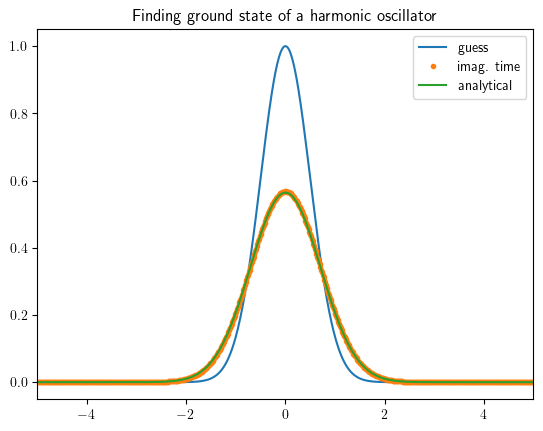

In [ ]:
# Using typical parameters in cold atom experiments
mass = 1.4e-25      # Mass of 87Rb
omega = 2.0*pi*150  # 150 Hz trapping frequency. This is for the trap in which we condense the atoms.

length_scale = (hbar/mass/omega)**0.5
time_scale = 1.0/omega
energy_scale = hbar*omega

velocity_scale = length_scale/time_scale

kB = 1.380649e-23 # Boltzmann constant

# we shall work in units of the harmonic oscillator strength

# N_x = 80000
# N_x = 200000 # number of points in which x- space is divided

N_x = 25000
# N_x = 50000
L = (N_x-1)*np.sqrt(pi/(2*N_x)) # the length of position space is 2L
X = np.linspace(-L,L, N_x)

# N_x = 200000 # number of points in which x- space is divided
# X = np.linspace(-2000,2000, N_x)

dx = X[1] - X[0]
U_trap = 0.5*X**2 # trap potential (harmonic)
U_free = 0 # free evolution --- U = 0

psi_guess = np.exp(-X**2)
psi_analytical = (pi)**-0.25*np.exp(-X**2/2.0)

# normalize it
# Take kappa = 0, epsilon = 1 for GPE to reduce to the Schrodinger equation
# Take imaginary time to find the ground state 

k = 0.001

(K, T, psi_ground, ep) = gpe1d_python(epsilon=1.0, kappa=0.0, N=5000, 
                            k=0.001, X=X, U=U_trap, psi0=psi_guess, Ntstore=11, 
                            imag_time=1, error=0.0001)   


# (K, T, psi_ground, ep) = gpe1d_python(epsilon=1.0, kappa=0.0, N=40000, 
#                             k=0.001/10, X=X, U=U_trap, psi0=psi_guess, Ntstore=11, 
#                             imag_time=1, error=0.0002/3)   

# Plot the ground state of the wavefunction

plt.title('Finding ground state of a harmonic oscillator')
plt.plot(X, Prob(psi_guess))
plt.plot(X, Prob(psi_ground),'.')
plt.plot(X, Prob(psi_analytical))
plt.legend(['guess', 'imag. time', 'analytical'])
plt.xlim(-5,5)
plt.show()

In [4]:
print("L = ", L)
print("N_x = ", N_x)
print("Time scale = ",1000*time_scale, "ms")
print("Energy scale = ",energy_scale*1e9/kB, "nK")
print("Length scale = ",length_scale*1e6, "um")
print("Length scale/sqrt(2) = ",length_scale*1e6/np.sqrt(2), " um")

L =  198.15843822570534
N_x =  25000
Time scale =  1.061032953945969 ms
Energy scale =  7.1988646100493305 nK
Length scale =  0.8940020177451148 um
Length scale/sqrt(2) =  0.6321548891420268  um


In [5]:
sigma_wavefunction_ground = np.real(np.sqrt(expectation_value(X,psi_ground,X**2)-(expectation_value(X,psi_ground,X)**2))) # spread of the initial wave packet
print("Spread of the initial wave function = ",sigma_wavefunction_ground)

sigma_k_ground = 1/(2*sigma_wavefunction_ground)

print("Spread of k-space wavefunction = ", sigma_k_ground, " = ", velocity_scale*1e3*1/(2*sigma_wavefunction_ground), " mm/s")

print("Ground state x-space spread of wave function", sigma_wavefunction_ground*length_scale*1e6," um")

K = np.fft.fftshift(K)
K2 = K # extra variable to store the K values
print(K2)

Spread of the initial wave function =  0.7028027979017819
Spread of k-space wavefunction =  0.7114371221810019  =  0.5994405926443844  mm/s
Ground state x-space spread of wave function 0.6283071194011051  um
[-198.16636488 -198.15051157 -198.13465826 ...  198.11880495  198.13465826
  198.15051157]


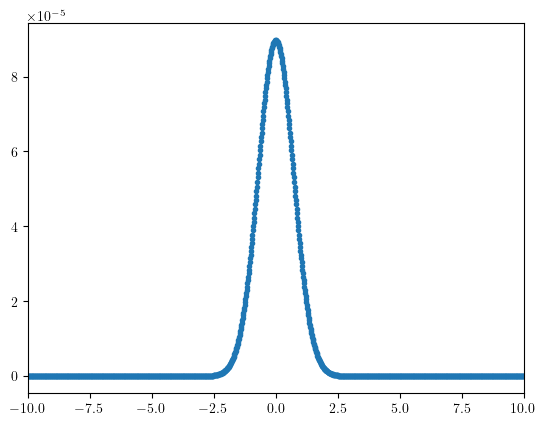

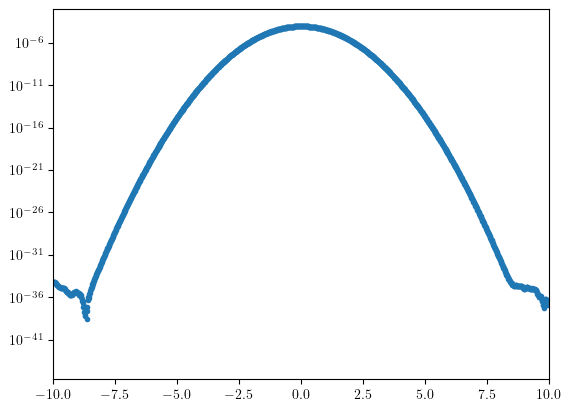

dk =  0.01585330919041894
k_max =  198.15051157117392
dx =  0.01585330919041894


In [6]:
""""Small code just to check how good resolution in k-space is"""
ft = (2/np.size(K))*fft.fft(psi_ground) # FFT
ft = np.concatenate((ft[N_x//2:], ft[:N_x//2]))

plt.plot(K,Prob(ft),'.')            
plt.xlim(-10,10)
# plt.yscale('log')
# plt.plot(X,Prob(psi_ground),'--')

plt.show()

plt.plot(K,Prob(ft),'.')            
plt.xlim(-10,10)
plt.yscale('log')
plt.show()
print("dk = ",K[1]-K[0])
print("k_max = ",max(K))

print("dx = ",dx)

##########################################################################################
##########################################################################################



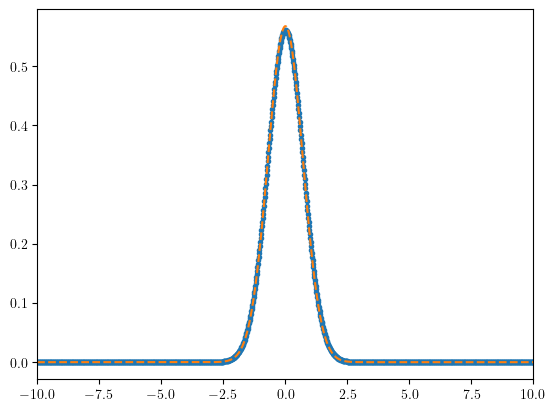

In [7]:
ft = (2/np.size(K))*fft.fft(psi_ground) # FFT
ft = np.concatenate((ft[N_x//2:], ft[:N_x//2]))    
integral = area_total(K,np.abs(ft)**2) # to get normalisation constant
ft = ft/np.sqrt(integral)
plt.plot(K,Prob(ft),'.')            
plt.xlim(-10,10)
# plt.yscale('log')
plt.plot(X,Prob(psi_ground),'--')

plt.show()


In [8]:
color_orange = (245/256,163/256,79/256) #orange
color_blue = (1/256,70/256,233/256) #blue
color_green = (12/256,164/256,12/256) #green
color_light_green = (12/256,164/256,12/256) #green
color_pink = (217/256,109/256,114/256) #light red-pink mix
color_red = (217/256,10/256,11/256)

In [9]:
"""Define parameters like the range of free expansion times for which we perform the simulations,"""

# N_f1 = 2000  # minimum value of N_free
# # N_f2 = 10000 # maximum value of N_free
# N_f2 = 24980 # maximum value of N_free
# n_Nf = 230  # number of N_free values over which we're going to run the loop

# N_f1 = 1000  # minimum value of N_free
# # N_f2 = 10000 # maximum value of N_free
# N_f2 = 25000 # maximum value of N_free
# n_Nf = 241  # number of N_free values over which we're going to run the loop

# N_f1 = 5000  # minimum value of N_free
# # N_f2 = 10000 # maximum value of N_free
# N_f2 = 9000 # maximum value of N_free
# n_Nf = 251  # number of N_free values over which we're going to run the loop

# N_f1 = 1000  # minimum value of N_free
# # N_f2 = 10000 # maximum value of N_free
# N_f2 = 5000 # maximum value of N_free
# n_Nf = 80  # number of N_free values over which we're going to run the loop

# N_f1 = 2000  # minimum value of N_free
# # N_f2 = 10000 # maximum value of N_free
# N_f2 = 12000 # maximum value of N_free
# n_Nf = 26  # number of N_free values over which we're going to run the loop

# N_f1 = 1600  # minimum value of N_free
# # N_f2 = 10000 # maximum value of N_free
# N_f2 = 12000 # maximum value of N_free
# n_Nf = 53  # number of N_free values over which we're going to run the loop

################################################

N_f1 = 1600  # minimum value of N_free
# N_f2 = 10000 # maximum value of N_free
N_f2 = 12100 # maximum value of N_free
n_Nf = 36  # number of N_free values over which we're going to run the loop


# N_f1 = 1500  # minimum value of N_free
# # N_f2 = 10000 # maximum value of N_free
# N_f2 = 2000 # maximum value of N_free
# n_Nf = 2  # number of N_free values over which we're going to run the loop

N_f = np.linspace(N_f1,N_f2,n_Nf)
print(N_f)

k = 0.001 # time step

N_delta_1 = 1
N_delta_2 = 2
N_delta_3 = 3


sigma_wavefunction_after_free_expansion = np.zeros(n_Nf) # array to store spread of wavefunction after free expansion
sigma_k_harmonic = np.zeros(n_Nf) # array to store sigma_k after free harmonic DKC

sigma_a = 15 * sigma_wavefunction_ground # size of the attractive Gaussian potential for a single kick case
# sigma_a = 5 * sigma_wavefunction_ground

sigma_k_Gaussian_Taylor = np.zeros(n_Nf)

print("K = ", K)

[ 1600.  1900.  2200.  2500.  2800.  3100.  3400.  3700.  4000.  4300.
  4600.  4900.  5200.  5500.  5800.  6100.  6400.  6700.  7000.  7300.
  7600.  7900.  8200.  8500.  8800.  9100.  9400.  9700. 10000. 10300.
 10600. 10900. 11200. 11500. 11800. 12100.]
K =  [-198.16636488 -198.15051157 -198.13465826 ...  198.11880495  198.13465826
  198.15051157]


In [10]:
"""Select location of the folder for saving the plots"""

# Get the current date and time
now = datetime.datetime.now()

# Format the date as a string (e.g., "2024-07-15")
date_str = now.strftime("%Y-%m-%d")

print(date_str)


# Define the directory and filename
directory = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,"+date_str  
directory_2 = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,"+date_str+" test"  

# filename = 'Momentum width after a Gaussian (sigma = %5.0f Delta x_i) and a Harmonic delta-kick.pdf' % (sigma_a / sigma_wavefunction_ground)
# save_path = os.path.join(directory, filename)

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)


2025-05-12


Matrix eqn kappa: [111.52335013 -84.62777321]
Matrix eqn parameters: sigma_k/sigma_k_i: 0.18649539057426184
Grad descent iteration num = 0,Converged after 23 iterations
Initial kappa: [111.52335013 -84.62777321]
Initial sigma_k/sigma_k_i: 0.18649539057426184
Optimized parameters: [112.03080809 -84.14648747]
Minimum sigma_k/sigma_k_i: 0.17795615642118
Delta x_f/Delta x_i =  7.758089044297661


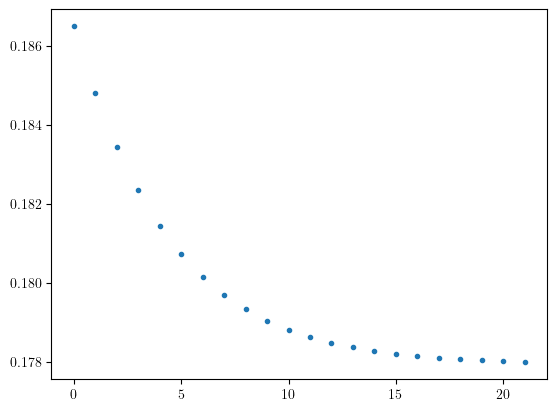

In [12]:
""" Gradient descent """
""" I define the different functions here for gradient descent and 
do a test case for 2 delta kicks and a randomly chosen free expansion time 
"""


N_delta = 2 # number of delta kicks
N_f_index = 20

# sigma_k_2_delta_kick = np.zeros(n_Nf)
# ft_psi_after_2_delta_kick = np.zeros([n_Nf,N_x], dtype=np.complex128)

# define the array for the size of the different Gaussian beams used in N-DKC protocol
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
if(N_delta>1):
    for i in range(N_delta):
        if i>0:
            sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount (Example: sigma_array = (15,14,13)*sigma_wavefunction_ground )
sigma_array = sigma_array*sigma_wavefunction_ground


def kappa_matrix_eqn(sigma_array, N_delta, N_f_index): # calculates the kick strengths from solving the matrix equation 
    if (N_delta > 1):
        B = np.zeros(N_delta)
        A = np.zeros([N_delta,N_delta])
        # equation is A*kappa = B
        omega_dimensionless = 1 # this is the trap frequency after non-dimensionalising the system
        for i in range(N_delta):
            for j in range(N_delta):
                A[i,j] = 1/(sigma_array[j]**(2*(i+1)))
        # B[0] = 1/N_f[i]/k # this is for a classically inspired solution 
        B[0] = omega_dimensionless**2 * N_f[N_f_index] * k/(1 + (omega_dimensionless * N_f[N_f_index] * k)**2) # this is for a generalized DKC inspired solution
        A_inv = np.linalg.inv(A)
        kappa = np.matmul(A_inv,B) # kappa = A_inv*B
        return kappa
    else:
        kappa = np.array((sigma_array[0]**2) *(N_f[N_f_index]*k)/ (1 + (N_f[N_f_index]*k)**2))
        return np.array([kappa])

def kappa_matrix_eqn_generalized_DKC(sigma_array, N_delta, N_f_index): # calculates the kick strengths from solving the matrix equation 
    if (N_delta > 1):
        B = np.zeros(N_delta)
        A = np.zeros([N_delta,N_delta])
        # equation is A*kappa = B
        omega_dimensionless = 1
        for i in range(N_delta):
            for j in range(N_delta):
                A[i,j] = 1/(sigma_array[j]**(2*(i+1)))
        B[0] = omega_dimensionless**2 * N_f[N_f_index] * k/(1 + (omega_dimensionless * N_f[N_f_index] * k)**2)
        A_inv = np.linalg.inv(A)
        kappa = np.matmul(A_inv,B) # kappa = A_inv*B
    else:
        kappa = np.array((sigma_array[0]**2) *(N_f[N_f_index]*k)/ (1 + (N_f[N_f_index]*k)**2))
    return kappa


def kappa_matrix_eqn_classical(sigma_array, N_delta, N_f_index): # calculates the kick strengths from solving the matrix equation 
    if (N_delta > 1):
        B = np.zeros(N_delta)
        A = np.zeros([N_delta,N_delta])
        # equation is A*kappa = B
        omega_dimensionless = 1
        for i in range(N_delta):
            for j in range(N_delta):
                A[i,j] = 1/(sigma_array[j]**(2*(i+1)))
        B[0] = 1/N_f[N_f_index]/k
        A_inv = np.linalg.inv(A)
        kappa = np.matmul(A_inv,B) # kappa = A_inv*B
    else:
        kappa = np.array((sigma_array[0]**2) *(N_f[N_f_index]*k)/ (1 + (N_f[N_f_index]*k)**2))
    return kappa








# calculate the wavefunction after N_delta number of kicks
# free expansion time = N_f, RMS of different potentials = sigma_array, kick strengths = kappa
def calculate_sigma_k(kappa, sigma_array, N_f_index, N_delta):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5))
    psi_after_N_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
    if (N_delta > 1):
        for j in range(1, N_delta): # 2nd till N_th delta kick
            psi_after_N_delta_kick = psi_after_N_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
    ft_psi_after_N_delta_kick = (2/np.size(K))*np.abs(fft.fft(psi_after_N_delta_kick)) # FFT of psi after delta kick
    ft_psi_after_N_delta_kick = np.concatenate((ft_psi_after_N_delta_kick[N_x//2:], ft_psi_after_N_delta_kick[:N_x//2]))    
    integral = area_total(K,ft_psi_after_N_delta_kick**2) # to get normalisation constant
    ft_psi_after_N_delta_kick = ft_psi_after_N_delta_kick/np.sqrt(integral)
    sigma_k_N_delta_kick = np.real(np.sqrt(expectation_value(K,ft_psi_after_N_delta_kick,K**2)-(expectation_value(K,ft_psi_after_N_delta_kick,K)**2))) # spread in k space
    return sigma_k_N_delta_kick

# Function to compute the numerical gradient
def compute_numerical_gradient(kappa, epsilon, sigma_array, N_f_index, N_delta):
    # epsilon is for numerical differentiation 
    grad = np.zeros_like(kappa)
    for i in range(len(kappa)):
        kappa_plus = np.copy(kappa)
        kappa_minus = np.copy(kappa)
        kappa_plus[i] += epsilon
        kappa_minus[i] -= epsilon
        grad[i] = (calculate_sigma_k(kappa_plus,sigma_array,N_f_index, N_delta) - calculate_sigma_k(kappa_minus,sigma_array,N_f_index, N_delta)) / (2 * epsilon)
    return grad

# # Gradient descent function
# This function below doesn't take N_delta as input so I am writing a new function below for gradient descent that does that
# def gradient_descent(func, initial_kappa, learning_rate, num_iterations, tolerance):
#     # here func is the functions that's been minimized using gradient descent (in our case, it's calculate_sigma_k). 
#     kappa = np.copy(initial_kappa) # create a duplicate of the initial kappa matrix
#     sigma_k_iterations = np.zeros(num_iterations) # this is the array for storing sigma_k value for a given kick strength
#                                                   # each iteration will have a different kick strength that we're iterating over
#     sigma_k_iterations[0] = calculate_sigma_k(kappa,sigma_array,N_f_index, N_delta)
#     for i in range(num_iterations):
#         if i % 50 == 0:
#             print(i, end = ",") # just printing every 50th value so that I can easily keep track of how fast the simulations are going
#         grad = compute_numerical_gradient(kappa, epsilon=1e-6, sigma_array = sigma_array, N_f_index = N_f_index, N_delta = N_delta)
#         kappa -= learning_rate * grad
#         # Enforce the bounds
#         # kappa = np.clip(kappa, bounds[:, 0], bounds[:, 1])
#         if i < num_iterations-1:
#             sigma_k_iterations[i+1] = calculate_sigma_k(kappa,sigma_array,N_f_index, N_delta)
#             # Check for convergence
#             if np.abs(sigma_k_iterations[i+1] - sigma_k_iterations[i]) < tolerance:
#                 print(f"Converged after {i + 1} iterations")
#                 # sigma_k_iterations[]
#                 break
#     return kappa, sigma_k_iterations, i


def gradient_descent(func, initial_kappa, N_delta, learning_rate, num_iterations, tolerance):
    # here func is the functions that's been minimized using gradient descent (in our case, it's calculate_sigma_k). 
    # decay = 0.99
    kappa = np.copy(initial_kappa) # create a duplicate of the initial kappa matrix
    sigma_k_iterations = np.zeros(num_iterations) # this is the array for storing sigma_k value for a given kick strength
                                                  # each iteration will have a different kick strength that we're iterating over
    sigma_k_iterations[0] = calculate_sigma_k(kappa,sigma_array,N_f_index, N_delta)
    print("Grad descent iteration num = ", end='')
    for i in range(num_iterations):
        if i % 50 == 0:
            print(i, end = ",") # just printing every 50th value so that I can easily keep track of how fast the simulations are going
        grad = compute_numerical_gradient(kappa, epsilon=1e-6, sigma_array = sigma_array, N_f_index = N_f_index, N_delta = N_delta)
        kappa -= learning_rate * grad
        # learning_rate *= decay
        # Enforce the bounds
        # kappa = np.clip(kappa, bounds[:, 0], bounds[:, 1])
        if i < num_iterations-1:
            sigma_k_iterations[i+1] = calculate_sigma_k(kappa,sigma_array,N_f_index, N_delta)
            # Check for convergence
            if np.abs(sigma_k_iterations[i+1] - sigma_k_iterations[i]) < tolerance:
                print(f"Converged after {i + 1} iterations")
                # sigma_k_iterations[]
                break
    return kappa, sigma_k_iterations, i



# prev_cost = func(kappa)  # Calculate the initial cost
# for iteration in range(num_iterations):
#     grad = compute_numerical_gradient(func, kappa)  # Compute the gradient
#     kappa -= learning_rate * grad  # Update the parameters using the learning rate
#     # Enforce the bounds
#     kappa = np.clip(kappa, bounds[:, 0], bounds[:, 1])  # Ensure parameters are within bounds
#     # Calculate the new cost
#     current_cost = func(kappa)
#     prev_cost = current_cost  # Update the previous cost


# N_initial_kappa_factor = 20
# initial_kappa_factor = np.linspace(0.5,2,N_initial_kappa_factor)

# Initial values of parameters
# initial_kappa_reduced = np.array([0.5, 0.5, 0.5])
# initial_kappa = kappa_matrix_eqn(sigma_array, N_delta, N_f_index) * initial_kappa_reduced
initial_kappa = 1*kappa_matrix_eqn(sigma_array, N_delta, N_f_index)
# initial_kappa[0] = initial_kappa[0] * 0.95
# initial_kappa = [100, -50]

# Hyperparameters
learning_rate = 5
num_iterations = 200
tolerance = 1e-5

# Bounds for the parameters
# bounds = np.zeros((N_delta, 2))
# for i in range(N_delta):
#     bounds[i,0] = initial_kappa[i] * 0.5
#     bounds[i,1] = initial_kappa[i] * 1.5

print(f"Matrix eqn kappa: {kappa_matrix_eqn(sigma_array, N_delta, N_f_index)}")
print(f"Matrix eqn parameters: sigma_k/sigma_k_i: {calculate_sigma_k(kappa_matrix_eqn(sigma_array, N_delta, N_f_index),sigma_array, N_f_index, N_delta)/sigma_k_ground}")


# for i in range(N_initial_kappa_factor):
    # initial_kappa = initial_kappa_factor * kappa_matrix_eqn(sigma_array, N_delta, N_f_index)
    # Perform gradient descent
    # optimized_kappa, sigma_k_iterations = gradient_descent(calculate_sigma_k, initial_kappa, learning_rate, num_iterations, bounds)
optimized_kappa, sigma_k_iterations, convergence_iteration = gradient_descent(calculate_sigma_k, initial_kappa, N_delta, learning_rate, num_iterations, tolerance)
print(f"Initial kappa: {initial_kappa}")
print(f"Initial sigma_k/sigma_k_i: {calculate_sigma_k(initial_kappa,sigma_array, N_f_index, N_delta)/sigma_k_ground}")
# print(f"Bounds for kappa: {bounds}")
print(f"Optimized parameters: {optimized_kappa}")
print(f"Minimum sigma_k/sigma_k_i: {calculate_sigma_k(optimized_kappa,sigma_array, N_f_index, N_delta)/sigma_k_ground}")



psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5))
print("Delta x_f/Delta x_i = ",np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2)))/sigma_wavefunction_ground) # spread of the wave packet just before delta kick (after free expansion)

plt.plot(range(convergence_iteration), sigma_k_iterations[0:convergence_iteration]/sigma_k_ground,'.')
plt.show()

In [13]:
"""Now store sigma_k values for Harmonic delta kick"""

ft_psi_after_harmonic_delta_kick = np.zeros([n_Nf,N_x], dtype=np.complex128)
psi_after_free_evolution = np.zeros([n_Nf,N_x], dtype=np.complex128)
psi_after_harmonic_kick = np.zeros([n_Nf,N_x], dtype=np.complex128)

omega_dimensionless = 1

for i in range(n_Nf):
    kick_str_harmonic = omega_dimensionless**2 * N_f[i] * k/(1 + (omega_dimensionless * N_f[i] * k)**2)
    psi_after_free_evolution[i,:] = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution[i,:],X**2)-(expectation_value(X,psi_after_free_evolution[i,:],X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    psi_after_harmonic_kick[i,:] = psi_after_free_evolution[i,:]*np.exp(-1j *kick_str_harmonic *X*X/(2))
    # psi_after_harmonic_kick = psi_after_free_evolution*np.exp(-1j*X*X/(2*N_f[i]*k))
    ft_psi_after_harmonic_delta_kick[i,:] = (2/np.size(K))*(fft.fft(psi_after_harmonic_kick[i,:])) # FFT of psi after harmonic delta kick
    ft_psi_after_harmonic_delta_kick[i,:] = np.concatenate((ft_psi_after_harmonic_delta_kick[i,N_x//2:], ft_psi_after_harmonic_delta_kick[i,:N_x//2]))
    integral = area_total(K,np.abs(ft_psi_after_harmonic_delta_kick[i,:])**2) # to get normalisation constant
    ft_psi_after_harmonic_delta_kick[i,:] = ft_psi_after_harmonic_delta_kick[i,:]/np.sqrt(integral)
    sigma_k_harmonic[i] = np.real(np.sqrt(expectation_value(K,ft_psi_after_harmonic_delta_kick[i,:],K**2)-(expectation_value(K,ft_psi_after_harmonic_delta_kick[i,:],K)**2))) # spread in k space
    if i % 20 == 0:
        print(i)


0
20


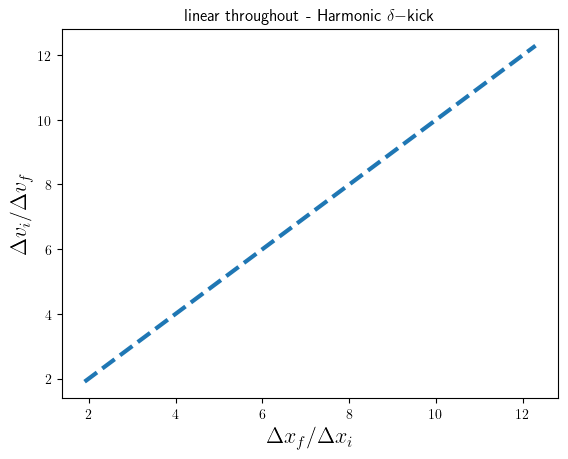

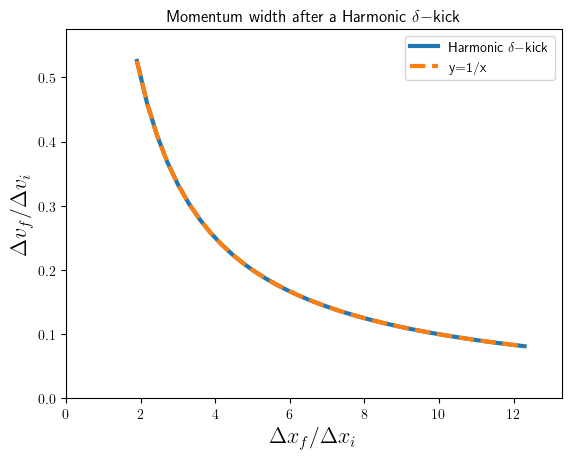

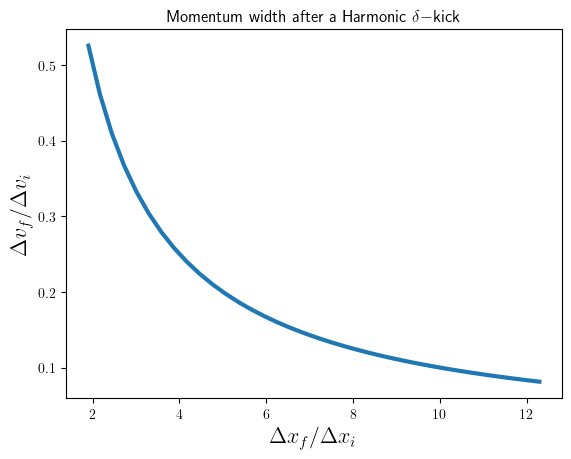

In [14]:
"""Plotting sigma_k values for a harmonic delta kick for different free expansion times"""

# plt.plot(N_f*k,1/sigma_k_harmonic,'.')
# plt.plot(N_f*k ,)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_ground/sigma_k_harmonic, '--', linewidth = 3)
plt.title("linear throughout - Harmonic $\delta-$kick")
plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_i/\Delta v_f$',fontsize = 16)
# plt.savefig("1byMomentum width after a Harmonic delta-kick.pdf")
plt.show()

###

fig, ax = plt.subplots(1,1)
ax.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, linewidth = 3, label = 'Harmonic $\delta-$kick')
ax.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_wavefunction_ground/sigma_wavefunction_after_free_expansion, '--', linewidth = 3, label = 'y=1/x')
plt.title("Momentum width after a Harmonic $\delta-$kick")
plt.legend()
plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
ax.set_xlim([0, max(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground)+1])
ax.set_ylim([0, max(sigma_k_harmonic/sigma_k_ground)+0.05])
# plt.title('Plot with LaTeX \frac{}{} in xlabel')
# plt.tight_layout()
# plt.savefig("Momentum width after a Harmonic delta-kick as a function of free expansion and 1byx.pdf")
# Show plot
plt.show()

###

plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, linewidth = 3)
plt.title("Momentum width after a Harmonic $\delta-$kick")
plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
# plt.tight_layout()
# plt.savefig("Momentum width after a Harmonic delta-kick as a function of free expansion.pdf")
# Show plot
plt.show()


In [15]:
"""1 Gaussian delta kick case"""
"""Now store sigma_k values for Gaussian delta kick -- calc by just cancelling the first term in Taylor expansion"""
""" Classically inspired approach """

ft_psi_after_Gaussian_delta_kick_Taylor = np.zeros([n_Nf,N_x], dtype=np.complex128)

for i in range(n_Nf):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    kick_strength = (sigma_a**2)/(N_f[i]*k)
    # psi_after_Gaussian_kick_Taylor = np.exp(-1j*kick_strength*(1-np.exp(-0.5*(X**2)/(sigma_a**2)))) * psi_after_free_evolution
    psi_after_Gaussian_kick_Taylor = psi_after_free_evolution*np.exp(-1j*kick_strength*(1-np.exp(-0.5*(X**2)/(sigma_a**2))))
    ft_psi_after_Gaussian_delta_kick_Taylor[i,:] = (2/np.size(K))*(fft.fft(psi_after_Gaussian_kick_Taylor)) # FFT of psi after delta kick
    ft_psi_after_Gaussian_delta_kick_Taylor[i,:] = np.concatenate((ft_psi_after_Gaussian_delta_kick_Taylor[i,N_x//2:], ft_psi_after_Gaussian_delta_kick_Taylor[i,:N_x//2]))    
    integral = area_total(K,np.abs(ft_psi_after_Gaussian_delta_kick_Taylor[i,:])**2) # to get normalisation constant
    ft_psi_after_Gaussian_delta_kick_Taylor[i,:] = ft_psi_after_Gaussian_delta_kick_Taylor[i,:]/np.sqrt(integral)
    sigma_k_Gaussian_Taylor[i] = np.real(np.sqrt(expectation_value(K,ft_psi_after_Gaussian_delta_kick_Taylor[i,:],K**2)-(expectation_value(K,ft_psi_after_Gaussian_delta_kick_Taylor[i,:],K)**2))) # spread in k space
    if i % 20 == 0:
        print(i)


0
20


In [16]:
"""1 Gaussian delta kick case"""
"""Now store sigma_k values for Gaussian delta kick -- calc by cancelling the first term in Taylor expansion in the generalized DKC approach"""

ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv = np.zeros([n_Nf,N_x], dtype=np.complex128)
sigma_k_Gaussian_Taylor_scale_inv = np.zeros(n_Nf)

for i in range(n_Nf):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    kick_strength = (sigma_a**2) *(N_f[i]*k)/ (1 + (N_f[i]*k)**2)
    # psi_after_Gaussian_kick_Taylor = np.exp(-1j*kick_strength*(1-np.exp(-0.5*(X**2)/(sigma_a**2)))) * psi_after_free_evolution
    psi_after_Gaussian_kick_Taylor_scale_inv = psi_after_free_evolution*np.exp(-1j*kick_strength*(1-np.exp(-0.5*(X**2)/(sigma_a**2))))
    ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,:] = (2/np.size(K))*(fft.fft(psi_after_Gaussian_kick_Taylor_scale_inv)) # FFT of psi after delta kick
    ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,:] = np.concatenate((ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,N_x//2:], ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,:N_x//2]))    
    integral = area_total(K,np.abs(ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,:])**2) # to get normalisation constant
    ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,:] = ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,:]/np.sqrt(integral)
    sigma_k_Gaussian_Taylor_scale_inv[i] = np.real(np.sqrt(expectation_value(K,ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,:],K**2)-(expectation_value(K,ft_psi_after_Gaussian_delta_kick_Taylor_scale_inv[i,:],K)**2))) # spread in k space
    if i % 20 == 0:
        print(i)

0
20


In [17]:
"""For numerically optimising 1 Gaussian delta kick case"""

# n_alpha = 60
# alpha_start = 0.5
# alpha_end = 1.9

# n_alpha = 100
# alpha_start = 0.5
# alpha_end = 2.5


n_alpha = 150
alpha_start = 0.5
alpha_end = 1.95

# alpha_opt = 0.9
alpha = np.linspace(alpha_start,alpha_end,n_alpha)
sigma_k_Gaussian_opt = np.zeros([n_Nf,n_alpha])
ft_psi_after_Gaussian_delta_kick_opt = np.zeros([n_Nf,n_alpha,N_x], dtype=np.complex128)
print(np.round(alpha,3))

[0.5   0.51  0.519 0.529 0.539 0.549 0.558 0.568 0.578 0.588 0.597 0.607
 0.617 0.627 0.636 0.646 0.656 0.665 0.675 0.685 0.695 0.704 0.714 0.724
 0.734 0.743 0.753 0.763 0.772 0.782 0.792 0.802 0.811 0.821 0.831 0.841
 0.85  0.86  0.87  0.88  0.889 0.899 0.909 0.918 0.928 0.938 0.948 0.957
 0.967 0.977 0.987 0.996 1.006 1.016 1.026 1.035 1.045 1.055 1.064 1.074
 1.084 1.094 1.103 1.113 1.123 1.133 1.142 1.152 1.162 1.171 1.181 1.191
 1.201 1.21  1.22  1.23  1.24  1.249 1.259 1.269 1.279 1.288 1.298 1.308
 1.317 1.327 1.337 1.347 1.356 1.366 1.376 1.386 1.395 1.405 1.415 1.424
 1.434 1.444 1.454 1.463 1.473 1.483 1.493 1.502 1.512 1.522 1.532 1.541
 1.551 1.561 1.57  1.58  1.59  1.6   1.609 1.619 1.629 1.639 1.648 1.658
 1.668 1.678 1.687 1.697 1.707 1.716 1.726 1.736 1.746 1.755 1.765 1.775
 1.785 1.794 1.804 1.814 1.823 1.833 1.843 1.853 1.862 1.872 1.882 1.892
 1.901 1.911 1.921 1.931 1.94  1.95 ]


In [18]:
"""1 Gaussian delta kick case"""
"""Now store sigma_k values for Gaussian delta kick -- calc by optimising kick strength numerically"""

for i in range(n_Nf):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    if i < n_Nf-1:
        print(round(N_f[i]*k,3), end=', ')
    else:
        print(round(N_f[i]*k,3))
    for j in range(n_alpha):
        kick_strength = alpha[j]*(sigma_a**2)/(N_f[i]*k)
        psi_after_Gaussian_kick_opt = psi_after_free_evolution*np.exp(-1j*kick_strength*(1-np.exp(-0.5*(X**2)/(sigma_a**2))))
        ft_psi_after_Gaussian_delta_kick_opt[i,j,:] = (2/np.size(K))*(fft.fft(psi_after_Gaussian_kick_opt)) # FFT of psi after delta kick
        ft_psi_after_Gaussian_delta_kick_opt[i,j,:] = np.concatenate((ft_psi_after_Gaussian_delta_kick_opt[i,j,N_x//2:], ft_psi_after_Gaussian_delta_kick_opt[i,j,:N_x//2]))    
        integral = area_total(K,np.abs(ft_psi_after_Gaussian_delta_kick_opt[i,j,:])**2) # to get normalisation constant
        ft_psi_after_Gaussian_delta_kick_opt[i,j,:] = ft_psi_after_Gaussian_delta_kick_opt[i,j,:]/np.sqrt(integral)
        sigma_k_Gaussian_opt[i,j] = np.real(np.sqrt(expectation_value(K,ft_psi_after_Gaussian_delta_kick_opt[i,j,:],K**2)-(expectation_value(K,ft_psi_after_Gaussian_delta_kick_opt[i,j,:],K)**2))) # spread in k space


1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4.0, 4.3, 4.6, 4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7.0, 7.3, 7.6, 7.9, 8.2, 8.5, 8.8, 9.1, 9.4, 9.7, 10.0, 10.3, 10.6, 10.9, 11.2, 11.5, 11.8, 12.1


0


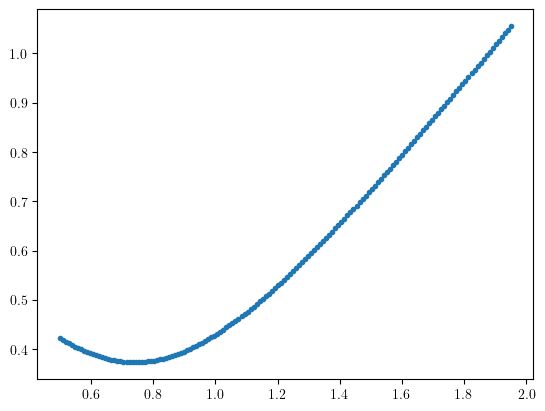

3


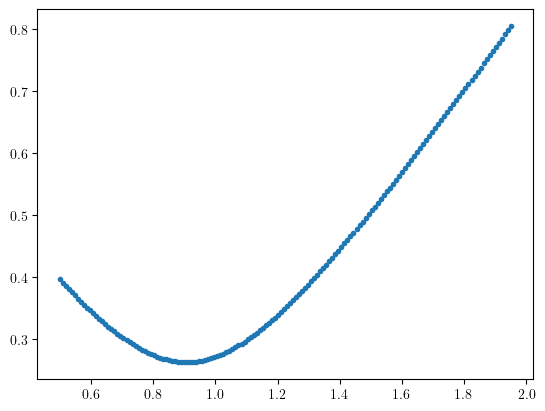

7


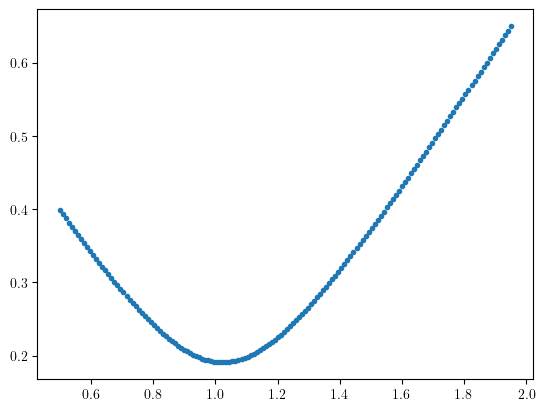

10


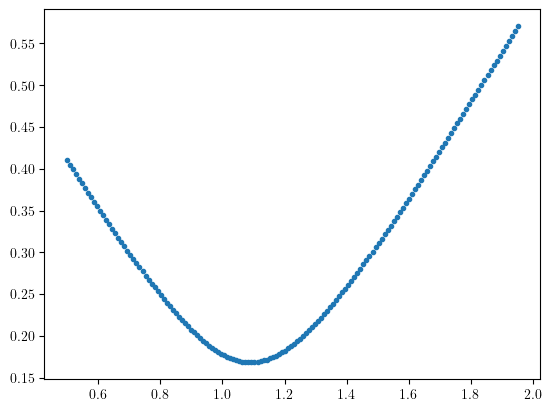

14


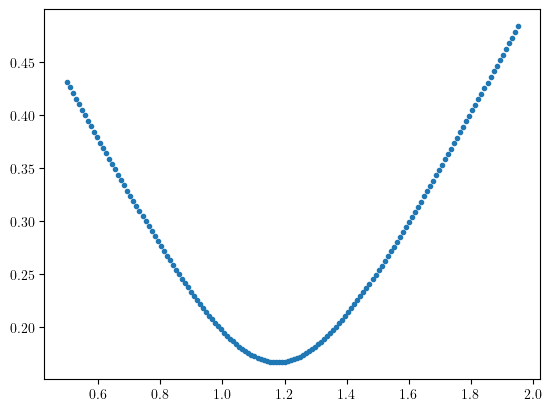

18


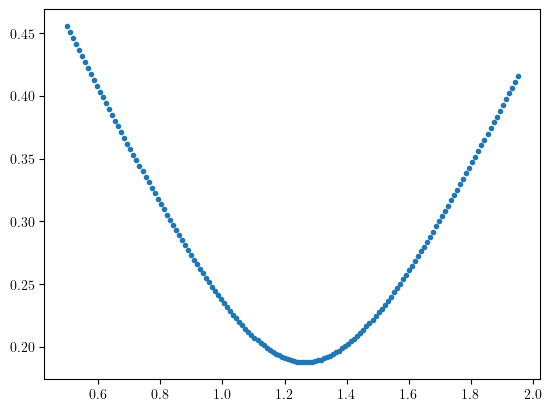

21


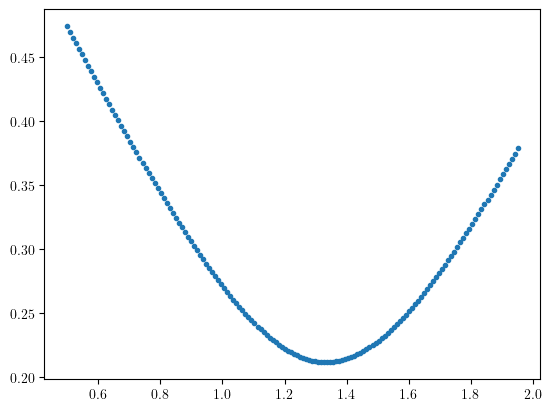

25


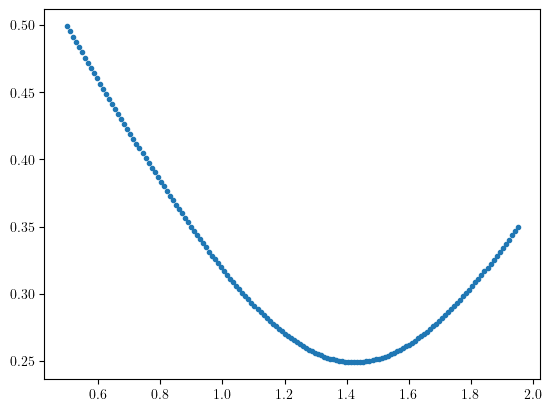

28


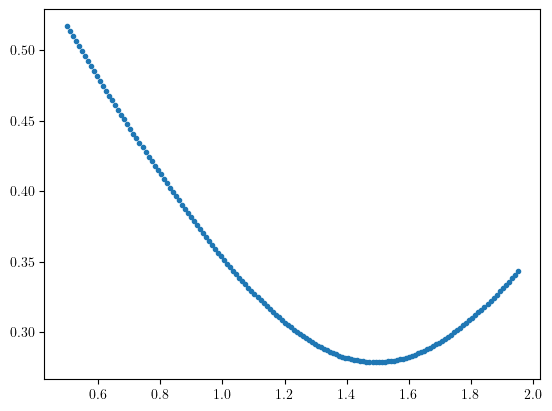

32


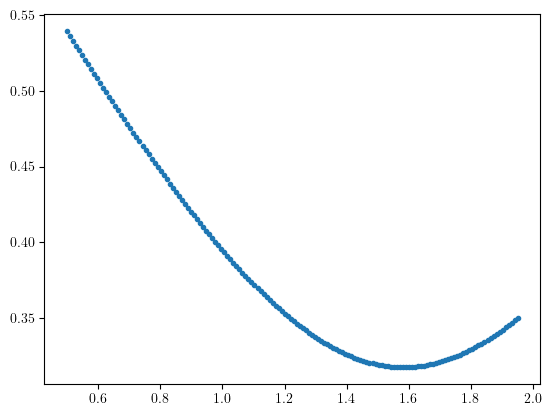

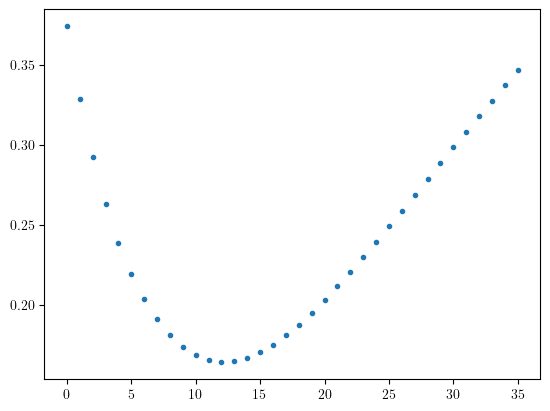

Minimum sigma_k for different N_f values =  [0.37394154 0.32856862 0.29216521 0.26272568 0.23882825 0.21937345
 0.20357626 0.19094121 0.18104416 0.17365103 0.1685007  0.16542188
 0.16426553 0.16485974 0.16701729 0.17053909 0.17528516 0.18108635
 0.18776141 0.19517009 0.20320575 0.21173802 0.22066105 0.22991251
 0.23939881 0.24905901 0.25885159 0.26870919 0.27860175 0.28849932
 0.29835666 0.30815577 0.31787753 0.32749816 0.33699526 0.3463629 ]


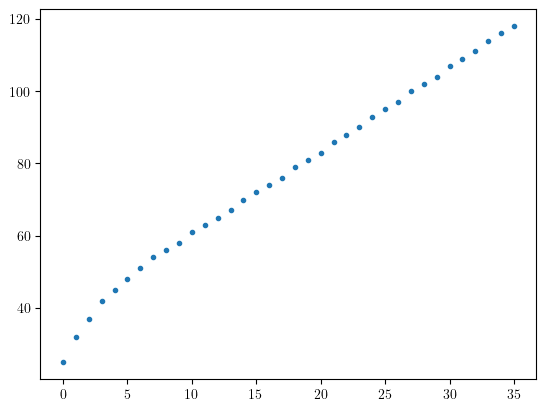

In [19]:
"""This plot is just to show that the optimization is doing fine.
 The different plots here are for different free expansion time. Each plot has x-axis telling how strong the kick strength
 is compared to that given by a Taylor expansion for the Generalized DKC approach from scale invariance"""

for i in range(10):
    print(i*n_Nf//10)
    plt.plot(alpha, sigma_k_Gaussian_opt[i*n_Nf//10 ,:],'.')
    plt.show()
# print(sigma_k_Gaussian_opt[])

plt.plot(np.min(sigma_k_Gaussian_opt,axis=1),'.') # this is the minimum sigma_k at each value of free expansion time for a single Gaussian kick
plt.show()
print("Minimum sigma_k for different N_f values = ", np.min(sigma_k_Gaussian_opt,axis=1))

plt.plot(np.argmin(sigma_k_Gaussian_opt, axis=1),'.')
plt.show()


In [102]:
# min_index_alpha = np.argmin(sigma_k_Gaussian_opt, axis=1)
# for i in range(n_Nf):
#     psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
#     sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
#     # for j in range(n_alpha):
#     kick_strength = alpha[min_index_alpha[i]]*(sigma_a**2)/(N_f[i]*k)
#     print(kick_strength)
    # psi_after_Gaussian_kick_opt
# kick_strength = alpha[j]*(sigma_a**2)/(N_f[i]*k)

46.390296610048914
41.46501103529781
37.46584753443152
34.04551032974325
31.385248059430147
28.920266579948827
27.209619608764868
25.50343741341921
24.31879991215045
23.062845151612336
21.97435102581264
21.232400955257187
20.37963814992541
19.808722135869846
19.120654300540746
18.669779080359977
18.101476898657925
17.737916580397354
17.25954774058081
16.961364497095172
16.552327247796036
16.304281965070242
15.949880161349748
15.741068366191731
15.43052922475812
15.252949913830362


t_f = N_f * k = N_f * 0.001 = 6.0, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,Converged after 929 iterations
______________
[43.81736476]
[0.50065332 0.5000785  0.49950455 0.49893148 0.49835928 0.49778796
 0.49721752 0.49664796 0.49607928 0.49551149 0.49494458 0.49437855
 0.49381342 0.49324918 0.49268583 0.49212337 0.49156181 0.49100114
 0.49044137 0.48988251 0.48932454 0.48876748 0.48821133 0.48765608
 0.48710174 0.48654831 0.48599579 0.48544418 0.48489349 0.48434372
 0.48379486 0.48324692 0.48269991 0.48215381 0.48160864 0.4810644
 0.48052109 0.4799787  0.47943724 0.47889672 0.47835713 0.47781848
 0.47728076 0.47674398 0.47620814 0.47567324 0.47513929 0.47460628
 0.47407421 0.47354309 0.47301292 0.47248371 0.47195544 0.47142813
 0.47090177 0.47037637 0.46985192 0.46932844 0.46880591 0.46828435
 0.46776375 0.46724412 0.46672545 0.46620775 0.46569102 0.46517527
 0.46466048 0.46414666 0.46363383 0.46312196 0.46261108 0.46210117


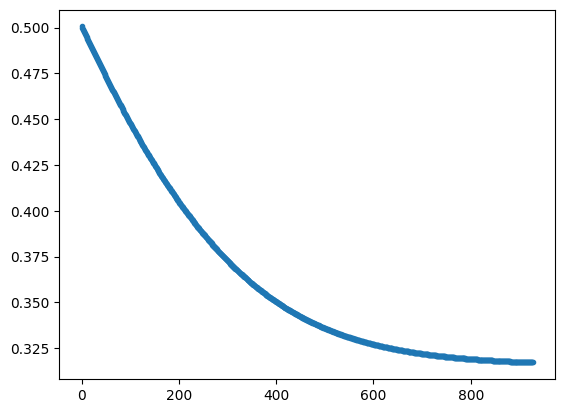

In [113]:
# i = 10
# learning_rate = 5
# num_iterations = 1000
# tolerance = 1e-5
# psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
# sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
# print(f"t_f = N_f * k = N_f * 0.001 = {round(N_f[i]*k,3)}", end=', ')

# initial_kappa = kappa_matrix_eqn(np.array([sigma_a]), N_delta=1, N_f_index=i)
# aaa,bbb,ccc = gradient_descent(calculate_sigma_k, initial_kappa, N_delta=1 ,learning_rate=learning_rate, num_iterations=num_iterations, tolerance=tolerance)

# print("______________")
# print(aaa)
# print(bbb)
# print(ccc)
# plt.plot(range(ccc), bbb[0:ccc],'.')
# # print(sigma_k_Gaussian_grad_descent_iterations[i,:])
# # print(f"convergence iteration # = {convergence_iteration}", end=', ')
# # print(f"sigma_k = {sigma_k_Gaussian_grad_descent_iterations}")
# # print("________________________________________________________________________________")


In [ ]:
"""I also want to try gradient descent for optimizing a single Gaussian kick case"""

"""Didn't work out as well. Using a loop like I did above gave better results, so I am commenting this out for now"""


# # Hyperparameters
# learning_rate = 5
# num_iterations = 1000
# tolerance = 1e-5

# N_delta = 1

# sigma_k_Gaussian_grad_descent_iterations = np.zeros([n_Nf, num_iterations])
# convergence_iteration = np.zeros(n_Nf, dtype=int)
# sigma_k_Gaussian_grad_descent = np.zeros(n_Nf)
# optimized_kappa_Gaussian_grad_descent = np.zeros([n_Nf, N_delta])

# for i in range(n_Nf):
#     psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
#     sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
#     print(f"t_f = N_f * k = N_f * 0.001 = {round(N_f[i]*k,3)}", end=', ')
#     initial_kappa = kappa_matrix_eqn(np.array([sigma_a]), N_delta=1, N_f_index=i)
#     optimized_kappa_Gaussian_grad_descent[i,:], sigma_k_Gaussian_grad_descent_iterations[i,:], convergence_iteration[i] = gradient_descent(calculate_sigma_k, initial_kappa, N_delta=1 ,learning_rate=learning_rate, num_iterations=num_iterations, tolerance=tolerance)
#     # print(sigma_k_Gaussian_grad_descent_iterations[i,:])
#     print(f"i = {i}", end=', ')
#     print(f"convergence iteration # = {convergence_iteration[i]}", end=', ')
#     print(f"sigma_k = {sigma_k_Gaussian_grad_descent_iterations[i,convergence_iteration[i]]}")
#     sigma_k_Gaussian_grad_descent[i] = sigma_k_Gaussian_grad_descent_iterations[i,convergence_iteration[i]]
#     print("________________________________________________________________________________")

# print("convergence_iteration = ",convergence_iteration)
# print("________________________________________________________________________________")
# print("sigma_k_Gaussian_grad_descent = ", sigma_k_Gaussian_grad_descent)








'I also want to try gradient descent for optimizing a single Gaussian kick case'

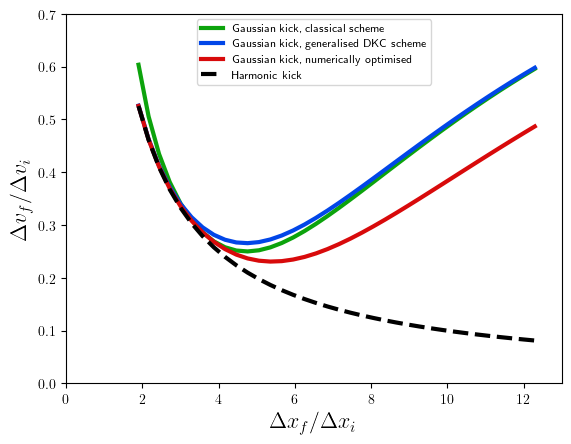

In [20]:
sigma_k_Gaussian_opt_min = np.zeros(n_Nf)
sigma_k_Gaussian_opt_min = np.min(sigma_k_Gaussian_opt, axis=1)


plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground ,'-' , linewidth = 3, color = color_green, label = 'Gaussian kick, classical scheme')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'-' , linewidth = 3, color = color_blue, label = 'Gaussian kick, generalised DKC scheme')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,'-' , linewidth = 3, color = color_red, label = 'Gaussian kick, numerically optimised')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black', label = 'Harmonic kick')


plt.legend(loc = 'upper center',prop={"size":8})
# plt.legend(loc='upper left', bbox_to_anchor=(0.055, 0.99), prop={"size": 9.5})


plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
# plt.title('Momentum width after a Gaussian and a Harmonic $\delta-$kick')

plt.xlim(0,13)
plt.ylim(0,0.7)

# Define the directory and filename
filename = 'Momentum width after a Gaussian (sigma = %5.0f Delta x_i) & Harmonic delta-kick, comparison of all three schemes.pdf'%tuple([sigma_a/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)

# Save the plot
# plt.savefig(save_path)

# plt.savefig('Momentum width after a Gaussian (sigma = %5.0f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_a/sigma_wavefunction_ground]))
plt.show()

In [21]:
"""Saving data till now"""

# Define the full path for the file
filename = os.path.join(directory, "N_f.npy")
# Save the array
np.save(filename, N_f)

# save the position space spread of wave function after free expansion
filename = os.path.join(directory, "sigma_wavefunction_after_free_expansion.npy")
np.save(filename, sigma_wavefunction_after_free_expansion)

"""Harmonic kick"""
# save the sigma_k after a harmonic kick
filename = os.path.join(directory, "sigma_k_harmonic.npy")
np.save(filename, sigma_k_harmonic)

"""1 Gaussian kick"""
# save the sigma_k after a Gaussian kick, calc by optimising kick strength numerically
filename = os.path.join(directory, "sigma_k_Gaussian_opt_min.npy")
np.save(filename, sigma_k_Gaussian_opt_min)

# Classically inspired scheme
filename = os.path.join(directory, "sigma_k_Gaussian_Taylor.npy")
np.save(filename, sigma_k_Gaussian_Taylor)

# Generalized DKC inspired scheme (scale invariance)
filename = os.path.join(directory, "sigma_k_Gaussian_Taylor_scale_inv.npy")
np.save(filename, sigma_k_Gaussian_Taylor_scale_inv)


In [22]:
"""Now 2 Gaussian kick case"""

N_delta_2 = 2 # number of delta kicks

sigma_k_2_delta_kick = np.zeros(n_Nf)
ft_psi_after_2_delta_kick = np.zeros([n_Nf,N_x], dtype=np.complex128)

kappa = np.zeros(N_delta_2)
B = np.zeros(N_delta_2)
A = np.zeros([N_delta_2,N_delta_2])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta_2) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta_2):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground

for i in range(N_delta_2):
    for j in range(N_delta_2):
        A[i,j] = 1/(sigma_array[j]**(2*(i+1)))


"""Now store sigma_k values for 2 delta kick case"""

for i in range(n_Nf):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    # B[0] = 1/N_f[i]/k
    B[0] = omega_dimensionless**2 * N_f[i] * k/(1 + (omega_dimensionless * N_f[i] * k)**2)
    A_inv = np.linalg.inv(A)
    kappa = np.matmul(A_inv,B) # kappa = A_inv*B
    psi_after_2_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
    for j in range(N_delta_2): # 2nd till N_th delta kick
        if j>0:
            psi_after_2_delta_kick = psi_after_2_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
    ft_psi_after_2_delta_kick[i,:] = (2/np.size(K))*(fft.fft(psi_after_2_delta_kick)) # FFT of psi after delta kick
    ft_psi_after_2_delta_kick[i,:] = np.concatenate((ft_psi_after_2_delta_kick[i,N_x//2:], ft_psi_after_2_delta_kick[i,:N_x//2]))    
    integral = area_total(K,np.abs(ft_psi_after_2_delta_kick[i,:])**2) # to get normalisation constant
    ft_psi_after_2_delta_kick[i,:] = ft_psi_after_2_delta_kick[i,:]/np.sqrt(integral)
    sigma_k_2_delta_kick[i] = np.real(np.sqrt(expectation_value(K,ft_psi_after_2_delta_kick[i,:],K**2)-(expectation_value(K,ft_psi_after_2_delta_kick[i,:],K)**2))) # spread in k space
    # print(kappa)



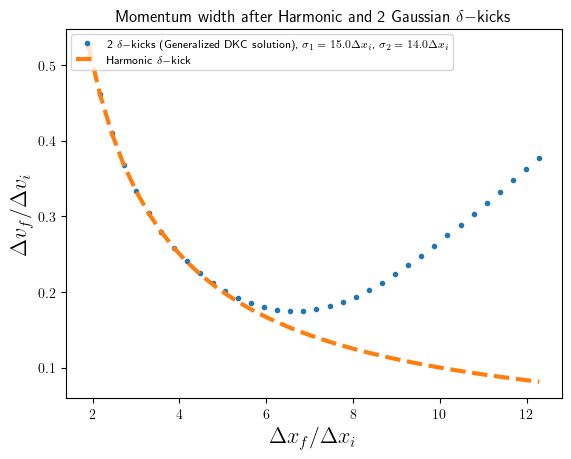

In [23]:
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '.',linewidth = 3, label = '2 $\delta-$kicks (Generalized DKC solution), $\sigma_1 = %5.1f \Delta x_i$, $\sigma_2 = %5.1f \Delta x_i$'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground]))
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, label = 'Harmonic $\delta-$kick')

plt.legend(loc = 'upper left',prop={"size":8})
# plt.xlim(0,15)

plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
plt.title('Momentum width after Harmonic and 2 Gaussian $\delta-$kicks')

# # Define filename
# filename = 'Momentum width after Harmonic, 1 and 2 Gaussian delta-kicks (sigma = %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# save_path = os.path.join(directory, filename)
# # Save the plot
# plt.savefig(save_path)



# plt.savefig('Momentum width after Harmonic, 1 and 2 Gaussian delta-kicks (sigma = %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground]))
plt.show()

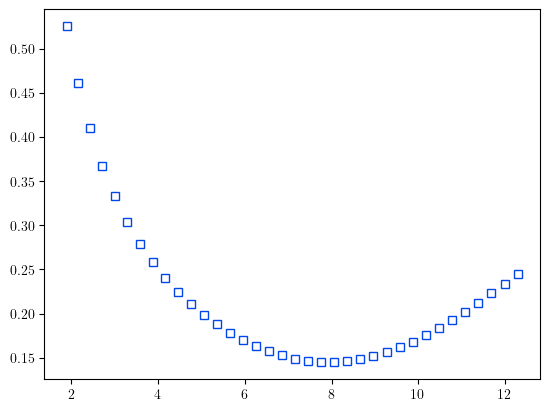

21
0.14504464910457796
7900.0


In [25]:
"""Load saved data """
"""In case the data is already saved from a previous run, load the data here, instead of running simulations again"""

# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/sigma_k_2_delta_kick_numerical_opt_gradient_descent.npy"
# Load the array
sigma_k_2_delta_kick_numerical_opt_gradient_descent = np.load(path_to_file)

plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_blue)
plt.show()
print(np.argmin(sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground))
print(np.min(sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground))
print(N_f[21])


In [42]:
N_f[21]

7900.0

In [ ]:

"""ignore this if there's already saved data from before which I want to plot"""

"""Trying to search the entire parameter space here to find the minimum"""

"""Checking the scheme for one single value of free expansion time for now """

"""This is for Fig 5 of the paper"""


N_delta_2 = 2
N_f_index = np.argmin(sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground)
# choose N_f_index to be np.argmin(sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground) for Fig 5 of the paper.
# This is time t_2 in the paper.  
# N_f_index = 21 

sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground

initial_kappa = kappa_matrix_eqn_classical(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index) # This is the kick strength given by the classical inspired DKC scheme


N_kappa_factor = 491
# N_kappa_factor = 200

kappa_factor = np.linspace(0.1,5,N_kappa_factor)
sigma_k_2_delta_kick_numerical = np.zeros([N_kappa_factor,N_kappa_factor])

kappa_1_array = np.linspace(0.1*initial_kappa[0], 5*initial_kappa[0], N_kappa_factor)
kappa_2_array = np.linspace(0.1*initial_kappa[1], 5*initial_kappa[1], N_kappa_factor)

if(N_delta_2 == 2):
    for i in range(N_kappa_factor): # Let's take this loop to be for kappa_1, the kick strength of the attractive delta kick
        if i %4 ==0:
            print(i)
        for j in range(N_kappa_factor): # This loop is for kappa_2, the kick strength of the repulsive delta kick
            kappa = np.zeros(N_delta)
            kappa[0] = initial_kappa[0] * kappa_factor[i] 
            kappa[1] = initial_kappa[1] * kappa_factor[j]
            sigma_k_2_delta_kick_numerical[i,j] = calculate_sigma_k(kappa=kappa, sigma_array=sigma_array, N_f_index=N_f_index, N_delta=N_delta_2)

KAPPA_1, KAPPA_2 = np.meshgrid(kappa_1_array/initial_kappa[0],kappa_2_array/initial_kappa[1])



0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196


In [44]:
"""Save the array from above"""
"""ignore this if there's already saved data from before which I want to plot"""

filename = os.path.join(directory, "sigma_k_2_delta_kick_numerical.npy")
np.save(filename, sigma_k_2_delta_kick_numerical)

KAPPA_1, KAPPA_2 = np.meshgrid(kappa_1_array/initial_kappa[0],kappa_2_array/initial_kappa[1])

filename = os.path.join(directory, "KAPPA_1.npy")
np.save(filename, KAPPA_1)

filename = os.path.join(directory, "KAPPA_2.npy")
np.save(filename, KAPPA_2)

In [ ]:
"""Load saved data """
"""In case the data is already saved from a previous run, load the data here, instead of running simulations again"""

# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-19/sigma_k_2_delta_kick_numerical.npy"
# Load the array
sigma_k_2_delta_kick_numerical = np.load(path_to_file)


# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-19/KAPPA_1.npy"
# Load the array
KAPPA_1 = np.load(path_to_file)


# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-19/KAPPA_2.npy"
# Load the array
KAPPA_2 = np.load(path_to_file)


"""Change these below if the kappa arrays are defined for a different range or N_kappa_factor"""

N_kappa_factor = 491
kappa_factor = np.linspace(0.1,5,N_kappa_factor)
# sigma_k_2_delta_kick_numerical = np.zeros([N_kappa_factor,N_kappa_factor])

kappa_1_array = np.linspace(0.1*initial_kappa[0], 5*initial_kappa[0], N_kappa_factor)
kappa_2_array = np.linspace(0.1*initial_kappa[1], 5*initial_kappa[1], N_kappa_factor)


KeyboardInterrupt: 

In [46]:
fun_2_kicks = 1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)
print(np.max(fun_2_kicks))
print(np.argmax(fun_2_kicks))
index_min = np.unravel_index(np.argmax(fun_2_kicks), fun_2_kicks.shape)
print(index_min)
print(np.argmin(sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground))

N_f_index = np.argmin(sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground)

kappa_generalized_DKC = kappa_matrix_eqn_generalized_DKC(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index) 
kappa_classical = kappa_matrix_eqn_classical(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index) 

print(kappa_generalized_DKC)
print(kappa_classical)
kappa_n = np.array([kappa_1_array[index_min[0]],kappa_2_array[index_min[1]]])
print(kappa_n)

6.868026534761285
11863
(59, 63)
21
[107.42449976 -81.51742386]
[109.14577038 -82.82358351]
[ 169.47760326 -136.76296252]


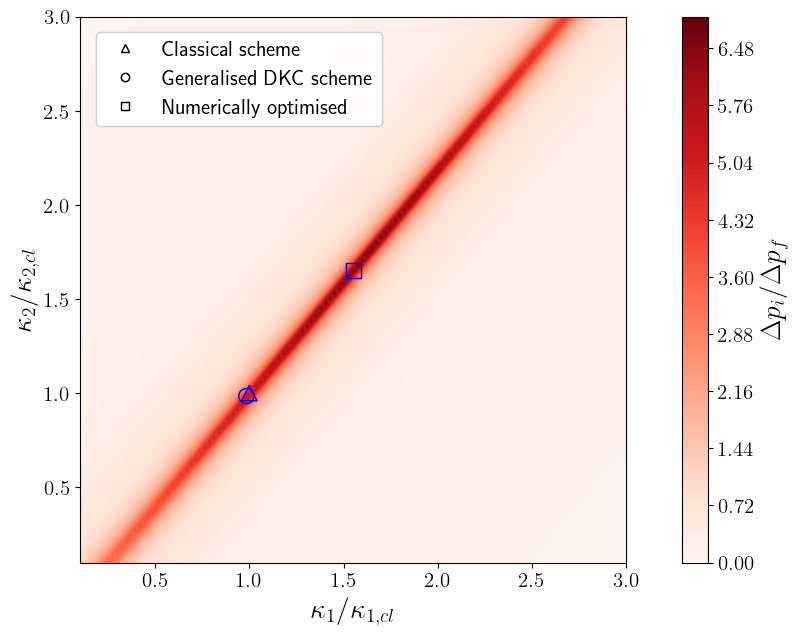

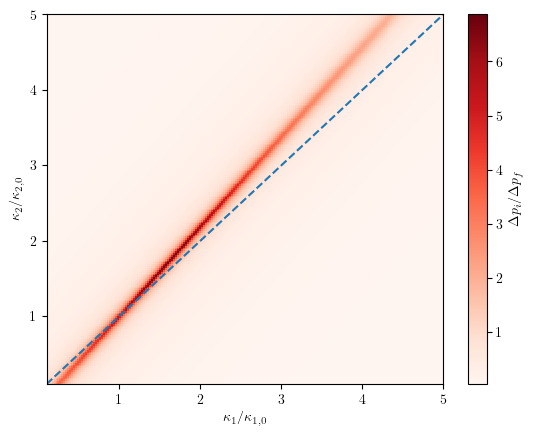

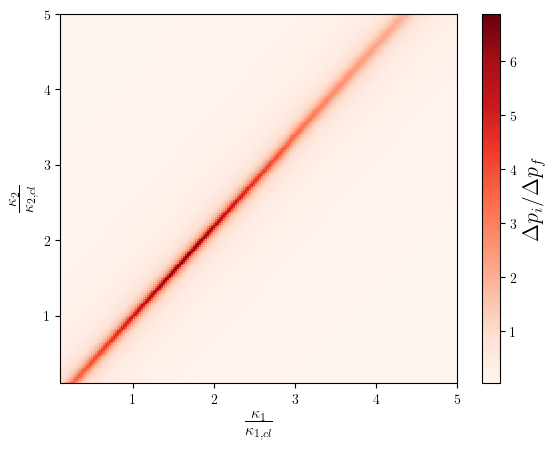

6.868026534761285


In [47]:
# KAPPA_1, KAPPA_2 = np.meshgrid(kappa_1_array/initial_kappa[0],kappa_2_array/initial_kappa[1])

fig,ax=plt.subplots(1,1, figsize=(8.5,7))
# cp = ax.contourf(KAPPA_1,KAPPA_2,np.transpose(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')
# plt.show()

cp = ax.contourf(KAPPA_1,KAPPA_2,np.transpose(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')
# cp = ax.contourf(KAPPA_1,KAPPA_2,np.transpose((sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')


plt.xlabel('$\kappa_1/\kappa_{1,cl}$',fontsize=20)
plt.ylabel('$\kappa_2/\kappa_{2,cl}$',fontsize=20)

# plt.xlabel(r'$\frac{\kappa_1}{\kappa_{1,cl}}$',fontsize=23)
# plt.ylabel(r'$\frac{\kappa_2}{\kappa_{2,cl}}$',fontsize=23)

plt.xlim(0.1,3)
plt.ylim(0.1,3)

# Create dummy plots for the legend
line1, = plt.plot([], [], '^',fillstyle = 'none', color = 'black', label='Classical scheme')
line2, = plt.plot([], [], 'o', fillstyle = 'none', color = 'black', label='Generalised DKC scheme')
line3, = plt.plot([], [], 's', fillstyle = 'none', color = 'black', label='Numerically optimised')

# Add the first legend
first_legend = plt.legend(handles=[line1, line2, line3], loc='upper left', bbox_to_anchor=(0.01, 0.99), prop={"size": 15})
plt.gca().add_artist(first_legend)


marker_size = 120
# data point corresponding to numerical optimum
ax.scatter(kappa_n[0]/initial_kappa[0], kappa_n[1]/initial_kappa[1], color='blue', s=marker_size, facecolors='none', edgecolors='blue', marker='s', label='minima', zorder=5)

# data point corresponding to classically inspired solution
ax.scatter(kappa_classical[0]/initial_kappa[0], kappa_classical[1]/initial_kappa[1], color='blue', s=marker_size, facecolors='none', edgecolors='blue', marker='^', label='minima', zorder=5)

# data point corresponding to generalised dkc inspired solution
ax.scatter(kappa_generalized_DKC[0]/initial_kappa[0], kappa_generalized_DKC[1]/initial_kappa[1], color='blue', s=marker_size, facecolors='none', edgecolors='blue', marker='o', label='minima', zorder=5)

# Adjust the layout to make room for the colorbar
fig.subplots_adjust(bottom=0.12, right=0.8, top=0.9)

cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])  # Add an axes for the colorbar on the right
cbar = fig.colorbar(cp, cax=cax)  
# Set the colorbar label
cbar.set_label(r'$\Delta p_i/\Delta p_f$', fontsize=20)

# # alternate option without .gcf
# plt.subplots_adjust(bottom=0.15)


# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal', adjustable='box')

# Increase the size of the numbers shown on x and y axis
ax.tick_params(axis='both', which='major', labelsize=15)

# Increase the size of the numbers on the colorbar
cbar.ax.tick_params(labelsize=15)


# Define filename
filename = '2 delta-kick performance vs kick strength: t_f = %5.1f, sigma_1 = %5.1f Delta x_i, sigma_2 = %5.1f Delta x_i.pdf'%tuple([N_f[N_f_index]*k, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
plt.savefig(save_path)


filename = '2 delta-kick performance vs kick strength: t_f = %5.1f, sigma_1 = %5.1f Delta x_i, sigma_2 = %5.1f Delta x_i.png'%tuple([N_f[N_f_index]*k, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path, dpi=600)








# # Define filename
# filename = '2 delta-kick performance vs kick strength: t_f = %5.1f, Delta x_f = %5.1f \Delta x_i, sigma_1 = %5.1f Delta x_i, sigma_2 = %5.1f Delta x_i.pdf'%tuple([N_f[N_f_index]*k, sigma_wavefunction_after_free_expansion_kappa_optimum_check/sigma_wavefunction_ground, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# # filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
# save_path = os.path.join(directory, filename)
# # Save the plot
# plt.savefig(save_path)

# filename = '2 delta-kick performance vs kick strength: t_f = %5.1f, Delta x_f = %5.1f \Delta x_i, sigma_1 = %5.1f Delta x_i, sigma_2 = %5.1f Delta x_i.png'%tuple([N_f[N_f_index]*k, sigma_wavefunction_after_free_expansion_kappa_optimum_check/sigma_wavefunction_ground, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# # filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
# save_path = os.path.join(directory, filename)
# # Save the plot
# plt.savefig(save_path, dpi=300)

# cp = ax.contourf(KAPPA_1,KAPPA_2,np.transpose(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')
plt.show()



mesh = plt.pcolormesh(KAPPA_1, KAPPA_2, np.transpose(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)), shading='auto', cmap='Reds')
plt.plot(kappa_1_array/initial_kappa[0], kappa_2_array/initial_kappa[1], '--')
plt.colorbar(mesh, label='$\Delta p_i/\Delta p_f$')
plt.xlabel('$\kappa_1/\kappa_{1,0}$')
plt.ylabel('$\kappa_2/\kappa_{2,0}$')
plt.xlim(0.1,5)
plt.ylim(0.1,5)
plt.show()



mesh = plt.pcolormesh(KAPPA_1, KAPPA_2, np.transpose(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)), shading='auto', cmap='Reds')
cbar = plt.colorbar(mesh, label='$\Delta p_i/\Delta p_f$')
cbar.ax.yaxis.label.set_size(16)
# plt.plot(kappa_1_array/initial_kappa[0], kappa_1_array/initial_kappa[0] , 'o', fillstyle = 'none', linewidth = 3, color = color_blue)
# plt.xlabel('$\kappa_1/\kappa_{1,0}$',fontsize=16)
# plt.ylabel('$\kappa_2/\kappa_{2,0}$',fontsize=16)

plt.xlabel(r'$\frac{\kappa_1}{\kappa_{1,cl}}$',fontsize=16)
plt.ylabel(r'$\frac{\kappa_2}{\kappa_{2,cl}}$',fontsize=16)
plt.xlim(0.1,5)
plt.ylim(0.1,5)

# Define filename
filename = 'Color plot of momentum width after 2 Gaussian delta-kicks (sigma = %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.png'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# filename = 'test.png'
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path, dpi=600)
plt.show()


fun = 1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)
print(np.max(fun))


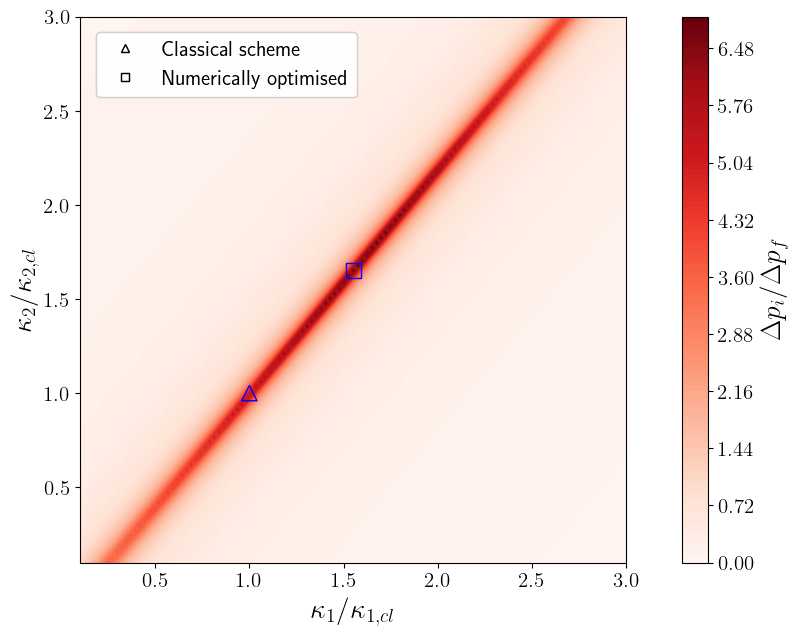

6.868026534761285


In [49]:
"""Plotting for the classically inspired scheme and numerically optimized (not the one obtained from generalized DKC approach for scale invariant dynamics)"""

KAPPA_1, KAPPA_2 = np.meshgrid(kappa_1_array/initial_kappa[0],kappa_2_array/initial_kappa[1])

fig,ax=plt.subplots(1,1, figsize=(8.5,7))
# cp = ax.contourf(KAPPA_1,KAPPA_2,np.transpose(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')
# plt.show()

cp = ax.contourf(KAPPA_1,KAPPA_2,np.transpose((1/(sigma_k_2_delta_kick_numerical/sigma_k_ground))),100, cmap = 'Reds')
# cp = ax.contourf(KAPPA_1,KAPPA_2,np.transpose((sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')


plt.xlabel('$\kappa_1/\kappa_{1,cl}$',fontsize=20)
plt.ylabel('$\kappa_2/\kappa_{2,cl}$',fontsize=20)

# plt.xlabel(r'$\frac{\kappa_1}{\kappa_{1,cl}}$',fontsize=23)
# plt.ylabel(r'$\frac{\kappa_2}{\kappa_{2,cl}}$',fontsize=23)

plt.xlim(0.1,3)
plt.ylim(0.1,3)

# Create dummy plots for the legend
line1, = plt.plot([], [], '^',fillstyle = 'none', color = 'black', label='Classical scheme')
# line2, = plt.plot([], [], 'o', fillstyle = 'none', color = 'black', label='Generalised DKC scheme')
line3, = plt.plot([], [], 's', fillstyle = 'none', color = 'black', label='Numerically optimised')

# Add the first legend
first_legend = plt.legend(handles=[line1, line3], loc='upper left', bbox_to_anchor=(0.01, 0.99), prop={"size": 15})
plt.gca().add_artist(first_legend)


marker_size = 120
# data point corresponding to numerical optimum
ax.scatter(kappa_n[0]/initial_kappa[0], kappa_n[1]/initial_kappa[1], color='blue', s=marker_size, facecolors='none', edgecolors='blue', marker='s', label='minima', zorder=5)

# data point corresponding to classically inspired solution
ax.scatter(kappa_classical[0]/initial_kappa[0], kappa_classical[1]/initial_kappa[1], color='blue', s=marker_size, facecolors='none', edgecolors='blue', marker='^', label='minima', zorder=5)

# # data point corresponding to generalised dkc inspired solution
# ax.scatter(kappa_generalized_DKC[0]/initial_kappa[0], kappa_generalized_DKC[1]/initial_kappa[1], color='blue', s=marker_size, facecolors='none', edgecolors='blue', marker='o', label='minima', zorder=5)

# Adjust the layout to make room for the colorbar
fig.subplots_adjust(bottom=0.12, right=0.8, top=0.9)

cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])  # Add an axes for the colorbar on the right
cbar = fig.colorbar(cp, cax=cax)  
# Set the colorbar label
cbar.set_label(r'$\Delta p_i/\Delta p_f$', fontsize=20)

# # alternate option without .gcf
# plt.subplots_adjust(bottom=0.15)


# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal', adjustable='box')

# Increase the size of the numbers shown on x and y axis
ax.tick_params(axis='both', which='major', labelsize=15)

# Increase the size of the numbers on the colorbar
cbar.ax.tick_params(labelsize=15)


# Define filename
filename = '(No generalized DKC) 2 delta-kick performance vs kick strength: t_f = %5.1f, sigma_1 = %5.1f Delta x_i, sigma_2 = %5.1f Delta x_i.pdf'%tuple([N_f[N_f_index]*k, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path)


filename = '(No generalized DKC) 2 delta-kick performance vs kick strength: t_f = %5.1f, sigma_1 = %5.1f Delta x_i, sigma_2 = %5.1f Delta x_i.png'%tuple([N_f[N_f_index]*k, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path, dpi=600)




# # Define filename
# filename = '2 delta-kick performance vs kick strength: t_f = %5.1f, Delta x_f = %5.1f \Delta x_i, sigma_1 = %5.1f Delta x_i, sigma_2 = %5.1f Delta x_i.pdf'%tuple([N_f[N_f_index]*k, sigma_wavefunction_after_free_expansion_kappa_optimum_check/sigma_wavefunction_ground, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# # filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
# save_path = os.path.join(directory, filename)
# # Save the plot
# plt.savefig(save_path)

# filename = '2 delta-kick performance vs kick strength: t_f = %5.1f, Delta x_f = %5.1f \Delta x_i, sigma_1 = %5.1f Delta x_i, sigma_2 = %5.1f Delta x_i.png'%tuple([N_f[N_f_index]*k, sigma_wavefunction_after_free_expansion_kappa_optimum_check/sigma_wavefunction_ground, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
# # filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
# save_path = os.path.join(directory, filename)
# # Save the plot
# plt.savefig(save_path, dpi=300)

# cp = ax.contourf(KAPPA_1,KAPPA_2,np.transpose(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')
plt.show()


fun = 1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)
print(np.max(fun))


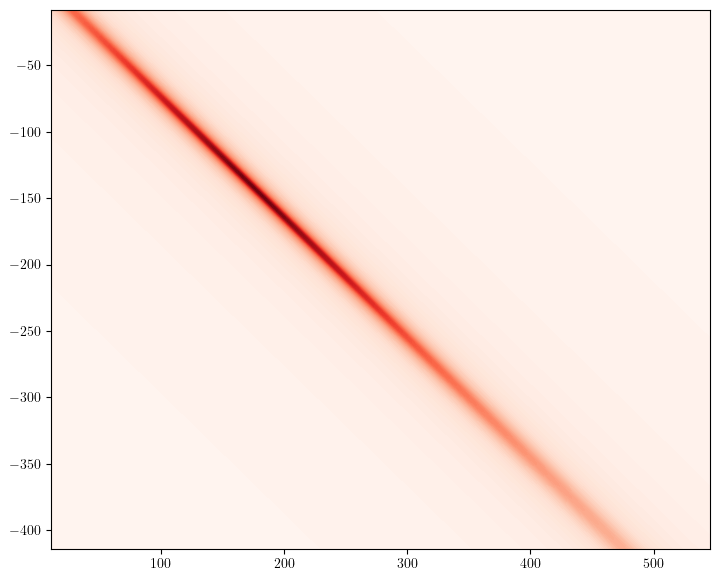

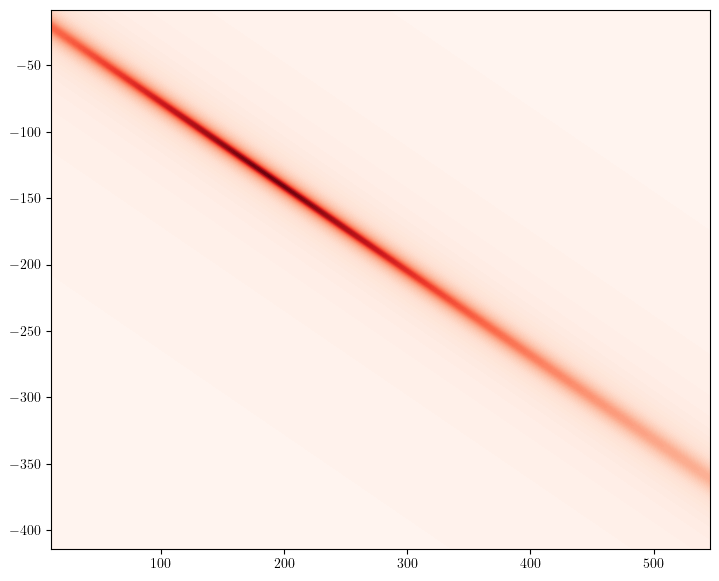

In [30]:
"""test whether i should take transpose of the data or not"""

"""Answer --- yes I should take transpose of the data because of the way I have calculated sigma_k_2_delta_kick_numerical"""

KAPPA_1_test, KAPPA_2_test = np.meshgrid(kappa_1_array,kappa_2_array)


fig,ax=plt.subplots(1,1, figsize=(8.5,7))
cp = ax.contourf(KAPPA_1_test,KAPPA_2_test,np.transpose(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')
plt.show()


fig,ax=plt.subplots(1,1, figsize=(8.5,7))
cp = ax.contourf(KAPPA_1_test,KAPPA_2_test,(1/(sigma_k_2_delta_kick_numerical/sigma_k_ground)),100, cmap = 'Reds')
plt.show()




In [50]:
print(kappa_matrix_eqn(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index)) # This is the kick strength given by the generalized DKC scheme
print(kappa_matrix_eqn_classical(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index)) 
print(kappa_matrix_eqn_generalized_DKC(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index))

[107.42449976 -81.51742386]
[109.14577038 -82.82358351]
[107.42449976 -81.51742386]


Matrix eqn kappa: [109.14577038 -82.82358351]
Matrix eqn parameters: sigma_k/sigma_k_i: 0.18820413374498934
Grad descent iteration num = 0,Converged after 21 iterations
Initial kappa: [109.14577038 -82.82358351]
Initial sigma_k/sigma_k_i: 0.18820413374498934
Optimized parameters: [109.56462829 -82.44290579]
Minimum sigma_k/sigma_k_i: 0.18234292654925274
Delta x_f/Delta x_i =  8.059336396543902


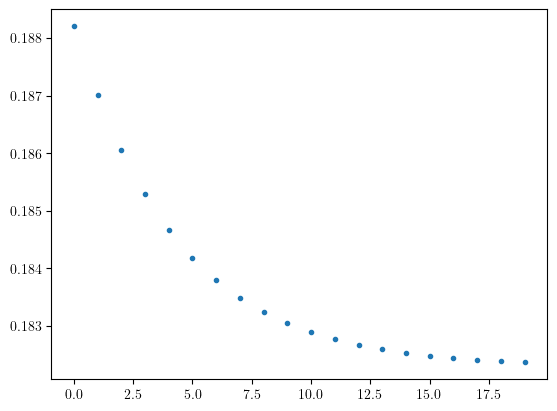

In [51]:
initial_kappa = kappa_matrix_eqn_classical(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index) 

print(f"Matrix eqn kappa: {initial_kappa}")
print(f"Matrix eqn parameters: sigma_k/sigma_k_i: {calculate_sigma_k(initial_kappa,sigma_array, N_f_index, N_delta_2)/sigma_k_ground}")

optimized_kappa, sigma_k_iterations, convergence_iteration = gradient_descent(calculate_sigma_k, initial_kappa, N_delta_2, learning_rate, num_iterations, tolerance)
print(f"Initial kappa: {initial_kappa}")
print(f"Initial sigma_k/sigma_k_i: {calculate_sigma_k(initial_kappa,sigma_array, N_f_index, N_delta_2)/sigma_k_ground}")
# print(f"Bounds for kappa: {bounds}")
print(f"Optimized parameters: {optimized_kappa}")
print(f"Minimum sigma_k/sigma_k_i: {calculate_sigma_k(optimized_kappa,sigma_array, N_f_index, N_delta_2)/sigma_k_ground}")


psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5))
print("Delta x_f/Delta x_i = ",np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2)))/sigma_wavefunction_ground) # spread of the wave packet just before delta kick (after free expansion)

plt.plot(range(convergence_iteration), sigma_k_iterations[0:convergence_iteration]/sigma_k_ground,'.')
plt.show()

In [ ]:
""" Optimizing 2 DKC case now but for all values of free expansion times"""
""" Numerical optimization by searching the entire parameter space"""
""" Note that I found out this approach doesn't work well enough. It's unable to fully optimize and search the entire parameter space.
    My approach of using gradient descent around a region where I know things will work does better than this """

"""Do not use this approach"""

# N_delta_2 = 2

# sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
# sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
# for i in range(N_delta):
#     if i>0:
#         sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
# sigma_array = sigma_array*sigma_wavefunction_ground


# N_kappa_factor = 80
# kappa_factor = np.linspace(0.1,5,N_kappa_factor)
# sigma_k_2_delta_kick_numerical = np.zeros([n_Nf,N_kappa_factor,N_kappa_factor])
# sigma_k_2_delta_kick_numerical_opt = np.zeros(n_Nf)

# for N_f_index in range(n_Nf): 
#     print("N_f = ", N_f[N_f_index])
#     initial_kappa = kappa_matrix_eqn_classical(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index) # This is the kick strength given by the generalized DKC scheme
#     kappa_1_array = np.linspace(0.1*initial_kappa[0], 5*initial_kappa[0], N_kappa_factor)
#     kappa_2_array = np.linspace(0.1*initial_kappa[1], 5*initial_kappa[1], N_kappa_factor)
#     sigma_k_2_delta_kick_numerical_opt[N_f_index] = calculate_sigma_k(initial_kappa,sigma_array,N_f_index,N_delta_2)
#     for i in range(N_kappa_factor): # Let's take this loop to be for kappa_1, the kick strength of the attractive delta kick
#         for j in range(N_kappa_factor): # This loop is for kappa_2, the kick strength of the repulsive delta kick
#             kappa = np.zeros(N_delta)
#             kappa[0] = initial_kappa[0] * kappa_factor[i] 
#             kappa[1] = initial_kappa[1] * kappa_factor[j]
#             sigma_k_2_delta_kick_numerical[N_f_index,i,j] = calculate_sigma_k(kappa=kappa, sigma_array=sigma_array, N_f_index=N_f_index, N_delta=N_delta_2)
#             if (sigma_k_2_delta_kick_numerical_opt[N_f_index] > sigma_k_2_delta_kick_numerical[N_f_index,i,j]):
#                 sigma_k_2_delta_kick_numerical_opt[N_f_index] =  sigma_k_2_delta_kick_numerical[N_f_index,i,j]


N_f =  1600.0
N_f =  1800.0
N_f =  2000.0
N_f =  2200.0
N_f =  2400.0
N_f =  2600.0
N_f =  2800.0
N_f =  3000.0
N_f =  3200.0
N_f =  3400.0
N_f =  3600.0
N_f =  3800.0
N_f =  4000.0
N_f =  4200.0
N_f =  4400.0
N_f =  4600.0
N_f =  4800.0
N_f =  5000.0
N_f =  5200.0
N_f =  5400.0
N_f =  5600.0
N_f =  5800.0
N_f =  6000.0
N_f =  6200.0
N_f =  6400.0
N_f =  6600.0
N_f =  6800.0
N_f =  7000.0
N_f =  7200.0
N_f =  7400.0
N_f =  7600.0
N_f =  7800.0
N_f =  8000.0
N_f =  8200.0
N_f =  8400.0
N_f =  8600.0
N_f =  8800.0
N_f =  9000.0
N_f =  9200.0
N_f =  9400.0
N_f =  9600.0
N_f =  9800.0
N_f =  10000.0
N_f =  10200.0
N_f =  10400.0
N_f =  10600.0
N_f =  10800.0
N_f =  11000.0
N_f =  11200.0
N_f =  11400.0
N_f =  11600.0
N_f =  11800.0
N_f =  12000.0


[0.37376978 0.34245405 0.31523869 0.29155282 0.2709684  0.25296307
 0.23696984 0.2225593  0.21008945 0.19923845 0.18951572 0.1800312
 0.17136605 0.16359635 0.156591   0.15010068 0.14415013 0.13869072
 0.13368712 0.12911578 0.12496375 0.12122756 0.11791208 0.1150293
 0.11259688 0.11063637 0.10917128 0.10822479 0.10781757 0.10671998
 0.10563782 0.10497112 0.10474908 0.10499712 0.10573506 0.10697564
 0.10872364 0.11097563 0.11372034 0.11693961 0.120609   0.12321632
 0.12624779 0.12968752 0.13351542 0.13770822 0.14224044 0.14708528
 0.15221544 0.15730761 0.16194356 0.16685633 0.17201984]


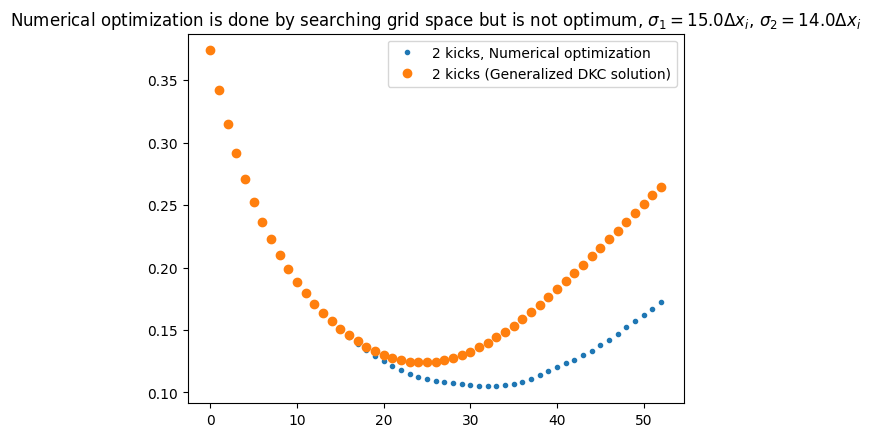

In [ ]:
# print(sigma_k_2_delta_kick_numerical_opt)
# plt.plot(sigma_k_2_delta_kick_numerical_opt,'.', label = '2 kicks, Numerical optimization')
# plt.plot(sigma_k_2_delta_kick, 'o',linewidth = 3, label = '2 kicks (Generalized DKC solution)')
# plt.title('Numerical optimization is done by searching grid space but is not optimum, $\sigma_1 = %5.1f \Delta x_i$, $\sigma_2 = %5.1f \Delta x_i$'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground]))
# plt.legend()
# plt.show()

In [ ]:
""" Using gradient descent for optimisation of values of kappa"""
"""  So here i do numerical optimisation, but i choose values which are some factor of the value given by generalized DKC matrix equation. 
This is because I know that the matrix equation parameters multiplied by some constant factor can do better than others. So I choose them as
the initial guess for the gradient descent."""

N_delta_2 = 2 # number of delta kicks
N_f_index = 10

sigma_array = np.zeros(N_delta_2) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta_2):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground

N_initial_kappa_factor = 40
initial_kappa_factor = np.linspace(0.1,4,N_initial_kappa_factor)

# Hyperparameters
learning_rate = 5
num_iterations = 300
tolerance = 5e-5

print(f"Matrix eqn kappa: {kappa_matrix_eqn(sigma_array, N_delta_2, N_f_index)}")
print(f"Matrix eqn parameters: sigma_k/sigma_k_i: {calculate_sigma_k(kappa_matrix_eqn(sigma_array, N_delta_2, N_f_index),sigma_array, N_f_index, N_delta_2)/sigma_k_ground}")

sigma_k_iterations_array = np.zeros([N_initial_kappa_factor, num_iterations])
optimized_kappa = np.zeros([N_initial_kappa_factor, N_delta_2])
convergence_iteration = np.zeros(N_initial_kappa_factor)

for i in range(N_initial_kappa_factor):
    print(i, end = ', ')
    initial_kappa = initial_kappa_factor[i] * kappa_matrix_eqn(sigma_array, N_delta_2, N_f_index)
    # Perform gradient descent
    optimized_kappa[i,:], sigma_k_iterations_array[i,:], convergence_iteration[i] = gradient_descent(calculate_sigma_k, initial_kappa, N_delta=N_delta_2 , learning_rate=learning_rate, num_iterations=num_iterations, tolerance=tolerance)
    # print(f"Initial kappa: {initial_kappa}")
    # print(f"Initial sigma_k/sigma_k_i: {calculate_sigma_k(initial_kappa,sigma_array, N_f_index, N_delta)/sigma_k_ground}")
    # # print(f"Bounds for kappa: {bounds}")
    # print(f"Optimized parameters: {optimized_kappa[i,:]}")
    # print(f"Minimum sigma_k/sigma_k_i: {calculate_sigma_k(optimized_kappa[i,:],sigma_array, N_f_index, N_delta)/sigma_k_ground}")
    print()



psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5))
print("Delta x_f/Delta x_i = ",np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2)))/sigma_wavefunction_ground) # spread of the wave packet just before delta kick (after free expansion)

# plt.plot(range(convergence_iteration), sigma_k_iterations[0:convergence_iteration]/sigma_k_ground,'.')
# plt.show()

Matrix eqn kappa: [ 387.52880271 -294.07025155]
Matrix eqn parameters: sigma_k/sigma_k_i: 0.5253871733027582
0, Grad descent iteration num = 0,50,100,150,200,250,
1, Grad descent iteration num = 0,50,100,150,200,250,
2, Grad descent iteration num = 0,50,100,150,200,250,
3, Grad descent iteration num = 0,50,100,150,200,250,
4, Grad descent iteration num = 0,50,100,150,200,250,
5, Grad descent iteration num = 0,50,100,150,200,250,
6, Grad descent iteration num = 0,50,100,150,200,Converged after 250 iterations

7, Grad descent iteration num = 0,50,100,Converged after 150 iterations

8, Grad descent iteration num = 0,Converged after 1 iterations

9, Grad descent iteration num = 0,Converged after 1 iterations

10, Grad descent iteration num = 0,Converged after 1 iterations

11, Grad descent iteration num = 0,50,100,Converged after 132 iterations

12, Grad descent iteration num = 0,50,100,150,200,Converged after 237 iterations

13, Grad descent iteration num = 0,50,100,150,200,250,
14, Grad 

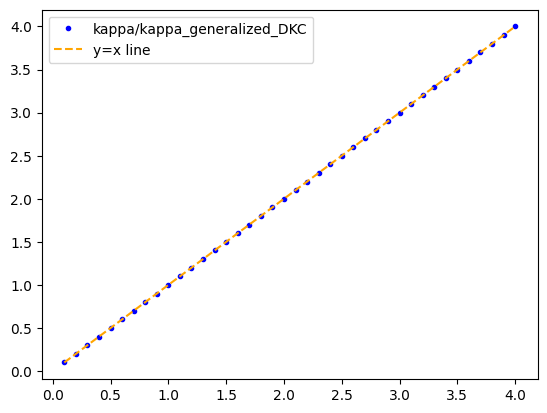

In [81]:
# N_initial_kappa_factor = 40
# initial_kappa_factor = np.linspace(0.1,4,N_initial_kappa_factor)
# kappa = kappa_matrix_eqn(sigma_array, N_delta_2, N_f_index=0)

# for i in range(N_initial_kappa_factor):
#     initial_kappa = initial_kappa_factor[i] * kappa
#     if i ==0:
#         plt.plot(initial_kappa[0]/kappa[0], initial_kappa[1]/kappa[1],'.', color = 'b',label = 'kappa/kappa_generalized_DKC')
#     else:
#         plt.plot(initial_kappa[0]/kappa[0], initial_kappa[1]/kappa[1],'.', color = 'b')
# plt.plot(initial_kappa_factor, initial_kappa_factor, '--', color = 'orange', label = 'y=x line')
# plt.legend()
# plt.show()

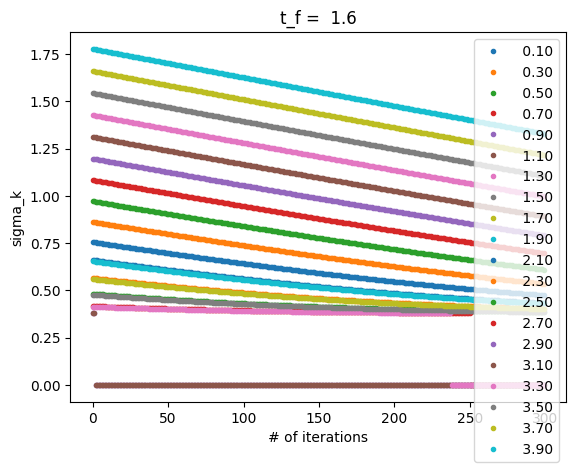

Minimum non-zero element: 0.3737797167382996
Index of the minimum non-zero element: (9, 1)


In [39]:
"""This is plotting the sigma_k for different kappa_factors and gradient descent implemented for each of those"""

for i in range(0,N_initial_kappa_factor,2):
    # plt.plot(range(int(convergence_iteration[i])), sigma_k_iterations_array[i],'.')
    plt.plot(range(num_iterations), sigma_k_iterations_array[i],'.',label = '%5.2f'%tuple([initial_kappa_factor[i]]))
    # plt.show()

plt.xlabel("# of iterations")
plt.ylabel("sigma_k")
plt.title(f"t_f =  {N_f[N_f_index]*k}")
plt.legend()
plt.show()
# Create a mask to exclude zeros
mask = np.ma.masked_equal(sigma_k_iterations_array, 0)

# Find the minimum non-zero element
min_value = np.min(mask)

# Get the index of the minimum non-zero element
index = np.unravel_index(np.argmin(mask), sigma_k_iterations_array.shape)

print("Minimum non-zero element:", min_value)
print("Index of the minimum non-zero element:", index)

In [25]:
"""Same as above, except that here I do it for the entire array of free expansion times """

""" Using gradient descent for optimisation of values of kappa"""
"""  So here i do numerical optimisation, but i choose values which are some factor of the value given by my matrix equation. 
This is because I know that the matrix equation parameters multiplied by some constant factor can do better than others """


N_delta_2 = 2 # number of delta kicks

N_initial_kappa_factor = 30
initial_kappa_factor = np.linspace(0.1,3,N_initial_kappa_factor)

sigma_array = np.zeros(N_delta_2) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta_2):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


# Hyperparameters
learning_rate = 5
num_iterations = 600
tolerance = 1e-5

sigma_k_iterations_array = np.zeros([n_Nf, N_initial_kappa_factor, num_iterations])
optimized_kappa = np.zeros([n_Nf, N_initial_kappa_factor, N_delta_2])
convergence_iteration = np.zeros([n_Nf, N_initial_kappa_factor])

for N_f_index in range(n_Nf):    
    print(f"Matrix eqn kappa: {kappa_matrix_eqn(sigma_array, N_delta_2, N_f_index)}")
    print(f"Matrix eqn parameters: sigma_k/sigma_k_i: {calculate_sigma_k(kappa_matrix_eqn(sigma_array, N_delta_2, N_f_index),sigma_array, N_f_index, N_delta_2)/sigma_k_ground}")
    print("N_f = ", N_f[N_f_index])
    for i in range(N_initial_kappa_factor):
        print(i, end = ', ')
        initial_kappa = initial_kappa_factor[i] * kappa_matrix_eqn(sigma_array, N_delta=N_delta_2, N_f_index=N_f_index)
        # Perform gradient descent
        optimized_kappa[N_f_index,i,:], sigma_k_iterations_array[N_f_index,i,:], convergence_iteration[N_f_index,i] = gradient_descent(calculate_sigma_k, initial_kappa, N_delta=N_delta_2 , learning_rate=learning_rate, num_iterations=num_iterations, tolerance=tolerance)
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5))
    print("Delta x_f/Delta x_i = ",np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2)))/sigma_wavefunction_ground) # spread of the wave packet just before delta kick (after free expansion)
    print("______________________________________________")


Matrix eqn kappa: [15.83114656 -6.48443763]
Matrix eqn parameters: sigma_k/sigma_k_i: 0.5527236521307707
N_f =  1500.0
0, Grad descent iteration num = 0,Converged after 20 iterations
1, Grad descent iteration num = 0,Converged after 18 iterations
2, Grad descent iteration num = 0,Converged after 17 iterations
3, Grad descent iteration num = 0,Converged after 16 iterations
4, Grad descent iteration num = 0,Converged after 15 iterations
5, Grad descent iteration num = 0,Converged after 14 iterations
6, Grad descent iteration num = 0,Converged after 13 iterations
7, Grad descent iteration num = 0,Converged after 12 iterations
8, Grad descent iteration num = 0,Converged after 10 iterations
9, Grad descent iteration num = 0,Converged after 6 iterations
10, Grad descent iteration num = 0,Converged after 8 iterations
11, Grad descent iteration num = 0,Converged after 11 iterations
12, Grad descent iteration num = 0,Converged after 12 iterations
13, Grad descent iteration num = 0,Converged aft

In [33]:
print(optimized_kappa[0])
print(sigma_k_iterations_array[0,0])

[[  3.65361082   2.13139525]
 [  5.00754514   1.18547287]
 [  6.36849326   0.23808839]
 [  7.72988308  -0.70960909]
 [  9.09179757  -1.65755861]
 [ 10.45436758  -2.60563565]
 [ 11.81780704  -3.55360335]
 [ 13.18247671  -4.50102311]
 [ 14.54446399  -5.44960209]
 [ 15.9055912   -6.39626555]
 [ 17.29433027  -7.32366023]
 [ 18.66351332  -8.27703441]
 [ 20.03185109  -9.22535949]
 [ 21.39830041 -10.17480476]
 [ 22.7634684  -11.12459685]
 [ 24.12770543 -12.07432132]
 [ 25.49121844 -13.02376039]
 [ 26.85866758 -13.97010505]
 [ 28.22115046 -14.91944183]
 [ 29.58318747 -15.86828574]
 [ 30.95045943 -16.81490518]
 [ 32.31177273 -17.76352588]
 [ 33.67275976 -18.71163293]
 [ 35.03343189 -19.65925802]
 [ 36.39379815 -20.60643462]
 [ 37.75386676 -21.55319599]
 [ 39.11364597 -22.49957408]
 [ 40.46002016 -23.44039901]
 [ 41.07934233 -23.87506331]
 [ 41.08008197 -23.87557744]]
[0.66468222 0.59471397 0.53587793 0.48965772 0.45626696 0.43423797
 0.42087599 0.41328805 0.40916647 0.40698618 0.40584866 0.4052

N_f =  1500.0, Minimum non-zero element: 0.3916561086460969,Index of the minimum non-zero element: (13, 13)._____________________________
N_f =  2000.0, Minimum non-zero element: 0.31707911390263444,Index of the minimum non-zero element: (14, 9)._____________________________


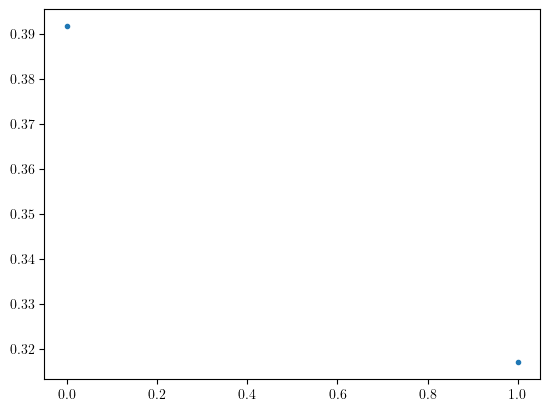

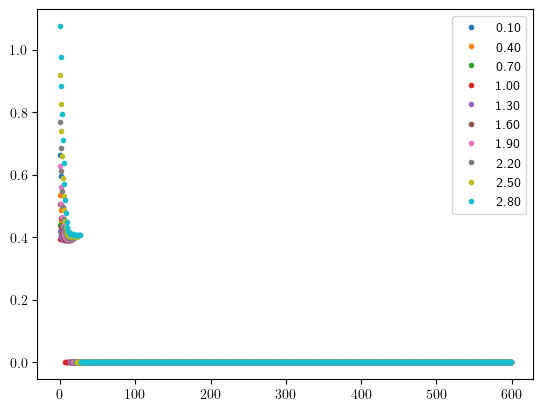

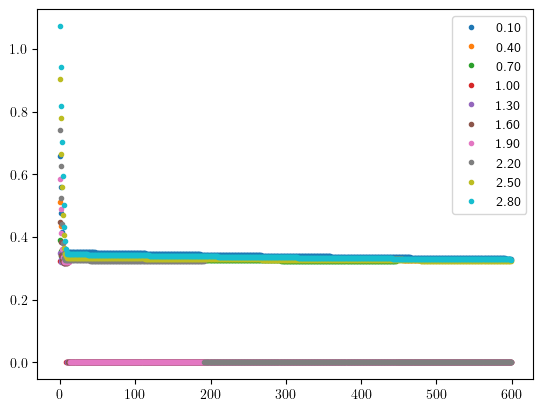

In [26]:
sigma_k_2_delta_kick_numerical_opt_gradient_descent = np.zeros(n_Nf)

for i in range(n_Nf):
    print("N_f = ", N_f[i], end=', ')
    # Create a mask to exclude zeros
    mask = np.ma.masked_equal(sigma_k_iterations_array[i,:,:], 0)
    # Find the minimum non-zero element
    min_value = np.min(mask)
    sigma_k_2_delta_kick_numerical_opt_gradient_descent[i] = np.min(mask)
    # Get the index of the minimum non-zero element
    index = np.unravel_index(np.argmin(mask), sigma_k_iterations_array[i,:,:].shape)
    print("Minimum non-zero element:", min_value, end=',')
    print("Index of the minimum non-zero element:", index, end='.')
    print("_____________________________")


plt.plot(sigma_k_2_delta_kick_numerical_opt_gradient_descent,'.')
plt.show()

for j in range(n_Nf):
    for i in range(0,N_initial_kappa_factor,3):
        # plt.plot(range(int(convergence_iteration[i])), sigma_k_iterations_array[i],'.')
        plt.plot(range(num_iterations), sigma_k_iterations_array[j,i],'.',label = '%5.2f'%tuple([initial_kappa_factor[i]]))
        # plt.show()
    plt.legend()
    plt.show()




In [35]:
"""Saving data for numerically optimized 2 Gaussian delta kicks """

"""2 Gaussian kicks"""

filename = os.path.join(directory, "sigma_k_2_delta_kick_numerical_opt_gradient_descent.npy")
np.save(filename, sigma_k_2_delta_kick_numerical_opt_gradient_descent)


filename = os.path.join(directory, "sigma_k_iterations_array.npy")
np.save(filename, sigma_k_iterations_array)


filename = os.path.join(directory, "optimized_kappa.npy")
np.save(filename, optimized_kappa)


filename = os.path.join(directory, "convergence_iteration.npy")
np.save(filename, convergence_iteration)



In [52]:
"""Now 2 Gaussian kick case --- scale invariance solution """

sigma_k_2_delta_kick_scale_inv = np.zeros(n_Nf)
ft_psi_after_2_delta_kick_scale_inv = np.zeros([n_Nf,N_x], dtype=np.complex128)

kappa = np.zeros(N_delta)
B = np.zeros(N_delta)
A = np.zeros([N_delta,N_delta])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground

for i in range(N_delta):
    for j in range(N_delta):
        A[i,j] = 1/(sigma_array[j]**(2*(i+1)))


"""Now store sigma_k values for 2 delta kick case"""

for i in range(n_Nf):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    # B[0] = 1/N_f[i]/k
    B[0] = omega_dimensionless**2 * N_f[i] * k/(1 + (omega_dimensionless * N_f[i] * k)**2)
    A_inv = np.linalg.inv(A)
    kappa = np.matmul(A_inv,B) # kappa = A_inv*B
    psi_after_2_delta_kick_scale_inv = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
    for j in range(N_delta): # 2nd till N_th delta kick
        if j>0:
            psi_after_2_delta_kick_scale_inv = psi_after_2_delta_kick_scale_inv*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
    ft_psi_after_2_delta_kick_scale_inv[i,:] = (2/np.size(K))*(fft.fft(psi_after_2_delta_kick_scale_inv)) # FFT of psi after delta kick
    ft_psi_after_2_delta_kick_scale_inv[i,:] = np.concatenate((ft_psi_after_2_delta_kick_scale_inv[i,N_x//2:], ft_psi_after_2_delta_kick_scale_inv[i,:N_x//2]))    
    integral = area_total(K,np.abs(ft_psi_after_2_delta_kick_scale_inv[i,:])**2) # to get normalisation constant
    ft_psi_after_2_delta_kick_scale_inv[i,:] = ft_psi_after_2_delta_kick_scale_inv[i,:]/np.sqrt(integral)
    sigma_k_2_delta_kick_scale_inv[i] = np.real(np.sqrt(expectation_value(K,ft_psi_after_2_delta_kick_scale_inv[i,:],K**2)-(expectation_value(K,ft_psi_after_2_delta_kick_scale_inv[i,:],K)**2))) # spread in k space
    print(kappa)
print("__________________________________________")
print(sigma_k_2_delta_kick_scale_inv)

[ 387.52880271 -294.07025155]
[ 355.37484023 -269.67071333]
[ 324.82080296 -246.48525366]
[ 297.32813311 -225.62286542]
[ 273.11136209 -207.24634244]
[ 251.93024663 -191.17337984]
[ 233.41205354 -177.12113479]
[ 217.17705026 -164.80145309]
[ 202.88272612 -153.95442581]
[ 190.23508568 -144.35695904]
[ 178.98724259 -135.82170689]
[ 168.93373737 -128.1927596 ]
[ 159.90400312 -121.34068511]
[ 151.75627914 -115.15791051]
[ 144.37237872 -109.55475163]
[ 137.65335448 -104.45612377]
[131.51597118 -99.79886516]
[125.88985893 -95.52957671]
[120.71522204 -91.60288336]
[115.94099425 -87.98003428]
[111.52335013 -84.62777321]
[107.42449976 -81.51742386]
[103.61170876 -78.62414624]
[100.05649804 -75.92632945]
[ 96.73398721 -73.40509339]
[ 93.62235333 -71.04387804]
[ 90.70238259 -68.8281033 ]
[ 87.95709732 -66.74488594]
[ 85.37144416 -64.78280294]
[ 82.93203227 -62.93169288]
[ 80.6269126  -61.18248838]
[ 78.44539093 -59.52707433]
[ 76.37786906 -57.95816726]
[ 74.41570911 -56.46921247]
[ 72.55111748 -5

In [53]:
"""Now 2 Gaussian kick case --- classically inspired solution """

N_delta = 2 # number of delta kicks

sigma_k_2_delta_kick = np.zeros(n_Nf)
ft_psi_after_2_delta_kick = np.zeros([n_Nf,N_x], dtype=np.complex128)

kappa = np.zeros(N_delta)
B = np.zeros(N_delta)
A = np.zeros([N_delta,N_delta])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground

for i in range(N_delta):
    for j in range(N_delta):
        A[i,j] = 1/(sigma_array[j]**(2*(i+1)))


"""Now store sigma_k values for 2 delta kick case"""

for i in range(n_Nf):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    B[0] = 1/N_f[i]/k
    # B[0] = omega_dimensionless**2 * N_f[i] * k/(1 + (omega_dimensionless * N_f[i] * k)**2)
    A_inv = np.linalg.inv(A)
    kappa = np.matmul(A_inv,B) # kappa = A_inv*B
    psi_after_2_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
    for j in range(N_delta): # 2nd till N_th delta kick
        if j>0:
            psi_after_2_delta_kick = psi_after_2_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
    ft_psi_after_2_delta_kick[i,:] = (2/np.size(K))*(fft.fft(psi_after_2_delta_kick)) # FFT of psi after delta kick
    ft_psi_after_2_delta_kick[i,:] = np.concatenate((ft_psi_after_2_delta_kick[i,N_x//2:], ft_psi_after_2_delta_kick[i,:N_x//2]))    
    integral = area_total(K,np.abs(ft_psi_after_2_delta_kick[i,:])**2) # to get normalisation constant
    ft_psi_after_2_delta_kick[i,:] = ft_psi_after_2_delta_kick[i,:]/np.sqrt(integral)
    sigma_k_2_delta_kick[i] = np.real(np.sqrt(expectation_value(K,ft_psi_after_2_delta_kick[i,:],K**2)-(expectation_value(K,ft_psi_after_2_delta_kick[i,:],K)**2))) # spread in k space
    print(kappa)
print("__________________________________________")
print(sigma_k_2_delta_kick)


[ 538.90724127 -408.94144357]
[ 453.81662423 -344.37174195]
[ 391.9325391  -297.41195896]
[ 344.90063441 -261.72252388]
[ 307.94699501 -233.6808249 ]
[ 278.14567291 -211.06655152]
[ 253.60340766 -192.44303227]
[ 233.0409692  -176.83954316]
[ 215.56289651 -163.57657743]
[ 200.52362466 -152.16425807]
[ 187.44599696 -142.24050211]
[ 175.96971143 -133.53189994]
[ 165.8176127  -125.82813648]
[ 156.77301564 -118.96478358]
[ 148.66406656 -112.81143271]
[ 141.35271902 -107.26332946]
[ 134.72681032 -102.23536089]
[128.69426657 -97.65765817]
[123.178798   -93.47232996]
[118.11665562 -89.63100133]
[113.45415606 -86.09293549]
[109.14577038 -82.82358351]
[105.15263244 -79.7934524 ]
[101.44136306 -76.97721291]
[ 97.98313478 -74.35298974]
[ 94.75292154 -71.90179228]
[ 91.72889213 -69.60705422]
[ 88.89191609 -67.45425873]
[ 86.2251586  -65.43063097]
[ 83.71374622 -63.52488444]
[ 81.34448925 -61.72701035]
[ 79.10565009 -60.02810181]
[ 76.98674875 -58.42020622]
[ 74.97839879 -56.89620084]
[ 73.07216831 

In [38]:
"""Saving data"""
""" Save data for 2 Gaussian kicks -- optimized using generalized DKC approach and using classically inspired scheme"""

# Classically inspired solution
filename = os.path.join(directory, "sigma_k_2_delta_kick.npy")
np.save(filename, sigma_k_2_delta_kick)


# generalized DKC inspired solution
filename = os.path.join(directory, "sigma_k_2_delta_kick_scale_inv.npy")
np.save(filename, sigma_k_2_delta_kick_scale_inv)






# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-02-13/3 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14,13)*delta x_i/sigma_wavefunction_after_free_expansion.npy"
# # Load the array
# sigma_wavefunction_after_free_expansion = np.load(path_to_file)


# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-02-13/3 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14,13)*delta x_i/sigma_k_3_delta_kick_numerical_opt_gradient_descent.npy"
# # Load the array
# sigma_k_3_delta_kick_numerical_opt_gradient_descent = np.load(path_to_file)


# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-02-13/2 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14)*delta x_i/sigma_k_2_delta_kick_numerical_opt_gradient_descent.npy"
# # Load the array
# sigma_k_2_delta_kick_numerical_opt_gradient_descent = np.load(path_to_file)



In [54]:
"""Load saved data """
"""In case the data is already saved from a previous run, load the data here, instead of running simulations again"""

# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/sigma_k_2_delta_kick_numerical_opt_gradient_descent.npy"
# Load the array
sigma_k_2_delta_kick_numerical_opt_gradient_descent = np.load(path_to_file)


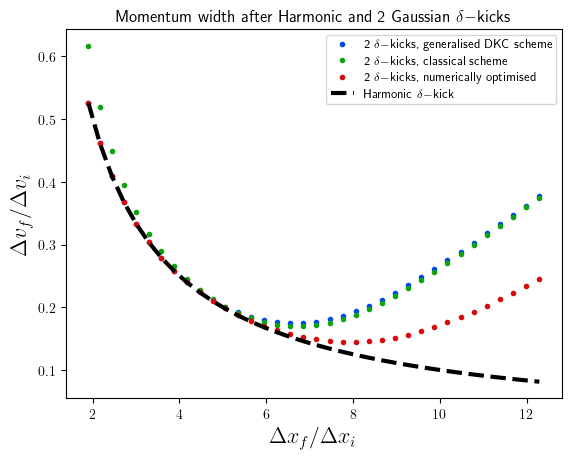

In [55]:
"""Plot final momentum after harmonic kick or 2 Gaussian kicks (all 3 schemes for optimisation)"""

# plt.plot(sigma_wavefunction_after_free_expansion[0:N_plot_display]/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv[0:N_plot_display]/sigma_k_ground , '+',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, generalised DKC scheme')
# plt.plot(sigma_wavefunction_after_free_expansion[0:N_plot_display]/sigma_wavefunction_ground, sigma_k_2_delta_kick[0:N_plot_display]/sigma_k_ground , '-',linewidth = 3, color = color_green, label = '2 $\delta-$kicks, classical scheme')
# plt.plot(sigma_wavefunction_after_free_expansion[0:N_plot_display]/sigma_wavefunction_ground, sigma_k_harmonic[0:N_plot_display]/sigma_k_ground, '--', linewidth = 3, color = 'black', label = 'Harmonic $\delta-$kick')


plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , '.',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, generalised DKC scheme')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '.',linewidth = 3, color = color_green, label = '2 $\delta-$kicks, classical scheme')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , '.',linewidth = 3, color = color_red, label = '2 $\delta-$kicks, numerically optimised')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black', label = 'Harmonic $\delta-$kick')


plt.legend(loc = 'upper right',prop={"size":8.5})
# plt.xlim(0,15)

plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
plt.title('Momentum width after Harmonic and 2 Gaussian $\delta-$kicks')


# Define filename
filename = 'Momentum width comparison after Harmonic and 2 Gaussian delta-kicks (sigma = %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path)

# plt.savefig('Momentum width after Harmonic, 1 and 2 Gaussian delta-kicks (sigma = %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground]))
plt.show()


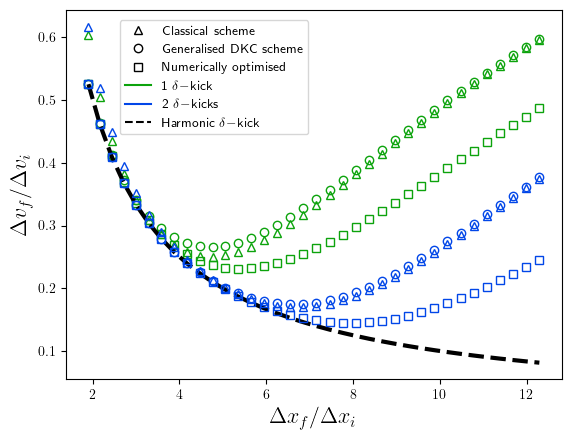

In [56]:
"""Plot -- harmonic kick, 1 gaussian kick and 2 gaussian kicks"""

# # 1 kick
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground , '^',fillstyle = 'none', linewidth = 3, color = color_green, label = 'Gaussian kick, classical scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'o', fillstyle = 'none', linewidth = 3, color = color_green, label = 'Gaussian kick, generalised DKC scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,'s', fillstyle = 'none' , linewidth = 3, color = color_green, label = 'Gaussian kick, numerically optimised')

# # harmonic kick
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black', label = 'Harmonic kick')

# # 2 kicks
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, classical scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, generalised DKC scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, numerically optimised')



# 1 kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground , '^',fillstyle = 'none', linewidth = 3, color = color_green)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'o', fillstyle = 'none', linewidth = 3, color = color_green)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,'s', fillstyle = 'none' , linewidth = 3, color = color_green)

# harmonic kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black')

# 2 kicks
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_blue)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_blue)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_blue)

# Create dummy plots for the legend
line1, = plt.plot([], [], '^',fillstyle = 'none', color = 'black', label='Classical scheme')
line2, = plt.plot([], [], 'o', fillstyle = 'none', color = 'black', label='Generalised DKC scheme')
line3, = plt.plot([], [], 's', fillstyle = 'none', color = 'black', label='Numerically optimised')
line4, = plt.plot([], [], '-', fillstyle = 'none', color = color_green, label='1 $\delta-$kick')
line5, = plt.plot([], [], '-', fillstyle = 'none', color = color_blue, label='2 $\delta-$kicks')
# line6, = plt.plot([], [], '-', fillstyle = 'none', color = color_red, label='3 $\delta-$kicks')
line6, = plt.plot([], [], '--', fillstyle = 'none', color = 'black', label='Harmonic $\delta-$kick')

# plt.legend(loc = 'upper center',prop={"size":8})
plt.legend(loc='upper left', bbox_to_anchor=(0.095, 0.99), prop={"size": 9.5})

plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
# plt.title('Momentum width after a Gaussian and a Harmonic $\delta-$kick')

# Define the directory and filename
filename = 'Momentum width comparison after Harmonic, 1 and 2 Gaussian delta-kicks (sigma = %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)

# Save the plot
# plt.savefig(save_path)

plt.show()

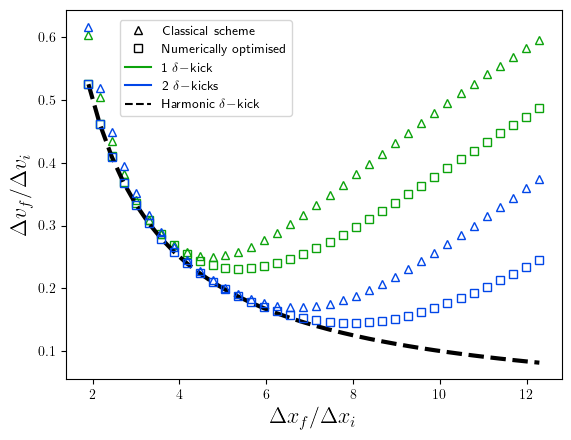

In [57]:
"""Plotting for the classically inspired scheme and numerically optimized (not the one obtained from generalized DKC approach for scale invariant dynamics)"""

"""Plot -- harmonic kick, 1 gaussian kick and 2 gaussian kicks"""

# 1 kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground , '^',fillstyle = 'none', linewidth = 3, color = color_green)
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'o', fillstyle = 'none', linewidth = 3, color = color_green)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,'s', fillstyle = 'none' , linewidth = 3, color = color_green)

# harmonic kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black')

# 2 kicks
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_blue)
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_blue)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_blue)

# Create dummy plots for the legend
line1, = plt.plot([], [], '^',fillstyle = 'none', color = 'black', label='Classical scheme')
# line2, = plt.plot([], [], 'o', fillstyle = 'none', color = 'black', label='Generalised DKC scheme')
line3, = plt.plot([], [], 's', fillstyle = 'none', color = 'black', label='Numerically optimised')
line4, = plt.plot([], [], '-', fillstyle = 'none', color = color_green, label='1 $\delta-$kick')
line5, = plt.plot([], [], '-', fillstyle = 'none', color = color_blue, label='2 $\delta-$kicks')
# line6, = plt.plot([], [], '-', fillstyle = 'none', color = color_red, label='3 $\delta-$kicks')
line6, = plt.plot([], [], '--', fillstyle = 'none', color = 'black', label='Harmonic $\delta-$kick')

# plt.legend(loc = 'upper center',prop={"size":8})
plt.legend(loc='upper left', bbox_to_anchor=(0.095, 0.99), prop={"size": 9.5})

plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
# plt.title('Momentum width after a Gaussian and a Harmonic $\delta-$kick')

# Define the directory and filename
filename = '(No generalized DKC) Momentum width comparison after Harmonic, 1 and 2 Gaussian delta-kicks (sigma = %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)

# Save the plot
# plt.savefig(save_path)

plt.show()

In [ ]:
"""TEST"""
"""Ignore this if you are running a full simulation to get all the graphs in the paper"""

""" 3 Gaussian delta kicks"""

"""Doing the numerical optimisation with gradient descent for 3 kicks now"""

"""  So here i do numerical optimisation, but i choose values which are some factor of the value given by my matrix equation. 
This is because I know that the matrix equation parameters multiplied by some constant factor can do better than others """

"""Here for only one free expansion time"""

N_initial_kappa_factor = 30
initial_kappa_factor = np.linspace(0.1,3,N_initial_kappa_factor)

sigma_array = np.zeros(N_delta_3) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta_3):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


# Hyperparameters
learning_rate = 5
num_iterations = 600
tolerance = 1e-5

sigma_k_iterations_array_3_kicks_Nfindex = np.zeros([N_initial_kappa_factor, num_iterations])
optimized_kappa_3_kicks_Nfindex = np.zeros([N_initial_kappa_factor, N_delta_3])
convergence_iteration_3_kicks_Nfindex = np.zeros([N_initial_kappa_factor])

N_f_index = 0 

for i in range(N_initial_kappa_factor):
    print(i, end = ', ')
    initial_kappa = initial_kappa_factor[i] * kappa_matrix_eqn(sigma_array, N_delta_3, N_f_index)
    # Perform gradient descent
    optimized_kappa_3_kicks_Nfindex[i,:], sigma_k_iterations_array_3_kicks_Nfindex[i,:], convergence_iteration_3_kicks_Nfindex[i] = gradient_descent(calculate_sigma_k, initial_kappa, N_delta=N_delta_3 ,learning_rate=learning_rate, num_iterations=num_iterations, tolerance=tolerance)
print("______________________________________________")


0, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,450,500,Converged after 530 iterations
1, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,450,500,Converged after 501 iterations
2, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,450,Converged after 471 iterations
3, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,Converged after 438 iterations
4, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,Converged after 402 iterations
5, Grad descent iteration num = 0,50,100,150,200,250,300,350,Converged after 362 iterations
6, Grad descent iteration num = 0,50,100,150,200,250,300,Converged after 313 iterations
7, Grad descent iteration num = 0,50,100,150,200,Converged after 249 iterations
8, Grad descent iteration num = 0,50,100,Converged after 147 iterations
9, Grad descent iteration num = 0,Converged after 1 iterations
10, Grad descent iteration num = 0,50,100,Converged after 124 iterations
11, Grad descent iteration num =

In [ ]:
"""TEST"""
"""Ignore this if you are running a full simulation to get all the graphs in the paper"""

# Create a mask to exclude zeros
mask = np.ma.masked_equal(sigma_k_iterations_array_3_kicks_Nfindex[:,:], 0)
# Find the minimum non-zero element
min_value = np.min(mask)
sigma_k_3_delta_kick_numerical_opt_gradient_descent_Nfindex = np.min(mask)
# Get the index of the minimum non-zero element
index = np.unravel_index(np.argmin(mask), sigma_k_iterations_array_3_kicks_Nfindex[:,:].shape)
print("Minimum non-zero element:", min_value)
print("Index of the minimum non-zero element:", index)
print(optimized_kappa_3_kicks_Nfindex)
print("_____________________________")
print(optimized_kappa_3_kicks_Nfindex[9,:])
sigma_k_iterations_array_3_kicks_Nfindex

Minimum non-zero element: 0.39132451505563237
Index of the minimum non-zero element: (9, 1)
[[  171.08681914  -206.41618408    87.56418813]
 [  329.69054751  -427.11472921   158.63239134]
 [  488.29599733  -647.81131608   229.70284014]
 [  646.89830194  -868.51151008   300.76911064]
 [  805.5009077  -1089.21137243   371.83574366]
 [  964.10630038 -1309.90806439   442.90601504]
 [ 1122.70845822 -1530.60847624   513.97196369]
 [ 1281.3123126  -1751.30697346   585.04008529]
 [ 1439.91805152 -1972.00335427   656.11059457]
 [ 1598.95618576 -2192.20502928   727.75246479]
 [ 1758.18635746 -2412.18697164   799.64814581]
 [ 1916.79266684 -2632.88270894   870.71938439]
 [ 2075.39498452 -2853.58297012   941.7854607 ]
 [ 2233.99952536 -3074.28065964  1012.85454652]
 [ 2392.60122095 -3294.98158261  1083.91992804]
 [ 2551.2058719  -3515.67910938  1154.98925416]
 [ 2709.80953062 -3736.37775726  1226.05730537]
 [ 2868.41242248 -3957.07727022  1297.12437504]
 [ 3027.01683105 -4177.77504498  1368.193471

array([[0.66297825, 0.66130688, 0.65964005, ..., 0.        , 0.        ,
        0.        ],
       [0.61635501, 0.61482418, 0.61329852, ..., 0.        , 0.        ,
        0.        ],
       [0.57201645, 0.57065235, 0.56929401, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.12722019, 1.1249632 , 1.12270747, ..., 0.39818471, 0.39810493,
        0.39802613],
       [1.18270447, 1.1804191 , 1.17813483, ..., 0.40055182, 0.40044371,
        0.40033692],
       [1.23851133, 1.23620118, 1.233892  , ..., 0.40370681, 0.40356146,
        0.40341784]])

In [41]:
""" 3 Gaussian delta kicks"""

"""Doing the numerical optimisation with gradient descent for 3 kicks now"""

"""  So here i do numerical optimisation, but i choose values which are some factor of the value given by my matrix equation. 
This is because I know that the matrix equation parameters multiplied by some constant factor can do better than others """

""" i do this for the entire array of free expansion times """


N_initial_kappa_factor = 30
initial_kappa_factor = np.linspace(0.1,3,N_initial_kappa_factor)

sigma_array = np.zeros(N_delta_3) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta_3):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


# Hyperparameters
learning_rate = 5
num_iterations = 600
tolerance = 1e-5

sigma_k_iterations_array_3_kicks = np.zeros([n_Nf, N_initial_kappa_factor, num_iterations])
optimized_kappa_3_kicks = np.zeros([n_Nf, N_initial_kappa_factor, N_delta_3])
convergence_iteration_3_kicks = np.zeros([n_Nf, N_initial_kappa_factor])


for N_f_index in range(n_Nf):    
    print(f"Matrix eqn kappa: {kappa_matrix_eqn(sigma_array, N_delta_3, N_f_index)}", end=', ')
    print(f"Matrix eqn parameters: sigma_k/sigma_k_i: {calculate_sigma_k(kappa_matrix_eqn(sigma_array, N_delta_3, N_f_index),sigma_array, N_f_index, N_delta_3)/sigma_k_ground}")
    print("N_f = ", N_f[N_f_index])
    for i in range(N_initial_kappa_factor):
        print(i, end = ', ')
        initial_kappa = initial_kappa_factor[i] * kappa_matrix_eqn(sigma_array, N_delta_3, N_f_index)
        # Perform gradient descent
        optimized_kappa_3_kicks[N_f_index,i,:], sigma_k_iterations_array_3_kicks[N_f_index,i,:], convergence_iteration_3_kicks[N_f_index,i] = gradient_descent(calculate_sigma_k, initial_kappa, N_delta=N_delta_3 ,learning_rate=learning_rate, num_iterations=num_iterations, tolerance=tolerance)
        # print(f"Initial kappa: {initial_kappa}")
        # print(f"Initial sigma_k/sigma_k_i: {calculate_sigma_k(initial_kappa,sigma_array, N_f_index, N_delta_3)/sigma_k_ground}")
        # # print(f"Bounds for kappa: {bounds}")
        # print(f"Optimized parameters: {optimized_kappa[i,:]}")
        # print(f"Minimum sigma_k/sigma_k_i: {calculate_sigma_k(optimized_kappa[i,:],sigma_array, N_f_index, N_delta_3)/sigma_k_ground}")
    # psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index]*k*0.5))
    # print("Delta x_f/Delta x_i = ",np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2)))/sigma_wavefunction_ground) # spread of the wave packet just before delta kick (after free expansion)
    print("______________________________________________")

# plt.plot(range(convergence_iteration), sigma_k_iterations[0:convergence_iteration]/sigma_k_ground,'.')
# plt.show()

Matrix eqn kappa: [ 1557.03536803 -2134.73219647   708.67199514], Matrix eqn parameters: sigma_k/sigma_k_i: 0.5253815368104696
N_f =  1600.0
0, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,450,Converged after 485 iterations
1, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,450,Converged after 459 iterations
2, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,Converged after 431 iterations
3, Grad descent iteration num = 0,50,100,150,200,250,300,350,400,Converged after 401 iterations
4, Grad descent iteration num = 0,50,100,150,200,250,300,350,Converged after 369 iterations
5, Grad descent iteration num = 0,50,100,150,200,250,300,Converged after 333 iterations
6, Grad descent iteration num = 0,50,100,150,200,250,Converged after 290 iterations
7, Grad descent iteration num = 0,50,100,150,200,Converged after 233 iterations
8, Grad descent iteration num = 0,50,100,Converged after 142 iterations
9, Grad descent iteration num = 0,Converged after 1

In [42]:
"""Saving data for numerically optimized 3 Gaussian delta kicks """

"""3 Gaussian kicks"""


filename = os.path.join(directory, "sigma_k_iterations_array_3_kicks.npy")
np.save(filename, sigma_k_iterations_array_3_kicks)

filename = os.path.join(directory, "optimized_kappa_3_kicks.npy")
np.save(filename, optimized_kappa_3_kicks)

filename = os.path.join(directory, "convergence_iteration_3_kicks.npy")
np.save(filename, convergence_iteration_3_kicks)

In [58]:
"""Load saved data """
"""In case the data is already saved from a previous run, load the data here, instead of running simulations again"""

# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/sigma_k_iterations_array_3_kicks.npy"
# Load the array
sigma_k_iterations_array_3_kicks = np.load(path_to_file)

path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/optimized_kappa_3_kicks.npy"
optimized_kappa_3_kicks = np.load(path_to_file)

path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/convergence_iteration_3_kicks.npy"
convergence_iteration_3_kicks = np.load(path_to_file)

N_f =  1600.0, Minimum non-zero element: 0.3737755914230448,Index of the minimum non-zero element: (9, 1)._____________________________
N_f =  1900.0, Minimum non-zero element: 0.3282042228160439,Index of the minimum non-zero element: (9, 1)._____________________________
N_f =  2200.0, Minimum non-zero element: 0.291436750111881,Index of the minimum non-zero element: (9, 1)._____________________________
N_f =  2500.0, Minimum non-zero element: 0.2614593276290931,Index of the minimum non-zero element: (9, 1)._____________________________
N_f =  2800.0, Minimum non-zero element: 0.2367093228779323,Index of the minimum non-zero element: (9, 1)._____________________________
N_f =  3100.0, Minimum non-zero element: 0.21601567629892182,Index of the minimum non-zero element: (9, 1)._____________________________
N_f =  3400.0, Minimum non-zero element: 0.19850682233620862,Index of the minimum non-zero element: (9, 1)._____________________________
N_f =  3700.0, Minimum non-zero element: 0.1835

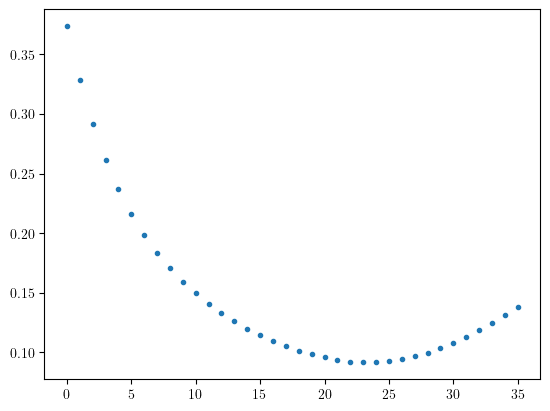

In [59]:
"""Finding the optimum 3 gaussian kick for each free expansion time"""

sigma_k_3_delta_kick_numerical_opt_gradient_descent = np.zeros(n_Nf)

for i in range(n_Nf):
    print("N_f = ", N_f[i], end=', ')
    # Create a mask to exclude zeros
    mask = np.ma.masked_equal(sigma_k_iterations_array_3_kicks[i,:,:], 0)
    # Find the minimum non-zero element
    min_value = np.min(mask)
    sigma_k_3_delta_kick_numerical_opt_gradient_descent[i] = np.min(mask)
    # Get the index of the minimum non-zero element
    index = np.unravel_index(np.argmin(mask), sigma_k_iterations_array_3_kicks[i,:,:].shape)
    print("Minimum non-zero element:", min_value, end=',')
    print("Index of the minimum non-zero element:", index, end='.')
    print("_____________________________")


plt.plot(sigma_k_3_delta_kick_numerical_opt_gradient_descent,'.')
plt.show()

# for j in range(n_Nf):
#     for i in range(0,N_initial_kappa_factor,3):
#         # plt.plot(range(int(convergence_iteration[i])), sigma_k_iterations_array[i],'.')
#         plt.plot(range(num_iterations), sigma_k_iterations_array_3_kicks[j,i],'.',label = '%5.2f'%tuple([initial_kappa_factor[i]]))
#         # plt.show()
#     plt.legend()
#     plt.show()


In [60]:
"""Now 3 Gaussian kick case - Generalised DKC inspired scheme """

N_delta = 3 # number of delta kicks

sigma_k_3_delta_kick_scale_inv = np.zeros(n_Nf)
ft_psi_after_3_delta_kick_scale_inv = np.zeros([n_Nf,N_x], dtype=np.complex128)

kappa = np.zeros(N_delta)
B = np.zeros(N_delta)
A = np.zeros([N_delta,N_delta])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground

for i in range(N_delta):
    for j in range(N_delta):
        A[i,j] = 1/(sigma_array[j]**(2*(i+1)))


"""Now store sigma_k values for 3 delta kick case"""

for i in range(n_Nf):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    # B[0] = 1/N_f[i]/k
    B[0] = omega_dimensionless**2 * N_f[i] * k/(1 + (omega_dimensionless * N_f[i] * k)**2)
    A_inv = np.linalg.inv(A)
    kappa = np.matmul(A_inv,B) # kappa = A_inv*B
    psi_after_3_delta_kick_scale_inv = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
    for j in range(N_delta): # 2nd till N_th delta kick
        if j>0:
            psi_after_3_delta_kick_scale_inv = psi_after_3_delta_kick_scale_inv*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
    ft_psi_after_3_delta_kick_scale_inv[i,:] = (2/np.size(K))*np.abs(fft.fft(psi_after_3_delta_kick_scale_inv)) # FFT of psi after delta kick
    ft_psi_after_3_delta_kick_scale_inv[i,:] = np.concatenate((ft_psi_after_3_delta_kick_scale_inv[i,N_x//2:], ft_psi_after_3_delta_kick_scale_inv[i,:N_x//2]))    
    integral = area_total(K,ft_psi_after_3_delta_kick_scale_inv[i,:]**2) # to get normalisation constant
    ft_psi_after_3_delta_kick_scale_inv[i,:] = ft_psi_after_3_delta_kick_scale_inv[i,:]/np.sqrt(integral)
    sigma_k_3_delta_kick_scale_inv[i] = np.real(np.sqrt(expectation_value(K,ft_psi_after_3_delta_kick_scale_inv[i,:],K**2)-(expectation_value(K,ft_psi_after_3_delta_kick_scale_inv[i,:],K)**2))) # spread in k space
    print(kappa)



[ 1557.03536803 -2134.73219647   708.67199514]
[ 1427.84534021 -1957.60962268   649.87220378]
[ 1305.08358331 -1789.30035988   593.9981877 ]
[ 1194.6219634  -1637.85487488   543.72247903]
[ 1097.32243697 -1504.45493032   499.43739024]
[ 1012.21974091 -1387.77712772   460.70358968]
[  937.81628656 -1285.76823776   426.83946204]
[  872.58636265 -1196.3364743    397.15059224]
[  815.15381032 -1117.59509109   371.01063275]
[  764.33739783 -1047.92459157   347.88195554]
[ 719.14517111 -985.96498334  327.31308079]
[ 678.75162335 -930.58447709  308.92828577]
[ 642.47144109 -880.84349191  292.41565563]
[ 609.73505012 -835.96112814  277.5159533 ]
[ 580.06759309 -795.28634513  264.01305131]
[ 553.07151355 -758.27408366  251.72600508]
[ 528.41238419 -724.46583598  240.50260273]
[ 505.80746892 -693.47396424  230.21415924]
[ 485.01651714 -664.9690792   220.75132649]
[ 465.83435191 -638.66987845  212.02071986]
[ 448.08488893 -614.33494626  203.94219601]
[ 431.61629367 -591.75611392  196.44664871]
[ 

In [61]:
"""Now 3 Gaussian kick case - classically inspired scheme """

N_delta = 3 # number of delta kicks

sigma_k_3_delta_kick = np.zeros(n_Nf)
ft_psi_after_3_delta_kick = np.zeros([n_Nf,N_x], dtype=np.complex128)

kappa = np.zeros(N_delta)
B = np.zeros(N_delta)
A = np.zeros([N_delta,N_delta])
# equation is A*kappa = B
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground

for i in range(N_delta):
    for j in range(N_delta):
        A[i,j] = 1/(sigma_array[j]**(2*(i+1)))


"""Now store sigma_k values for 3 delta kick case"""

for i in range(n_Nf):
    psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[i]*k*0.5))
    sigma_wavefunction_after_free_expansion[i] = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
    B[0] = 1/N_f[i]/k
    # B[0] = omega_dimensionless**2 * N_f[i] * k/(1 + (omega_dimensionless * N_f[i] * k)**2)
    A_inv = np.linalg.inv(A)
    kappa = np.matmul(A_inv,B) # kappa = A_inv*B
    psi_after_3_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
    for j in range(N_delta): # 2nd till N_th delta kick
        if j>0:
            psi_after_3_delta_kick = psi_after_3_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
    ft_psi_after_3_delta_kick[i,:] = (2/np.size(K))*np.abs(fft.fft(psi_after_3_delta_kick)) # FFT of psi after delta kick
    ft_psi_after_3_delta_kick[i,:] = np.concatenate((ft_psi_after_3_delta_kick[i,N_x//2:], ft_psi_after_3_delta_kick[i,:N_x//2]))    
    integral = area_total(K,ft_psi_after_3_delta_kick[i,:]**2) # to get normalisation constant
    ft_psi_after_3_delta_kick[i,:] = ft_psi_after_3_delta_kick[i,:]/np.sqrt(integral)
    sigma_k_3_delta_kick[i] = np.real(np.sqrt(expectation_value(K,ft_psi_after_3_delta_kick[i,:],K**2)-(expectation_value(K,ft_psi_after_3_delta_kick[i,:],K)**2))) # spread in k space
    print(kappa)



[ 2165.25230867 -2968.61196071   985.49699324]
[ 1823.3703652  -2499.88375639   829.89220483]
[ 1574.72895176 -2158.99051688   716.72508599]
[ 1385.76147755 -1899.91165486   630.71807567]
[ 1237.28703353 -1696.34969183   563.14113899]
[ 1117.54957867 -1532.18681843   508.64360941]
[ 1018.9422629  -1396.99386386   463.76329094]
[  936.32532267 -1283.72409112   426.16086194]
[  866.10092347 -1187.44478428   394.1987973 ]
[  805.67527764 -1104.59979933   366.69655562]
[  753.1312378  -1032.56068199   342.78156287]
[ 707.02116201 -969.34268105  321.79493657]
[ 666.23147959 -913.41906483  303.22984407]
[ 629.8915807  -863.59620675  286.6900344 ]
[ 597.3109817  -818.92743744  271.86123951]
[ 567.93503178 -778.65231756  258.49101462]
[ 541.31307717 -742.15299018  246.37424831]
[ 517.07517819 -708.92225927  235.34256555]
[ 494.91481341 -678.53987673  225.2564556 ]
[ 474.57584848 -650.65467632  215.99934098]
[ 455.8425913  -624.9709391   207.47305121]
[ 438.53211315 -601.23786546  199.59432774]

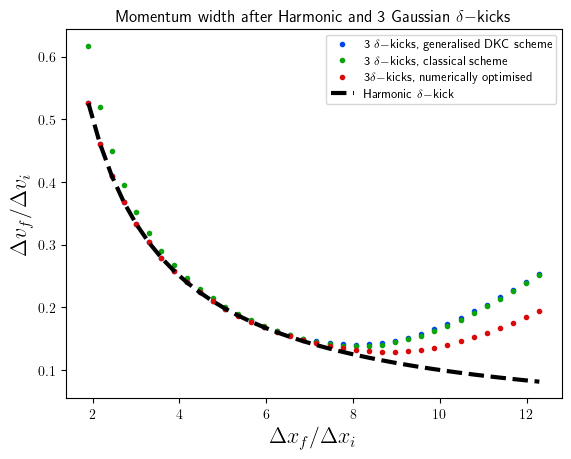

In [62]:
"""Plot final momentum after harmonic kick or 3 Gaussian kicks (all 3 schemes for optimisation)"""

# plt.plot(sigma_wavefunction_after_free_expansion[0:N_plot_display]/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv[0:N_plot_display]/sigma_k_ground , '+',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, generalised DKC scheme')
# plt.plot(sigma_wavefunction_after_free_expansion[0:N_plot_display]/sigma_wavefunction_ground, sigma_k_2_delta_kick[0:N_plot_display]/sigma_k_ground , '-',linewidth = 3, color = color_green, label = '2 $\delta-$kicks, classical scheme')
# plt.plot(sigma_wavefunction_after_free_expansion[0:N_plot_display]/sigma_wavefunction_ground, sigma_k_harmonic[0:N_plot_display]/sigma_k_ground, '--', linewidth = 3, color = 'black', label = 'Harmonic $\delta-$kick')


plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick_scale_inv/sigma_k_ground , '.',linewidth = 3, color = color_blue, label = '3 $\delta-$kicks, generalised DKC scheme')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick/sigma_k_ground , '.',linewidth = 3, color = color_green, label = '3 $\delta-$kicks, classical scheme')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , '.',linewidth = 3, color = color_red, label = '3$\delta-$kicks, numerically optimised')
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black', label = 'Harmonic $\delta-$kick')


plt.legend(loc = 'upper right',prop={"size":8.5})
# plt.xlim(0,15)

plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
plt.title('Momentum width after Harmonic and 3 Gaussian $\delta-$kicks')


# Define filename
filename = 'Momentum width comparison after Harmonic and 3 Gaussian delta-kicks (sigma = %5.2f, %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path)



# plt.savefig('Momentum width after Harmonic, 1 and 2 Gaussian delta-kicks (sigma = %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground]))
plt.show()

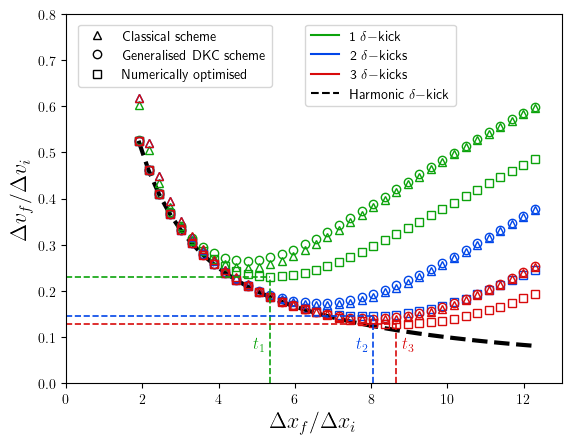

In [63]:
"""Plot -- harmonic kick, 1,2,3 gaussian kicks"""

# # 1 kick
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground , '^',fillstyle = 'none', linewidth = 3, color = color_green, label = 'Gaussian kick, classical scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'o', fillstyle = 'none', linewidth = 3, color = color_green, label = 'Gaussian kick, generalised DKC scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,'s', fillstyle = 'none' , linewidth = 3, color = color_green, label = 'Gaussian kick, numerically optimised')

# # harmonic kick
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black', label = 'Harmonic kick')

# # 2 kicks
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, classical scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, generalised DKC scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, numerically optimised')


# harmonic kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black')

# 1 kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground , '^',fillstyle = 'none', linewidth = 3, color = color_green)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'o', fillstyle = 'none', linewidth = 3, color = color_green)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,'s', fillstyle = 'none' , linewidth = 3, color = color_green)


# 2 kicks
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_blue)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_blue)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_blue)

# 3 kicks
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_red)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_red)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_red)




# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_Gaussian_opt_min)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_Gaussian_opt_min[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_green, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_green, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
y_offset = 0.1  # Adjust this value as needed to avoid overlap
plt.text(min_x-0.3, y_offset, '$t_1$', ha='center', va='top', fontsize=12, color=color_green)



# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_2_delta_kick_numerical_opt_gradient_descent)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_2_delta_kick_numerical_opt_gradient_descent[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_blue, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_blue, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
# y_offset = 0.05  # Adjust this value as needed to avoid overlap
plt.text(min_x-0.3, y_offset, '$t_2$', ha='center', va='top', fontsize=12, color=color_blue)




# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_3_delta_kick_numerical_opt_gradient_descent[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_red, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_red, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
# y_offset = 0.05  # Adjust this value as needed to avoid overlap
plt.text(min_x+0.3, y_offset, '$t_3$', ha='center', va='top', fontsize=12, color=color_red)



# plt.xlim(left=1.8)
# plt.ylim(bottom=0.07)

# plt.xlim(1.8, 13)
# plt.ylim(0.05, 0.7)

plt.xlim(0, 13)
plt.ylim(0, 0.8)



# Create dummy plots for the legend
line1, = plt.plot([], [], '^',fillstyle = 'none', color = 'black', label='Classical scheme')
line2, = plt.plot([], [], 'o', fillstyle = 'none', color = 'black', label='Generalised DKC scheme')
line3, = plt.plot([], [], 's', fillstyle = 'none', color = 'black', label='Numerically optimised')
line7, = plt.plot([], [], '--', fillstyle = 'none', color = 'black', label='Harmonic $\delta-$kick')
line4, = plt.plot([], [], '-', fillstyle = 'none', color = color_green, label='1 $\delta-$kick')
line5, = plt.plot([], [], '-', fillstyle = 'none', color = color_blue, label='2 $\delta-$kicks')
line6, = plt.plot([], [], '-', fillstyle = 'none', color = color_red, label='3 $\delta-$kicks')

# # plt.legend(loc = 'upper center',prop={"size":8})
# plt.legend(loc='upper left', bbox_to_anchor=(0.095, 0.99), prop={"size": 9.5})

# Add the first legend
first_legend = plt.legend(handles=[line1, line2, line3], loc='upper left', bbox_to_anchor=(0.01, 0.99), prop={"size": 10})
plt.gca().add_artist(first_legend)

# Add the second legend
plt.legend(handles=[line4, line5, line6, line7], loc='upper right', bbox_to_anchor=(0.8, 0.99), prop={"size": 10})


plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
# plt.title('Momentum width after a Gaussian and a Harmonic $\delta-$kick')

# Define the directory and filename
filename = 'Momentum width comparison after Harmonic, 1, 2, 3 Gaussian delta-kicks (sigma = %5.2f, %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)

# Save the plot
# plt.savefig(save_path)

plt.show()

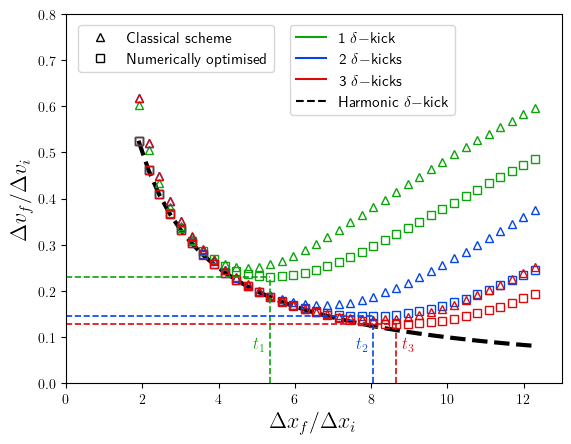

In [64]:
"""Plotting for the classically inspired scheme and numerically optimized (not the one obtained from generalized DKC approach for scale invariant dynamics)"""


"""Plot -- harmonic kick, 1,2,3 gaussian kicks"""

# # 1 kick
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground , '^',fillstyle = 'none', linewidth = 3, color = color_green, label = 'Gaussian kick, classical scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'o', fillstyle = 'none', linewidth = 3, color = color_green, label = 'Gaussian kick, generalised DKC scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,'s', fillstyle = 'none' , linewidth = 3, color = color_green, label = 'Gaussian kick, numerically optimised')

# # harmonic kick
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black', label = 'Harmonic kick')

# # 2 kicks
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, classical scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, generalised DKC scheme')
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_blue, label = '2 $\delta-$kicks, numerically optimised')


# harmonic kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black')

# 1 kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground , '^',fillstyle = 'none', linewidth = 3, color = color_green)
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'o', fillstyle = 'none', linewidth = 3, color = color_green)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,'s', fillstyle = 'none' , linewidth = 3, color = color_green)


# 2 kicks
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_blue)
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_blue)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_blue)

# 3 kicks
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick/sigma_k_ground , '^',fillstyle = 'none',linewidth = 3, color = color_red)
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_red)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , 's', fillstyle = 'none',linewidth = 3, color = color_red)




# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_Gaussian_opt_min)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_Gaussian_opt_min[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_green, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_green, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
y_offset = 0.1  # Adjust this value as needed to avoid overlap
plt.text(min_x-0.3, y_offset, '$t_1$', ha='center', va='top', fontsize=12, color=color_green)



# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_2_delta_kick_numerical_opt_gradient_descent)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_2_delta_kick_numerical_opt_gradient_descent[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_blue, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_blue, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
# y_offset = 0.05  # Adjust this value as needed to avoid overlap
plt.text(min_x-0.3, y_offset, '$t_2$', ha='center', va='top', fontsize=12, color=color_blue)




# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_3_delta_kick_numerical_opt_gradient_descent[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_red, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_red, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
# y_offset = 0.05  # Adjust this value as needed to avoid overlap
plt.text(min_x+0.3, y_offset, '$t_3$', ha='center', va='top', fontsize=12, color=color_red)



# plt.xlim(left=1.8)
# plt.ylim(bottom=0.07)

# plt.xlim(1.8, 13)
# plt.ylim(0.05, 0.7)

plt.xlim(0, 13)
plt.ylim(0, 0.8)



# Create dummy plots for the legend
line1, = plt.plot([], [], '^',fillstyle = 'none', color = 'black', label='Classical scheme')
# line2, = plt.plot([], [], 'o', fillstyle = 'none', color = 'black', label='Generalised DKC scheme')
line3, = plt.plot([], [], 's', fillstyle = 'none', color = 'black', label='Numerically optimised')
line7, = plt.plot([], [], '--', fillstyle = 'none', color = 'black', label='Harmonic $\delta-$kick')
line4, = plt.plot([], [], '-', fillstyle = 'none', color = color_green, label='1 $\delta-$kick')
line5, = plt.plot([], [], '-', fillstyle = 'none', color = color_blue, label='2 $\delta-$kicks')
line6, = plt.plot([], [], '-', fillstyle = 'none', color = color_red, label='3 $\delta-$kicks')

# # plt.legend(loc = 'upper center',prop={"size":8})
# plt.legend(loc='upper left', bbox_to_anchor=(0.095, 0.99), prop={"size": 9.5})

# Add the first legend
first_legend = plt.legend(handles=[line1, line3], loc='upper left', bbox_to_anchor=(0.01, 0.99), prop={"size": 11})
plt.gca().add_artist(first_legend)

# Add the second legend
plt.legend(handles=[line4, line5, line6, line7], loc='upper right', bbox_to_anchor=(0.8, 0.99), prop={"size": 11})


plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
# plt.title('Momentum width after a Gaussian and a Harmonic $\delta-$kick')

# Define the directory and filename
filename = '(No generalized DKC) Momentum width comparison after Harmonic, 1, 2, 3 Gaussian delta-kicks (sigma = %5.2f, %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)

# Save the plot
# plt.savefig(save_path)

plt.show()

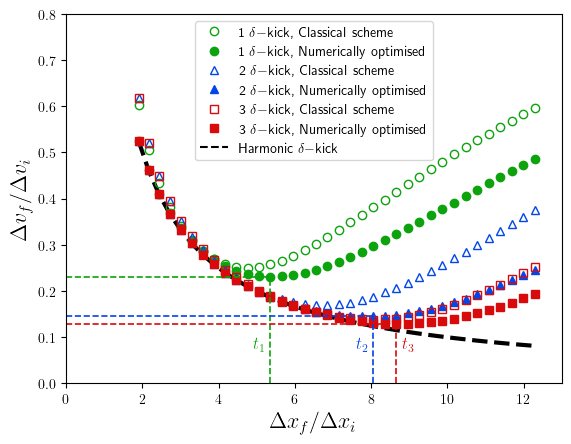

In [104]:
"""Making the same plot as above, but with different markers and colors for the legend"""

"""Plotting for the classically inspired scheme and numerically optimized (not the one obtained from generalized DKC approach for scale invariant dynamics)"""
"""Plot -- harmonic kick, 1,2,3 gaussian kicks"""

from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple


m_style = ['o','o','^','^','s','s']
marker_fill_style = ['none','full','none','full','none','full']    

# m_style = ['P','*','^','v','o','s']
# marker_fill_style = ['none','none','none','none','none','none']    


# harmonic kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_harmonic/sigma_k_ground, '--', linewidth = 3, color = 'black')

# 1 kick
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor/sigma_k_ground , m_style[0],fillstyle = marker_fill_style[0], linewidth = 3, color = color_green)
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_Taylor_scale_inv/sigma_k_ground ,'o', fillstyle = 'none', linewidth = 3, color = color_green)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_Gaussian_opt_min/sigma_k_ground,m_style[1], fillstyle = marker_fill_style[1] , linewidth = 3, color = color_green)

# 2 kicks
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick/sigma_k_ground , m_style[2],fillstyle = marker_fill_style[2],linewidth = 3, color = color_blue)
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_blue)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_2_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , m_style[3], fillstyle = marker_fill_style[3],linewidth = 3, color = color_blue)

# 3 kicks
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick/sigma_k_ground , m_style[4],fillstyle = marker_fill_style[4],linewidth = 3, color = color_red)
# plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick_scale_inv/sigma_k_ground , 'o', fillstyle = 'none', linewidth = 3, color = color_red)
plt.plot(sigma_wavefunction_after_free_expansion/sigma_wavefunction_ground, sigma_k_3_delta_kick_numerical_opt_gradient_descent/sigma_k_ground , m_style[5], fillstyle = marker_fill_style[5],linewidth = 3, color = color_red)

# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_Gaussian_opt_min)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_Gaussian_opt_min[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_green, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_green, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
y_offset = 0.1  # Adjust this value as needed to avoid overlap
plt.text(min_x-0.3, y_offset, '$t_1$', ha='center', va='top', fontsize=12, color=color_green)



# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_2_delta_kick_numerical_opt_gradient_descent)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_2_delta_kick_numerical_opt_gradient_descent[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_blue, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_blue, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
# y_offset = 0.05  # Adjust this value as needed to avoid overlap
plt.text(min_x-0.3, y_offset, '$t_2$', ha='center', va='top', fontsize=12, color=color_blue)




# Find the index of the minimum point in the data
min_index = np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)

# Coordinates of the minima
min_x = sigma_wavefunction_after_free_expansion[min_index] / sigma_wavefunction_ground
min_y = sigma_k_3_delta_kick_numerical_opt_gradient_descent[min_index] / sigma_k_ground

# Add dashed vertical line from the minima point to the x-axis
plt.plot([min_x, min_x], [0, min_y], color=color_red, linestyle='--', linewidth=1.2)

# Add dashed horizontal line from the minima point to the y-axis
plt.plot([0, min_x], [min_y, min_y], color=color_red, linestyle='--', linewidth=1.2)
# Label the intersection point on the x-axis with a small offset to avoid intersection with axis numbers
# y_offset = 0.05  # Adjust this value as needed to avoid overlap
plt.text(min_x+0.3, y_offset, '$t_3$', ha='center', va='top', fontsize=12, color=color_red)



# plt.xlim(left=1.8)
# plt.ylim(bottom=0.07)

# plt.xlim(1.8, 13)
# plt.ylim(0.05, 0.7)

plt.xlim(0, 13)
plt.ylim(0, 0.8)



# Create dummy plots for the legend
line1, = plt.plot([], [], m_style[0],fillstyle = marker_fill_style[0], color = color_green, label='1 $\delta-$kick, Classical scheme')
line2, = plt.plot([], [], m_style[1],fillstyle = marker_fill_style[1], color = color_green, label='1 $\delta-$kick, Numerically optimised')

line3, = plt.plot([], [], m_style[2],fillstyle = marker_fill_style[2], color = color_blue, label='2 $\delta-$kick, Classical scheme')
line4, = plt.plot([], [], m_style[3],fillstyle = marker_fill_style[3], color = color_blue, label='2 $\delta-$kick, Numerically optimised')

line5, = plt.plot([], [], m_style[4],fillstyle = marker_fill_style[4], color = color_red, label='3 $\delta-$kick, Classical scheme')
line6, = plt.plot([], [], m_style[5],fillstyle = marker_fill_style[5], color = color_red, label='3 $\delta-$kick, Numerically optimised')

line7, = plt.plot([], [], '--', fillstyle = 'none', color = 'black', label='Harmonic $\delta-$kick')


hollow = Line2D([0], [0],
                marker='o',
                linestyle='',
                markeredgecolor='green',
                markerfacecolor='none',
                markersize=10,
                label=r'$\delta$-kick, classical scheme')
filled = Line2D([0], [0],
                marker='o',
                linestyle='',
                markeredgecolor='green',
                markerfacecolor='green',
                markersize=10,
                label='numerically optimized')

hollow = Line2D([], [], 
                marker='o', linestyle='',
                markeredgecolor='green', markerfacecolor='none',
                markersize=10)
filled = Line2D([], [], 
                marker='o', linestyle='',
                markeredgecolor='green', markerfacecolor='green',
                markersize=10)

# one legend entry: a tuple of the two artists, and one label
plt.legend(
    [(hollow, filled)],  # <-- tuple of handles
    [r'$\delta$-kick, classical scheme and numerically optimized'],  # one label
    handler_map={tuple: HandlerTuple()},  # draw tuple‐handles side by side
    frameon=False,
    loc='upper left',
)

# Add the second legend
plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7], loc='upper center', prop={"size": 10})

# plt.legend(handles=[hollow, filled],
#            loc='upper right',
#            frameon=False)   # frameon=False makes it look “cleaner” like your example

plt.xlabel(r'$\Delta x_f/\Delta x_i$',fontsize = 16)
plt.ylabel(r'$\Delta v_f/\Delta v_i$',fontsize = 16)
# plt.title('Momentum width after a Gaussian and a Harmonic $\delta-$kick')

# Define the directory and filename
filename = '(No generalized DKC) Momentum width comparison after Harmonic, 1, 2, 3 Gaussian delta-kicks (sigma = %5.2f, %5.2f, %5.2f Delta x_i) & Harmonic delta-kick.pdf'%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)

# Save the plot
# plt.savefig(save_path)

plt.show()

In [65]:
"""Saving data"""


# Define the full path for the file
filename = os.path.join(directory, "sigma_k_3_delta_kick_numerical_opt_gradient_descent.npy")
# Save the array
np.save(filename, sigma_k_3_delta_kick_numerical_opt_gradient_descent)

# Define the full path for the file
filename = os.path.join(directory, "N_f.npy")
# Save the array
np.save(filename, N_f)

# Define the full path for the file
filename = os.path.join(directory, "sigma_wavefunction_after_free_expansion.npy")
# Save the array
np.save(filename, sigma_wavefunction_after_free_expansion)


(23, 11, 16)
0.1288429926875693
23  ,  11 ,  16
0.1288429926875693


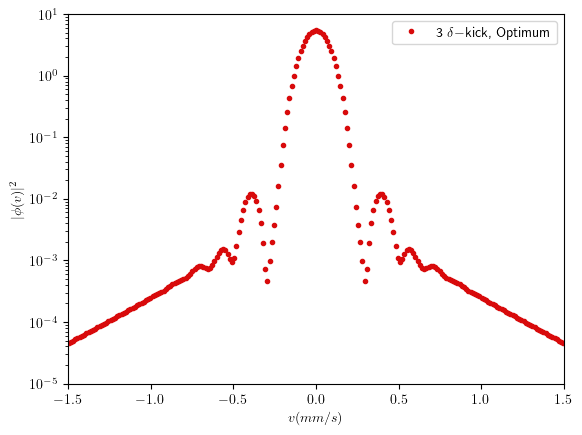

In [114]:
"""Minima of 3 delta kicks case -- numerically optimised scheme"""

# Create a mask to exclude zeros
mask = np.ma.masked_equal(sigma_k_iterations_array_3_kicks, 0)

# Find the minimum non-zero element
min_value = mask.min()

# Get the index of the minimum non-zero element
min_index = np.unravel_index(mask.argmin(), sigma_k_iterations_array_3_kicks.shape)

# Extract row, column, and depth from the index
depth, row, column = min_index

print(min_index)
print(min_value/sigma_k_ground)
print(depth," , ", row, ", ", column)

# print(np.argmin(sigma_k_iterations_array_3_kicks[]))
# print(sigma_k_3_delta_kick_numerical_opt_gradient_descent[np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)]/sigma_k_ground)

"""Plot FFT at the location of minima"""
"""Evaluate the kick strengths kappa at the location of minima"""

"""3 kicks"""
N_delta = 3
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


"""Now store sigma_k values for 3 delta kick case"""

N_f_index_3_kicks = depth
initial_kappa_factor_index_3_kicks = row
convergence_iteration_index_3_kicks = column

# for i in range(n_Nf):
psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_3_kicks]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_3_kicks]*k*0.5))
sigma_wavefunction_after_free_expansion = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
kappa = optimized_kappa_3_kicks[N_f_index_3_kicks,initial_kappa_factor_index_3_kicks,:]
psi_after_3_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
for j in range(N_delta): # 2nd till N_th delta kick
    if j>0:
        psi_after_3_delta_kick = psi_after_3_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
ft_psi_after_3_delta_kick = (2/np.size(K))*np.abs(fft.fft(psi_after_3_delta_kick)) # FFT of psi after delta kick
ft_psi_after_3_delta_kick = np.concatenate((ft_psi_after_3_delta_kick[N_x//2:], ft_psi_after_3_delta_kick[:N_x//2]))    
integral = area_total(K,ft_psi_after_3_delta_kick**2) # to get normalisation constant
ft_psi_after_3_delta_kick = ft_psi_after_3_delta_kick/np.sqrt(integral)
sigma_k_3_delta_kick = np.real(np.sqrt(expectation_value(K,ft_psi_after_3_delta_kick,K**2)-(expectation_value(K,ft_psi_after_3_delta_kick,K)**2))) # spread in k space
# print(kappa)
print(sigma_k_3_delta_kick/sigma_k_ground)


x_min_lim = -1.5
x_max_lim = 1.5
y_min_lim = 1e-5
y_max_lim = 1e1

plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_3_delta_kick)/(velocity_scale*1e3),'.', color = color_red,label = "3 $\delta-$kick, Optimum")
# plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_2_delta_kick[index_sigma_k_Gaussian_opt,:])/(velocity_scale*1e3),'-', color = color_blue, label = "2 $\delta-$kicks")
# plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_3_delta_kick[index_sigma_k_Gaussian_opt,:])/(velocity_scale*1e3),'-', color = color_red, label = "3 $\delta-$kicks")
# plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_harmonic_delta_kick[index_sigma_k_Gaussian_opt,:])/(velocity_scale*1e3),'--', color = 'black',label = "Harmonic $\delta-$kicks")

# plt.title("Same free expansion time $t_f = %5.2f$ ms"%tuple([N_f[index_sigma_k_Gaussian_opt]*k*time_scale*1e3]))


# plt.legend(loc = 'lower center',prop={"size":8})
plt.legend(loc = 'upper right',prop={"size":10})

plt.ylabel("$|\phi(v)|^2$")
plt.xlabel("$v (mm/s)$")

plt.yscale("log")
plt.ylim([y_min_lim,y_max_lim])
plt.xlim([x_min_lim,x_max_lim])


# Define filename
filename = "DKC 3 kick numerical opt minima, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path)





(21, 16, 50)
0.14504464910457796
21  ,  16 ,  50
0.14504464910457796


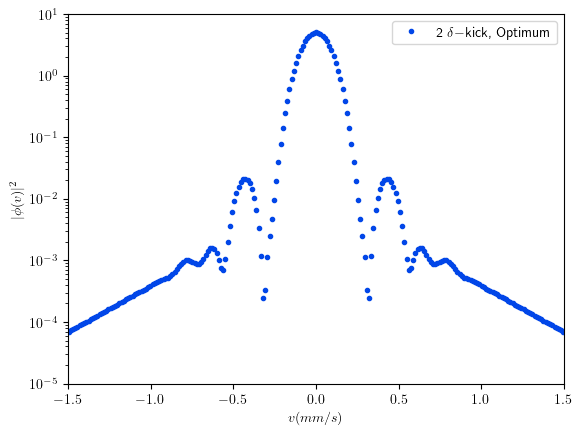

In [115]:
# print(np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent))
# print(sigma_k_3_delta_kick_numerical_opt_gradient_descent[np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)]/sigma_k_ground)

"""Minima of 2 delta kicks case -- numerically optimised scheme"""

"""Load save optimised parameters"""
# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-07-24/2 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14)*delta x_i/sigma_k_iterations_array.npy"
# sigma_k_iterations_array = np.load(path_to_file)


# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-07-24/2 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14)*delta x_i/optimized_kappa.npy"
# optimized_kappa = np.load(path_to_file)


# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/sigma_k_iterations_array.npy"
sigma_k_iterations_array = np.load(path_to_file)


# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/optimized_kappa.npy"
optimized_kappa = np.load(path_to_file)

# Create a mask to exclude zeros
mask = np.ma.masked_equal(sigma_k_iterations_array, 0)

# Find the minimum non-zero element
min_value = mask.min()

# Get the index of the minimum non-zero element
min_index = np.unravel_index(mask.argmin(), sigma_k_iterations_array.shape)

# Extract row, column, and depth from the index
depth, row, column = min_index

print(min_index)
print(min_value/sigma_k_ground)
print(depth," , ", row, ", ", column)

# print(np.argmin(sigma_k_iterations_array_3_kicks[]))
# print(sigma_k_3_delta_kick_numerical_opt_gradient_descent[np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)]/sigma_k_ground)

"""Plot FFT at the location of minima"""
"""Evaluate the kick strengths kappa at the location of minima"""

"""2 kicks"""
N_delta = 2
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


"""Now store sigma_k values for 2 delta kick case"""

N_f_index_2_kicks = depth
initial_kappa_factor_index_2_kicks = row
convergence_iteration_index_2_kicks = column

# for i in range(n_Nf):
psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_2_kicks]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_2_kicks]*k*0.5))
sigma_wavefunction_after_free_expansion = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
kappa = optimized_kappa[N_f_index_2_kicks,initial_kappa_factor_index_2_kicks,:]
psi_after_2_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
for j in range(N_delta): # 2nd till N_th delta kick
    if j>0:
        psi_after_2_delta_kick = psi_after_2_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
ft_psi_after_2_delta_kick = (2/np.size(K))*np.abs(fft.fft(psi_after_2_delta_kick)) # FFT of psi after delta kick
ft_psi_after_2_delta_kick = np.concatenate((ft_psi_after_2_delta_kick[N_x//2:], ft_psi_after_2_delta_kick[:N_x//2]))    
integral = area_total(K,ft_psi_after_2_delta_kick**2) # to get normalisation constant
ft_psi_after_2_delta_kick = ft_psi_after_2_delta_kick/np.sqrt(integral)
sigma_k_2_delta_kick = np.real(np.sqrt(expectation_value(K,ft_psi_after_2_delta_kick,K**2)-(expectation_value(K,ft_psi_after_2_delta_kick,K)**2))) # spread in k space
# print(kappa)
print(sigma_k_2_delta_kick/sigma_k_ground)


x_min_lim = -1.5
x_max_lim = 1.5
y_min_lim = 1e-5
y_max_lim = 1e1

plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_2_delta_kick)/(velocity_scale*1e3),'.', color = color_blue,label = "2 $\delta-$kick, Optimum")
# plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_2_delta_kick[index_sigma_k_Gaussian_opt,:])/(velocity_scale*1e3),'-', color = color_blue, label = "2 $\delta-$kicks")
# plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_3_delta_kick[index_sigma_k_Gaussian_opt,:])/(velocity_scale*1e3),'-', color = color_red, label = "3 $\delta-$kicks")
# plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_harmonic_delta_kick[index_sigma_k_Gaussian_opt,:])/(velocity_scale*1e3),'--', color = 'black',label = "Harmonic $\delta-$kicks")

# plt.title("Same free expansion time $t_f = %5.2f$ ms"%tuple([N_f[index_sigma_k_Gaussian_opt]*k*time_scale*1e3]))


# plt.legend(loc = 'lower center',prop={"size":8})
plt.legend(loc = 'upper right',prop={"size":10})

plt.ylabel("$|\phi(v)|^2$")
plt.xlabel("$v (mm/s)$")

plt.yscale("log")
plt.ylim([y_min_lim,y_max_lim])
plt.xlim([x_min_lim,x_max_lim])


# Define filename
filename = "DKC, same T_f, sigma = (%5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path)





Minimum element found at row 12, column 65
12
65


(-1.5, 1.5)

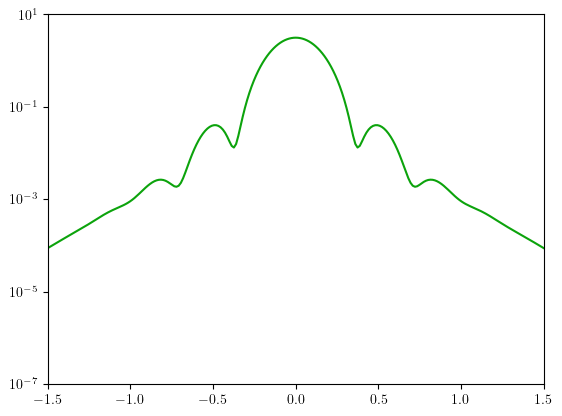

In [116]:
"""Numerical optimum for 1 kick case"""

row_indices, col_indices = np.where(sigma_k_Gaussian_opt == np.min(sigma_k_Gaussian_opt))

for index_sigma_k_Gaussian_opt_row, index_sigma_k_Gaussian_opt_col in zip(row_indices, col_indices):
    print(f"Minimum element found at row {index_sigma_k_Gaussian_opt_row}, column {index_sigma_k_Gaussian_opt_col}")

print(index_sigma_k_Gaussian_opt_row)
print(index_sigma_k_Gaussian_opt_col)

plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_Gaussian_delta_kick_opt[index_sigma_k_Gaussian_opt_row,index_sigma_k_Gaussian_opt_col,:])/(velocity_scale*1e3),'-', color = color_green,label = "Gaussian $\delta-$kick, Optimum")
plt.yscale("log")
plt.ylim([1e-7,1e1])
plt.xlim([-1.5,1.5])


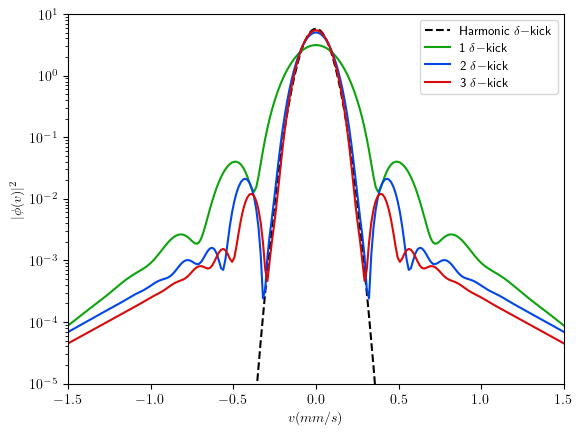

In [117]:
"""All three plots at the same location"""

N_delta = 3
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground

plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_harmonic_delta_kick[N_f_index_3_kicks,:])/(velocity_scale*1e3),'--', color = 'black',label = "Harmonic $\delta-$kick")

plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_Gaussian_delta_kick_opt[index_sigma_k_Gaussian_opt_row,index_sigma_k_Gaussian_opt_col,:])/(velocity_scale*1e3),'-', color = color_green,label = "1 $\delta-$kick")
plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_2_delta_kick)/(velocity_scale*1e3),'-', color = color_blue,label = "2 $\delta-$kick")
plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_3_delta_kick)/(velocity_scale*1e3),'-', color = color_red,label = "3 $\delta-$kick")


# plt.legend(loc = 'lower center',prop={"size":8})
plt.legend(loc = 'upper right',prop={"size":9})

plt.ylabel("$|\phi(v)|^2$")
plt.xlabel("$v (mm/s)$")

x_min_lim = -0.5
x_max_lim = 0.5
y_min_lim = 1e-5
y_max_lim = 1e1

x_min_lim = -1.5
x_max_lim = 1.5
y_min_lim = 1e-5
y_max_lim = 1e1
plt.yscale("log")
plt.ylim([y_min_lim,y_max_lim])
plt.xlim([x_min_lim,x_max_lim])

# Define filename
filename = "DKC, different T_f, log scale, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
# filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
# plt.savefig(save_path)


(23, 11, 16)
0.1288429926875693
23  ,  11 ,  16
sigma_k_3_delta_kick/sigma_k_ground =  0.1288429926875693


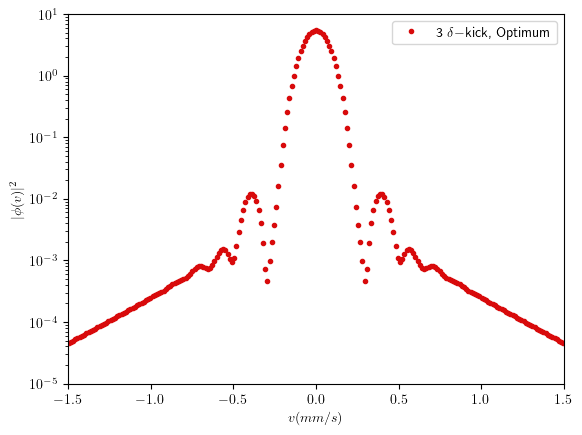

(21, 16, 50)
0.14504464910457796
21  ,  16 ,  50
0.14504464910457796


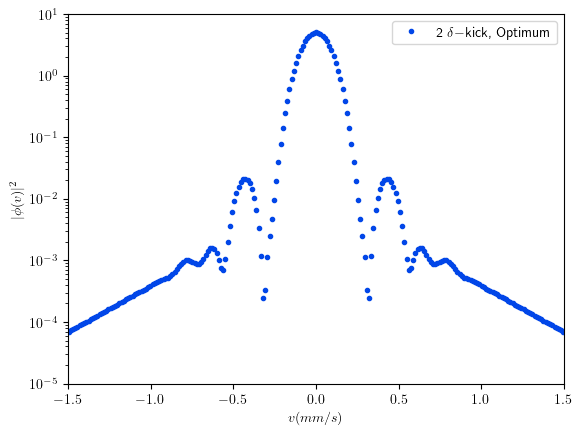

Minimum element found at row 12, column 65
12
65


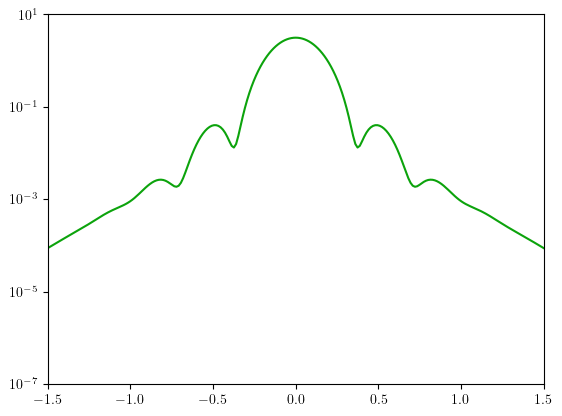

12
5200.0
2 delta kicks...
(0, 12, 60)
0.18774713428719533
12 ,  60
0.18774713428719533
0.18774713428719533
____________________________________
(0, 10, 25)
0.18694097179035912
21  ,  10 ,  25
3 kicks...
0.18694097179035912


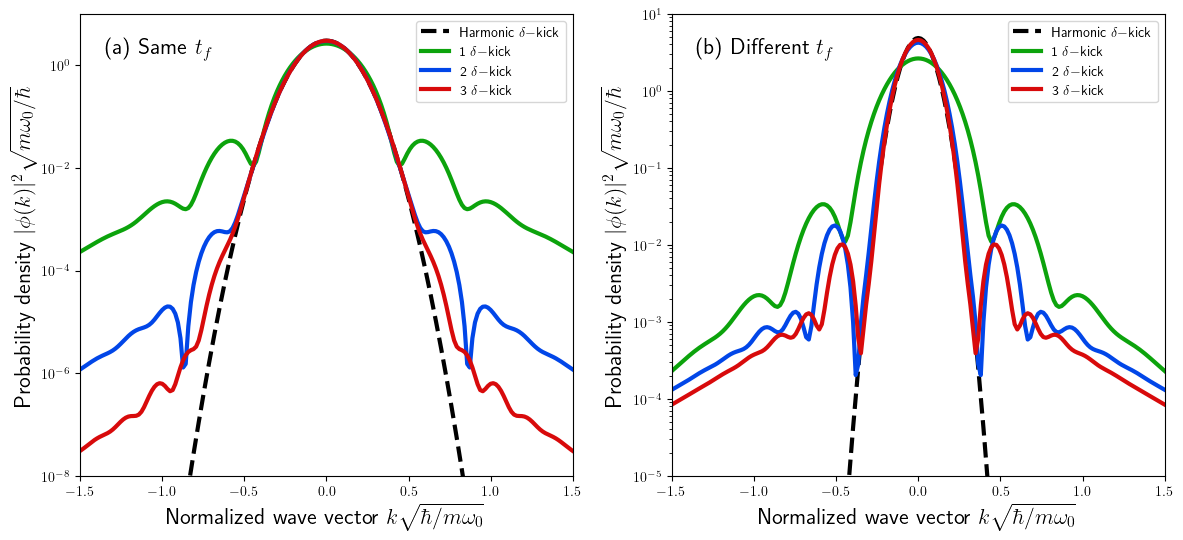

In [118]:
"""All three plots at the same location"""

""" plot the graph for dimensionless variables """


"""Different free expansion times"""



"""Minima of 3 delta kicks case -- numerically optimised scheme"""

"""Load data"""
# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-07-24/3 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14,13)*delta x_i/sigma_k_iterations_array_3_kicks.npy"
# # Load the array
# sigma_k_iterations_array_3_kicks = np.load(path_to_file)

# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-07-24/3 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14,13)*delta x_i/optimized_kappa_3_kicks.npy"
# # Load the array
# optimized_kappa_3_kicks = np.load(path_to_file)

# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-07-24/3 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14,13)*delta x_i/sigma_wavefunction_after_free_expansion.npy"
# # Load the array
# sigma_wavefunction_after_free_expansion = np.load(path_to_file)


# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/sigma_k_iterations_array_3_kicks.npy"
# Load the array
sigma_k_iterations_array_3_kicks = np.load(path_to_file)

# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/optimized_kappa_3_kicks.npy"
# Load the array
optimized_kappa_3_kicks = np.load(path_to_file)

# Define the path to the saved array
path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2025-02-18/sigma_wavefunction_after_free_expansion.npy"
# Load the array
sigma_wavefunction_after_free_expansion = np.load(path_to_file)





# # print(np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent))
# # print(sigma_k_3_delta_kick_numerical_opt_gradient_descent[np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)]/sigma_k_ground)


# Create a mask to exclude zeros
mask = np.ma.masked_equal(sigma_k_iterations_array_3_kicks, 0)

# Find the minimum non-zero element
min_value = mask.min()

# Get the index of the minimum non-zero element
min_index = np.unravel_index(mask.argmin(), sigma_k_iterations_array_3_kicks.shape)

# Extract row, column, and depth from the index
depth, row, column = min_index

print(min_index)
print(min_value/sigma_k_ground)
print(depth," , ", row, ", ", column)

# print(np.argmin(sigma_k_iterations_array_3_kicks[]))
# print(sigma_k_3_delta_kick_numerical_opt_gradient_descent[np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)]/sigma_k_ground)

"""Plot FFT at the location of minima"""
"""Evaluate the kick strengths kappa at the location of minima"""

"""3 kicks"""
N_delta = 3
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


"""Now store sigma_k values for 3 delta kick case"""

N_f_index_3_kicks = depth
initial_kappa_factor_index_3_kicks = row
convergence_iteration_index_3_kicks = column

# for i in range(n_Nf):
psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_3_kicks]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_3_kicks]*k*0.5))
sigma_wavefunction_after_free_expansion = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
kappa = optimized_kappa_3_kicks[N_f_index_3_kicks,initial_kappa_factor_index_3_kicks,:]
psi_after_3_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
for j in range(N_delta): # 2nd till N_th delta kick
    if j>0:
        psi_after_3_delta_kick = psi_after_3_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
ft_psi_after_3_delta_kick = (2/np.size(K))*np.abs(fft.fft(psi_after_3_delta_kick)) # FFT of psi after delta kick
ft_psi_after_3_delta_kick = np.concatenate((ft_psi_after_3_delta_kick[N_x//2:], ft_psi_after_3_delta_kick[:N_x//2]))    
integral = area_total(K,ft_psi_after_3_delta_kick**2) # to get normalisation constant
ft_psi_after_3_delta_kick = ft_psi_after_3_delta_kick/np.sqrt(integral)
sigma_k_3_delta_kick = np.real(np.sqrt(expectation_value(K,ft_psi_after_3_delta_kick,K**2)-(expectation_value(K,ft_psi_after_3_delta_kick,K)**2))) # spread in k space
# print(kappa)
print("sigma_k_3_delta_kick/sigma_k_ground = ", sigma_k_3_delta_kick/sigma_k_ground)



x_min_lim = -1.5
x_max_lim = 1.5
y_min_lim = 1e-5
y_max_lim = 1e1

plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_3_delta_kick)/(velocity_scale*1e3),'.', color = color_red,label = "3 $\delta-$kick, Optimum")

plt.legend(loc = 'upper right',prop={"size":10})

plt.ylabel("$|\phi(v)|^2$")
plt.xlabel("$v (mm/s)$")

plt.yscale("log")
plt.ylim([y_min_lim,y_max_lim])
plt.xlim([x_min_lim,x_max_lim])
plt.show()


# print(np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent))
# print(sigma_k_3_delta_kick_numerical_opt_gradient_descent[np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)]/sigma_k_ground)

"""Minima of 2 delta kicks case -- numerically optimised scheme"""

"""Load save optimised parameters"""
# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-07-24/2 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14)*delta x_i/sigma_k_iterations_array.npy"
# sigma_k_iterations_array = np.load(path_to_file)


# # Define the path to the saved array
# path_to_file = "/Users/harshilneeraj/Library/CloudStorage/OneDrive-UniversityofToronto/Research/Codes/gpe1d/examples/DKC,2024-07-24/2 kicks, numerical optimisation data, N_f = linspace(2000, 12000, 26), sigma = (15,14)*delta x_i/optimized_kappa.npy"
# optimized_kappa = np.load(path_to_file)


# Create a mask to exclude zeros
mask = np.ma.masked_equal(sigma_k_iterations_array, 0)

# Find the minimum non-zero element
min_value = mask.min()

# Get the index of the minimum non-zero element
min_index = np.unravel_index(mask.argmin(), sigma_k_iterations_array.shape)

# Extract row, column, and depth from the index
depth, row, column = min_index

print(min_index)
print(min_value/sigma_k_ground)
print(depth," , ", row, ", ", column)

# print(np.argmin(sigma_k_iterations_array_3_kicks[]))
# print(sigma_k_3_delta_kick_numerical_opt_gradient_descent[np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)]/sigma_k_ground)

"""Plot FFT at the location of minima"""
"""Evaluate the kick strengths kappa at the location of minima"""

"""2 kicks"""
N_delta = 2
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


"""Now store sigma_k values for 2 delta kick case"""

N_f_index_2_kicks = depth
initial_kappa_factor_index_2_kicks = row
convergence_iteration_index_2_kicks = column

# for i in range(n_Nf):
psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_2_kicks]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_2_kicks]*k*0.5))
sigma_wavefunction_after_free_expansion = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
kappa = optimized_kappa[N_f_index_2_kicks,initial_kappa_factor_index_2_kicks,:]
psi_after_2_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
for j in range(N_delta): # 2nd till N_th delta kick
    if j>0:
        psi_after_2_delta_kick = psi_after_2_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
ft_psi_after_2_delta_kick = (2/np.size(K))*np.abs(fft.fft(psi_after_2_delta_kick)) # FFT of psi after delta kick
ft_psi_after_2_delta_kick = np.concatenate((ft_psi_after_2_delta_kick[N_x//2:], ft_psi_after_2_delta_kick[:N_x//2]))    
integral = area_total(K,ft_psi_after_2_delta_kick**2) # to get normalisation constant
ft_psi_after_2_delta_kick = ft_psi_after_2_delta_kick/np.sqrt(integral)
sigma_k_2_delta_kick = np.real(np.sqrt(expectation_value(K,ft_psi_after_2_delta_kick,K**2)-(expectation_value(K,ft_psi_after_2_delta_kick,K)**2))) # spread in k space
# print(kappa)
print(sigma_k_2_delta_kick/sigma_k_ground)


x_min_lim = -1.5
x_max_lim = 1.5
y_min_lim = 1e-5
y_max_lim = 1e1

plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_2_delta_kick)/(velocity_scale*1e3),'.', color = color_blue,label = "2 $\delta-$kick, Optimum")
plt.legend(loc = 'upper right',prop={"size":10})

plt.ylabel("$|\phi(v)|^2$")
plt.xlabel("$v (mm/s)$")

plt.yscale("log")
plt.ylim([y_min_lim,y_max_lim])
plt.xlim([x_min_lim,x_max_lim])


plt.show()



"""Numerical optimum for 1 kick case"""

row_indices, col_indices = np.where(sigma_k_Gaussian_opt == np.min(sigma_k_Gaussian_opt))

for index_sigma_k_Gaussian_opt_row, index_sigma_k_Gaussian_opt_col in zip(row_indices, col_indices):
    print(f"Minimum element found at row {index_sigma_k_Gaussian_opt_row}, column {index_sigma_k_Gaussian_opt_col}")

print(index_sigma_k_Gaussian_opt_row)
print(index_sigma_k_Gaussian_opt_col)

plt.plot(K*1e3*velocity_scale,Prob(ft_psi_after_Gaussian_delta_kick_opt[index_sigma_k_Gaussian_opt_row,index_sigma_k_Gaussian_opt_col,:])/(velocity_scale*1e3),'-', color = color_green,label = "Gaussian $\delta-$kick, Optimum")
plt.yscale("log")
plt.ylim([1e-7,1e1])
plt.xlim([-1.5,1.5])

plt.show()



"""Now plotting different T_f for 1,2,3 kicks together"""



N_delta = 3
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground



fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Adjust the figsize as per your requirement


ax[1].plot(K,Prob(ft_psi_after_harmonic_delta_kick[N_f_index_3_kicks,:]),'--',linewidth = 3, color = 'black',label = "Harmonic $\delta-$kick")

ax[1].plot(K,Prob(ft_psi_after_Gaussian_delta_kick_opt[index_sigma_k_Gaussian_opt_row,index_sigma_k_Gaussian_opt_col,:]),'-',linewidth = 3, color = color_green,label = "1 $\delta-$kick")
ax[1].plot(K,Prob(ft_psi_after_2_delta_kick),'-',linewidth = 3, color = color_blue,label = "2 $\delta-$kick")
ax[1].plot(K,Prob(ft_psi_after_3_delta_kick),'-',linewidth = 3, color = color_red,label = "3 $\delta-$kick")


# plt.legend(loc = 'lower center',prop={"size":8})
ax[1].legend(loc = 'upper right',prop={"size":10})

ax[1].set_ylabel("Probability density $|\phi(k)|^2\sqrt{m\omega_0/\hbar}$", fontsize=16)
ax[1].set_xlabel("Normalized wave vector $k\sqrt{\hbar/m\omega_0}$", fontsize=16)

x_min_lim = -0.5
x_max_lim = 0.5
y_min_lim = 1e-5
y_max_lim = 1e1

x_min_lim = -1.5
x_max_lim = 1.5
y_min_lim = 1e-5
y_max_lim = 1e1
ax[1].set_yscale("log")
ax[1].set_ylim([y_min_lim,y_max_lim])
ax[1].set_xlim([x_min_lim,x_max_lim])

# # Define filename
# filename = "DKC, different T_f, dimensionless, log scale, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
# # filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
# save_path = os.path.join(directory, filename)
# # Save the plot
# plt.savefig(save_path)



""" _________________________________"""
""" _________________________________"""
""" _________________________________"""
""" _________________________________"""

print(np.argmin(sigma_k_Gaussian_opt_min/sigma_k_ground))
print(N_f[np.argmin(sigma_k_Gaussian_opt_min/sigma_k_ground)])

"""Now calc the FFT after 1, 2 and 3 gaussian delta kick, and a harmonic kick at t = t_f for minimum momentum width using 1 delta kick"""

N_f_index = np.argmin(sigma_k_Gaussian_opt_min/sigma_k_ground)


"""Evaluate the kick strengths kappa at the location of minima"""

"""2 kicks"""
print("2 delta kicks...")

N_delta = 2
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


"""Now store sigma_k values for 2 delta kick case"""

# Create a mask to exclude zeros
mask = np.ma.masked_equal(sigma_k_iterations_array[N_f_index,:,:], 0)

# Find the minimum non-zero element
min_value = np.min(mask)

# Get the index of the minimum non-zero element
min_index = np.unravel_index(np.argmin(mask), sigma_k_iterations_array.shape)

# Extract row, column, and depth from the index
tessttttt, row, column = min_index

print(min_index)
print(min_value/sigma_k_ground)
print(row, ", ", column)
print(sigma_k_iterations_array[N_f_index, row, column]/sigma_k_ground)

N_f_index_2_kicks = N_f_index
initial_kappa_factor_index_2_kicks = row
convergence_iteration_index_2_kicks = column

# for i in range(n_Nf):
psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_2_kicks]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_2_kicks]*k*0.5))
sigma_wavefunction_after_free_expansion = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
kappa = optimized_kappa[N_f_index_2_kicks,initial_kappa_factor_index_2_kicks,:]
psi_after_2_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
for j in range(N_delta): # 2nd till N_th delta kick
    if j>0:
        psi_after_2_delta_kick = psi_after_2_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
ft_psi_after_2_delta_kick = (2/np.size(K))*np.abs(fft.fft(psi_after_2_delta_kick)) # FFT of psi after delta kick
ft_psi_after_2_delta_kick = np.concatenate((ft_psi_after_2_delta_kick[N_x//2:], ft_psi_after_2_delta_kick[:N_x//2]))    
integral = area_total(K,ft_psi_after_2_delta_kick**2) # to get normalisation constant
ft_psi_after_2_delta_kick = ft_psi_after_2_delta_kick/np.sqrt(integral)
sigma_k_2_delta_kick = np.real(np.sqrt(expectation_value(K,ft_psi_after_2_delta_kick,K**2)-(expectation_value(K,ft_psi_after_2_delta_kick,K)**2))) # spread in k space
# print(kappa)
print(sigma_k_2_delta_kick/sigma_k_ground)

print("____________________________________")


"""Minima of 3 delta kicks case -- numerically optimised scheme"""

# Create a mask to exclude zeros
mask = np.ma.masked_equal(sigma_k_iterations_array_3_kicks[N_f_index,:,:], 0)

# Find the minimum non-zero element
min_value = mask.min()

# Get the index of the minimum non-zero element
min_index = np.unravel_index(np.argmin(mask), sigma_k_iterations_array_3_kicks.shape)

# Extract row, column, and depth from the index
tessttttt, row, column = min_index

print(min_index)
print(min_value/sigma_k_ground)
print(depth," , ", row, ", ", column)

# print(np.argmin(sigma_k_iterations_array_3_kicks[]))
# print(sigma_k_3_delta_kick_numerical_opt_gradient_descent[np.argmin(sigma_k_3_delta_kick_numerical_opt_gradient_descent)]/sigma_k_ground)

"""Plot FFT at the location of minima"""
"""Evaluate the kick strengths kappa at the location of minima"""

"""3 kicks"""
print("3 kicks...")
N_delta = 3
sigma_array = np.zeros(N_delta) # the matrix of the sigma (RMS size) of all the Gaussian beams
sigma_array[0] = sigma_a/sigma_wavefunction_ground # size of the first Gaussian lens beam, relative to the ground state wavefunction size
for i in range(N_delta):
    if i>0:
        sigma_array[i] = sigma_array[i-1]-1 # making all the beams differ in size by a fixed amount
sigma_array = sigma_array*sigma_wavefunction_ground


"""Now store sigma_k values for 3 delta kick case"""

N_f_index_3_kicks = N_f_index
initial_kappa_factor_index_3_kicks = row
convergence_iteration_index_3_kicks = column

# for i in range(n_Nf):
psi_after_free_evolution = ((sigma_wavefunction_ground*sigma_wavefunction_ground/(2*pi*(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_3_kicks]*k*0.5)**2))**0.25)*np.exp(-0.25*X*X/(sigma_wavefunction_ground*sigma_wavefunction_ground+1j*N_f[N_f_index_3_kicks]*k*0.5))
sigma_wavefunction_after_free_expansion = np.real(np.sqrt(expectation_value(X,psi_after_free_evolution,X**2)-(expectation_value(X,psi_after_free_evolution,X)**2))) # spread of the wave packet just before delta kick (after free expansion)
kappa = optimized_kappa_3_kicks[N_f_index_3_kicks,initial_kappa_factor_index_3_kicks,:]
psi_after_3_delta_kick = psi_after_free_evolution*np.exp(-1j*kappa[0]*(1-np.exp(-0.5*(X**2)/(sigma_array[0]**2)))) # this is the first delta kick
for j in range(N_delta): # 2nd till N_th delta kick
    if j>0:
        psi_after_3_delta_kick = psi_after_3_delta_kick*np.exp(-1j*kappa[j]*(1-np.exp(-0.5*(X**2)/(sigma_array[j]**2))))
ft_psi_after_3_delta_kick = (2/np.size(K))*np.abs(fft.fft(psi_after_3_delta_kick)) # FFT of psi after delta kick
ft_psi_after_3_delta_kick = np.concatenate((ft_psi_after_3_delta_kick[N_x//2:], ft_psi_after_3_delta_kick[:N_x//2]))    
integral = area_total(K,ft_psi_after_3_delta_kick**2) # to get normalisation constant
ft_psi_after_3_delta_kick = ft_psi_after_3_delta_kick/np.sqrt(integral)
sigma_k_3_delta_kick = np.real(np.sqrt(expectation_value(K,ft_psi_after_3_delta_kick,K**2)-(expectation_value(K,ft_psi_after_3_delta_kick,K)**2))) # spread in k space
# print(kappa)
print(sigma_k_3_delta_kick/sigma_k_ground)





ax[0].plot(K,Prob(ft_psi_after_harmonic_delta_kick[N_f_index_3_kicks,:]),'--',linewidth = 3, color = 'black',label = "Harmonic $\delta-$kick")

ax[0].plot(K,Prob(ft_psi_after_Gaussian_delta_kick_opt[index_sigma_k_Gaussian_opt_row,index_sigma_k_Gaussian_opt_col,:]),'-',linewidth = 3, color = color_green,label = "1 $\delta-$kick")
ax[0].plot(K,Prob(ft_psi_after_2_delta_kick),'-',linewidth = 3, color = color_blue,label = "2 $\delta-$kick")
ax[0].plot(K,Prob(ft_psi_after_3_delta_kick),'-',linewidth = 3, color = color_red,label = "3 $\delta-$kick")


# plt.legend(loc = 'lower center',prop={"size":8})
ax[0].legend(loc = 'upper right',prop={"size":10})

ax[0].set_ylabel("Probability density $|\phi(k)|^2\sqrt{m\omega_0/\hbar}$", fontsize=16)
ax[0].set_xlabel("Normalized wave vector $k\sqrt{\hbar/m\omega_0}$", fontsize=16)

# Add common xlabel and ylabel
# fig.text(0.5, 0.04, "$v (mm/s)$", ha='center', va='center', fontsize=20)
# fig.text(0.04, 0.5, "$|\phi(v)|^2$", ha='center', va='center', rotation='vertical', fontsize=20)

ax[0].text(0.05, 0.95, '(a) Same $t_f$', transform=ax[0].transAxes, fontsize=16, verticalalignment='top')
ax[1].text(0.05, 0.95, '(b) Different $t_f$', transform=ax[1].transAxes, fontsize=16, verticalalignment='top')


# ax[0].set_aspect(aspect='equal', adjustable='box')
# ax[1].set_aspect(aspect='equal', adjustable='box')


 


x_min_lim = -0.5
x_max_lim = 0.5
y_min_lim = 1e-5
y_max_lim = 1e1

x_min_lim = -1.5
x_max_lim = 1.5
y_min_lim = 1e-8
y_max_lim = 1e1
ax[0].set_yscale("log")
ax[0].set_ylim([y_min_lim,y_max_lim])
ax[0].set_xlim([x_min_lim,x_max_lim])

# Define filename
filename = "(2) DKC, same and different T_f, dimensionless, log scale, N_x = %5.0f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([N_x, sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
# filename = "DKC, different T_f, sigma = (%5.3f, %5.3f, %5.3f) * sigma_ground.pdf"%tuple([sigma_array[0]/sigma_wavefunction_ground, sigma_array[1]/sigma_wavefunction_ground, sigma_array[2]/sigma_wavefunction_ground])
save_path = os.path.join(directory, filename)
# Save the plot
plt.savefig(save_path)









In [119]:
sigma_k_Gaussian_opt_min_value = np.min(sigma_k_Gaussian_opt)
sigma_k_2_delta_kick_min_value = np.min(sigma_k_2_delta_kick_numerical_opt_gradient_descent)
sigma_k_3_delta_kick_min_value = np.min(sigma_k_3_delta_kick_numerical_opt_gradient_descent)

print("Location of time (N_f) index where minima of sigma_k is located: ")
# print(index_sigma_k_Gaussian_opt)
# print(index_sigma_k_2_delta_kick)
# print(index_sigma_k_3_delta_kick)

print("_______________________________")
print("N_f[index of minima of sigma_k]:")


# print(N_f[index_sigma_k_Gaussian_opt])
# print(N_f[index_sigma_k_2_delta_kick])
# print(N_f[index_sigma_k_3_delta_kick])

print("_______________________________")


print("sigma_k (1, 2 and 3 Gaussian kicks): ")

print(sigma_k_Gaussian_opt_min_value)
print(sigma_k_2_delta_kick_min_value)
print(sigma_k_3_delta_kick_min_value)

print("_______________________________")


print("sigma_k/sigma_k_ground at minima (1, 2 and 3 Gaussian kicks):")

print(sigma_k_Gaussian_opt_min_value/sigma_k_ground)
print(sigma_k_2_delta_kick_min_value/sigma_k_ground)
print(sigma_k_3_delta_kick_min_value/sigma_k_ground)

print("_______________________________")

print("Temperature at minima in nK (1, 2 and 3 Gaussian kicks):")

Temperature_Gaussian_opt = mass * ((velocity_scale * sigma_k_Gaussian_opt_min_value)**2)/kB
Temperature_2_delta_kick = mass * ((velocity_scale * sigma_k_2_delta_kick_min_value)**2)/kB
Temperature_3_delta_kick = mass * ((velocity_scale * sigma_k_3_delta_kick_min_value)**2)/kB

print(f"T1 = {Temperature_Gaussian_opt *1e9}")
print(f"T2 = {Temperature_2_delta_kick *1e9}")
print(f"T3 = {Temperature_3_delta_kick *1e9}")

print("_______________________________")

print("Percentage improvement in temperature in going from single to 2 delta kicks = 100*(T_1 - T_2)/T_1 = ",100*(Temperature_Gaussian_opt-Temperature_2_delta_kick)/Temperature_Gaussian_opt, "%")
print("Percentage improvement in temperature in going from single to 3 delta kicks = 100*(T_1 - T_3)/T_1 = ",100*(Temperature_Gaussian_opt-Temperature_3_delta_kick)/Temperature_Gaussian_opt, "%")
print("Percentage improvement in temperature in going from 2 to 3 delta kicks = 100*(T_2 - T_3)/T_2 = ",100*(Temperature_2_delta_kick-Temperature_3_delta_kick)/Temperature_2_delta_kick, "%")

print("_______________________________")

print(f"Temperature reduces by a factor of T1/T2 = {Temperature_Gaussian_opt/Temperature_2_delta_kick} in going from 1 to 2 delta kicks")
print(f"Temperature reduces by a factor of T1/T3 = {Temperature_Gaussian_opt/Temperature_3_delta_kick} in going from 1 to 3 delta kicks")
print(f"Temperature reduces by a factor of T2/T3 = {Temperature_2_delta_kick/Temperature_3_delta_kick} in going from 2 to 3 delta kicks")


Location of time (N_f) index where minima of sigma_k is located: 
_______________________________
N_f[index of minima of sigma_k]:
_______________________________
sigma_k (1, 2 and 3 Gaussian kicks): 
0.1642655309416038
0.10319014774671417
0.09166368793083217
_______________________________
sigma_k/sigma_k_ground at minima (1, 2 and 3 Gaussian kicks):
0.23089254948916174
0.14504464910457796
0.1288429926875693
_______________________________
Temperature at minima in nK (1, 2 and 3 Gaussian kicks):
T1 = 0.1942481491058072
T2 = 0.07665499759556144
T3 = 0.060486528323164666
_______________________________
Percentage improvement in temperature in going from single to 2 delta kicks = 100*(T_1 - T_2)/T_1 =  60.53759176165567 %
Percentage improvement in temperature in going from single to 3 delta kicks = 100*(T_1 - T_3)/T_1 =  68.86120737746768 %
Percentage improvement in temperature in going from 2 to 3 delta kicks = 100*(T_2 - T_3)/T_2 =  21.092518139134306 %
_______________________________


In [69]:
print((0.23*0.23 - 0.14*0.14)/(0.23*0.23))
print((0.14*0.14)/(0.23*0.23))

0.6294896030245746
0.37051039697542537
